# CS5814: Assignment 3

## Problem 3

In problem involves creating a defect detection model that can automatically detect whether a code is insecure and may attack software systems.

Work is centered on finetuning the pre-trained code-based models provided by Hugging Face package, by using the provided code_dataset.jsonl dataset.

## Installs

In [ ]:
pip install transformers

     |████████████████████████████████| 4.0 MB 9.1 MB/s 
     |████████████████████████████████| 596 kB 48.0 MB/s 
     |████████████████████████████████| 6.6 MB 50.5 MB/s 
     |████████████████████████████████| 895 kB 36.5 MB/s 
     |████████████████████████████████| 77 kB 5.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
pip install xlsxwriter

     |████████████████████████████████| 149 kB 9.7 MB/s 


## Imports

In [ ]:
import json
import os
import random
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
from transformers import AdamW, AutoTokenizer, AutoModelForSequenceClassification
from transformers import RobertaTokenizer, RobertaConfig, RobertaModel
import pickle
import torch.nn as nn

In [ ]:
torch.cuda.empty_cache()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## Configure Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/My Drive/CS5814/HW3/Q3

/content/drive/My Drive/CS5814/HW3/Q3


## Preprocessing functions

In [ ]:
def preprocess_data(file_loc='code_dataset.jsonl'):
    """
    Loads and processing the jsonl file,

    :param file_loc: location of target jsonl file
    :param generate_histogram: Flag to display histogram of function lengths
    :return: dataframe of preprocessed jsons
    """

    with open(file_loc, 'r') as json_file:
        json_list = list(json_file)

    code_list = []
    for json_str in json_list:
        result = json.loads(json_str)
        code_list.append(result)

    code_df = pd.DataFrame(code_list)

    total = code_df['target'].sum()
    proportion = total / code_df.shape[0]

    print("Insecure code counts: {}, Total code counts: {}, Proportion {}".format(total, code_df.shape[0], proportion))
        
    return code_df

In [ ]:
def split_data(input_data, attention_data, label_data, train_ratio=0.8, val_ratio=0.10, max_len=512):
    """
    Splits data in accordance with provdied ratios, additionally discards functions with > max_len tokens
        as these will not be processed by the model will (can truncate, yet may truncate the error in the code)

    :param input_data: input functions
    :param attention_data: attention map
    :param label_data: target labels
    :param train_ratio: ratio of data to train on
    :param val_ratio: ratio of data to validate with (test is inferred from this and train)
    :param max_len: max number of tokens allowed for training date

    :return: 3 tuples for train val and test containing (input, attention, target)
    """
    # Removing excessively long elements from dataset
    valid_token_index = [i for i in range(len(input_data)) if len(input_data[i]) <= max_len]
    X_data = np.array(input_data)[valid_token_index]
    A_data = np.array(attention_data)[valid_token_index]
    Y_data = np.array(label_data)[valid_token_index]

    dataset_size = len(X_data)

    # Determining index to split dataset
    random_id = random.sample(range(dataset_size), dataset_size)
    train_split_id = int(train_ratio * dataset_size)
    val_split_id = int((train_ratio + val_ratio) * dataset_size)

    train_ids = random_id[:train_split_id]
    val_ids = random_id[train_split_id:val_split_id]
    test_ids = random_id[val_split_id:]

    X_train = torch.tensor(list(X_data[train_ids]))
    A_train = torch.tensor(list(A_data[train_ids]))
    Y_train = torch.tensor(list(Y_data[train_ids]))

    X_val = torch.tensor(list(X_data[val_ids]))
    A_val = torch.tensor(list(A_data[val_ids]))
    Y_val = torch.tensor(list(Y_data[val_ids]))

    X_test = torch.tensor(list(X_data[test_ids]))
    A_test = torch.tensor(list(A_data[test_ids]))
    Y_test = torch.tensor(list(Y_data[test_ids]))

    return (X_train, A_train, Y_train), (X_val, A_val, Y_val), (X_test, A_test, Y_test)

In [ ]:
def tokenize(code_df, model_name='codebert-base'):
    """
    Apply the tokenizer from the huggingface pretrained model

    :param code_df: dataframe of preprocess code (from jsonl)
    :param model_name: model name (targeting local install)
    :return: 3 tuples for train val and test containing (input, attention, target)
    """
    #tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenizer = RobertaTokenizer.from_pretrained(model_name)

    inputs = tokenizer(code_df['func'].tolist(), truncation=False, padding='max_length', max_length=512)

    input_data = inputs['input_ids']
    attention_data = inputs['attention_mask']
    label_data = torch.tensor(code_df['target'].tolist())  # TODO - this can be directly converted to a np array

    print("Data points: {}".format(len(input_data)))

    return split_data(input_data, attention_data, label_data, max_len=512)



In [ ]:
def split_loader(run_dir):
    data_type = ['train', 'val', 'test']
    data_split_type = ['X', 'A', 'Y']

    split_list = []

    for data_type_id in data_type:
      for split_type in data_split_type:
          with open('{}/{}_{}.pickle'.format(run_dir,data_type_id, split_type), 'rb') as input_file:
            object_file = pickle.load(input_file)
          split_list.append(object_file)
    X_train, A_train, Y_train, X_val, A_val, Y_val, X_test, A_test, Y_test = split_list

    return (X_train, A_train, Y_train), (X_val, A_val, Y_val), (X_test, A_test, Y_test)

## Training loop

In [ ]:
def train(model, train_data, val_data, epochs=5, batch_size=16, learning_rate=2e-5, validate_per=500,
          dir_name="temp", run_descrption=None):
    """
    Main fine-tuning training loop for the provided model

    :param model: model loaded with predefined weights
    :param train_data: tuple of X_train, A_train, Y_train (X = inputs, A = attention, Y = target)
    :param val_data: tuple X_val, A_val, Y_val
    :param epochs: number of epochs for training
    :param batch_size: batch size (see note below about batch_hack)
    :param learning_rate: optimizer learning rate
    :param validate_per: number of weight updates before validation occurs
                            (notes: - if batch_size = 32, and validate_per = 32, validation will occur every batch
                                    - this is wrt the start of each epoch
                                    - validation will always occour at the start of each epoch (step 0))
    :param run_name: name used to saving checkpoints and log files within codebert_finetune_runs
    :param run_descrption: string that is saved to info.txt describing the run


    :return: None (models are saved in checkpoints along with log data)
    """

    # Saving run description.txt
    if run_descrption is not None:
        with open("{}/info.txt".format(dir_name), "w") as f:
            f.write(run_descrption)

    # Unpacking data
    X_train, A_train, Y_train = train_data
    X_val, A_val, Y_val = val_data


    batch_hack = batch_size  # See note below regarding limited GPU memory

    # Initializing arrays for tracking loss
    train_loss_hist = []
    val_loss_hist = []
    train_pred_hist = []
    # Counter to track batches (see note below related to GPU memory)
    batch_count = 0
    # validate_per_batch = int(validate_per/batch_hack)

    # Moving model to GPU if configured
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    validate_per = int(validate_per/batch_size)

    for epoch in range(epochs):

        # Generating random index for manual shuffling of data each epoch as note using DataLoaders
        permutation = torch.randperm(X_train.shape[0])

        # Note here that only a single element is loaded at each iteration (batch size = 1) due to GPU memory constraint
        for batch_id, i in enumerate(range(0, X_train.shape[0], batch_hack)):

            # Loading batch and moving to device
            indices = permutation[i:i + batch_hack]
            batch_X, batch_Y, batch_A = X_train[indices].to(device), Y_train[indices].to(device), A_train[indices].to(device)

            model.train()

            # Forward pass
            outputs = model(batch_X,labels=batch_Y, attention_mask=batch_A)
            #loss = criterion(loss_clsf.float(), batch_Y_one_hot.float())
            loss = outputs.loss
            #print(loss)

            # Backward pass
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_clsf = nn.Softmax(dim=1)(outputs.logits)
            acc = np.average(torch.eq(batch_Y.cpu(), loss_clsf.argmax(axis=1).cpu()))
            #rint(correct)

            # Tracking loss
            train_loss_hist.append(float(loss.item()))
            train_pred_hist.append(acc)

            # Training output
            train_output = "Epoch:{} Step:{} Training_loss:{:.6f}, Acc_avg:{:.2f}%".format(epoch, i, loss.item(), np.sum(100*train_pred_hist[-50:])/min(len(train_pred_hist), 50))
            print(train_output+" Training_loss_avg:{:.6f}".format(np.average(train_loss_hist[-50:])))
            with open("{}/train_loss.txt".format(dir_name), "a+") as f:
                f.write(train_output+"\n")

            # Validation
            if batch_id % validate_per == 0:
                val_loss_total = 0
                model.eval()
                print("Validating:")
                val_acc = []
                for val_badtch_id, j in tqdm(enumerate(range(0, X_val.shape[0], batch_hack))):
                    # Loading singular validation data (overwrites train data as can only load 1 intp GPU)
                    batch_X, batch_Y, batch_A = X_val[j:j+batch_hack].to(device), Y_val[j:j+batch_hack].to(device), A_val[j:j+batch_hack].to(device)

                    with torch.no_grad():
                        val_outputs = model(batch_X, labels=batch_Y, attention_mask=batch_A)
                    val_loss_total += float(val_outputs['loss'].item())

                    
                    val_clsf = nn.Softmax(dim=1)(val_outputs.logits)
                    val_acc.append(np.average(torch.eq(batch_Y.cpu(), val_clsf.argmax(axis=1).cpu())))

                    del batch_X
                    del batch_Y

                # Adding average loss to tracker
                val_average = val_loss_total / (val_badtch_id+1)
                val_loss_hist.append(val_average)

                # Validation output and logging
                val_output = "Epoch:{} Step:{} Val_loss:{:.6f}, Val_Acc_avg:{:.2f}%".format(epoch, i, val_average, np.sum(100*val_acc[-50:])/min(len(val_acc), 50))
                print(val_output)
                with open("{}/val_los.txt".format(dir_name), "a+") as f:
                    f.write(val_output+"\n")

        # End of epoch checkpoint
        model.save_pretrained("{}/epoch_{}".format(dir_name, epoch + 1))


## Analysing code length, token lengths, and sample tokens (part c and d)


Insecure code counts: 3729, Total code counts: 8000, Proportion 0.466125
2221


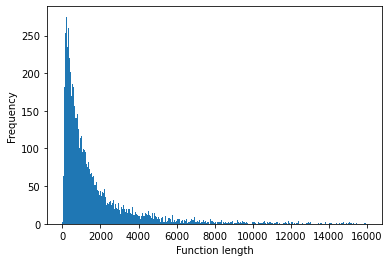

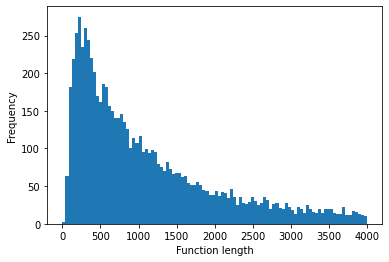


52.125% of functions are of shorter than 1000 characters


In [ ]:
# NOTE that this is done on a per character basis within the function!

code_df = preprocess_data(file_loc='code_dataset.jsonl')
func_len = list(code_df['func'].str.len())

print(func_len[0])
func_len.sort()

plt.hist(func_len, bins=400, range=(0,16000))
plt.xlabel("Function length")
plt.ylabel("Frequency")
plt.show()

plt.hist(func_len, bins=100, range=(0,4000))
plt.xlabel("Function length")
plt.ylabel("Frequency")
plt.show()

ratio_1000 = sum(i < 1000 for i in func_len)/len(func_len)
print("\n{}% of functions are of shorter than 1000 characters".format(100*ratio_1000))

Token indices sequence length is longer than the specified maximum sequence length for this model (1123 > 512). Running this sequence through the model will result in indexing errors


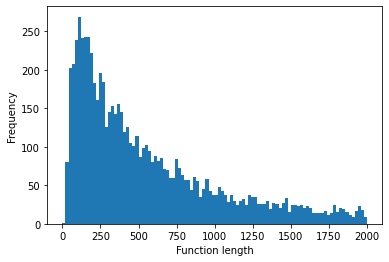

52.012499999999996% of tokenized functions are of shorter than 512 tokens


In [ ]:
model_name = 'codebert-base'
tokenizer = RobertaTokenizer.from_pretrained(model_name)
inputs = tokenizer(code_df['func'].tolist(), truncation=False)
input_data = inputs['input_ids']

data_len = []
for data in input_data:
  data_len.append(len(data))

data_len.sort()
plt.hist(data_len, bins=100, range=(0,2000))
plt.xlabel("Function length")
plt.ylabel("Frequency")
plt.show()

ratio_512 = sum(i < 512 for i in data_len)/len(data_len)
print("{:.4f}% of tokenized functions are of shorter than 512 tokens".format(100*ratio_512))

In [ ]:
model_name = 'codebert-base'
code_df = preprocess_data(file_loc='code_dataset.jsonl')
train_data, val_data, test_data = tokenize(code_df, model_name=model_name)

In [ ]:
train_input, train_attention, _ = train_data

In [ ]:
for i in range(10):
  print("Sample: {}".format(i+1))
  print("Input Data")
  print(train_input[i])
  print("Attention Mask")
  print(train_attention[i])

Sample: 1
Input Data
tensor([    0, 47908, 36704,  1020,  1215, 48702,  1215,  3654,  4591,  1640,
          846,  9211,   100,  7111,  3623,  2463,  1009,   705, 20068,     6,
         6979,   295,    43, 50118, 50118, 45152, 50140,  1437,  1437,  1437,
          114,    36,   282, 28696,   468, 40835,  6454,  1215,  4794,   100,
         1215,  1864,  9162,  9162,  1215, 30187, 48200,   748, 20068, 46613,
          705,  1343, 10975,   282,  8174,   705,  4506,     4, 45091,    43,
        25522, 50140,  1437,  1437,  1437,  1437,  1437,  1437,  1437, 13946,
         1215, 42660,  1020,  1215, 48702,  1215,  3654,  4591,  1640,   705,
        20068,     6,   295,     6,   359,   705, 20068, 46613,   705,  1343,
        10975,   282, 48601, 50140,  1437,  1437,  1437,  1437,  1437,  1437,
         1437,   748, 20068, 46613,   705,  1343, 10975,   282,  8174, 26628,
         1215, 46234,  1640,   705, 20068,     6,   359,   705, 20068, 46613,
          705,  1343, 10975,   282, 48601, 

## Main training configuration and running model

In [ ]:
def main():
    """
    Main configuration function for a given finetune run
    :return: None
    """

    run_name = "Final_lr=5e-6"
    model_name = 'codebert-base'
    dir_name = 'codebert_finetune_runs/{}'.format(run_name)

    checkpoint_location = None
    save_data = True
    online = False

    code_df = preprocess_data(file_loc='code_dataset.jsonl')
    train_data, val_data, test_data = tokenize(code_df, model_name=model_name)


    # Creating dir to save logs and checkpoints, re
    if os.path.exists(dir_name):
      input("run name already exists, press Enter to overwrite")
    else:
      os.makedirs(dir_name)

    if save_data:
      print("saving data splits")
      X_train, A_train, Y_train = train_data
      X_val, A_val, Y_val = val_data
      X_test, A_test, Y_test = test_data
      data_type = ['train', 'val', 'test']
      data_split_type = ['X', 'A', 'Y']
      data_all = [train_data, val_data, test_data]
      for i, data in enumerate(data_all):
        for j, split in enumerate(data):
          with open('{}/{}_{}.pickle'.format(dir_name,data_type[i], data_split_type[j]), 'wb') as handle:
            pickle.dump(split, handle)

    # Loading model from checkpoint if location provided
    if online:
        model = AutoModelForSequenceClassification.from_pretrained("microsoft/codebert-base")
    elif checkpoint_location is None:
        model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
    else:
        model = AutoModelForSequenceClassification.from_pretrained(checkpoint_location)

    train(model=model,
          train_data=train_data,
          val_data=val_data,
          epochs=5,
          batch_size=8,
          learning_rate=5e-6,
          validate_per=100,
          dir_name=dir_name,
          run_descrption="Colab with highRam, lr=5e-6, validate per 100, batch 8, redo")


In [ ]:
main()

Insecure code counts: 3729, Total code counts: 8000, Proportion 0.466125
Data points: 8000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


saving data splits


Some weights of the model checkpoint at codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at codebert-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for p

Epoch:0 Step:0 Training_loss:0.589329, Acc_avg:75.00% Training_loss_avg:0.589329
Validating:


52it [00:07,  6.55it/s]


Epoch:0 Step:0 Val_loss:0.681129, Val_Acc_avg:57.75%
Epoch:0 Step:8 Training_loss:0.624261, Acc_avg:75.00% Training_loss_avg:0.606795
Epoch:0 Step:16 Training_loss:0.771221, Acc_avg:62.50% Training_loss_avg:0.661604
Epoch:0 Step:24 Training_loss:0.808756, Acc_avg:56.25% Training_loss_avg:0.698392
Epoch:0 Step:32 Training_loss:0.646655, Acc_avg:60.00% Training_loss_avg:0.688045
Epoch:0 Step:40 Training_loss:0.718900, Acc_avg:58.33% Training_loss_avg:0.693187
Epoch:0 Step:48 Training_loss:0.679011, Acc_avg:58.93% Training_loss_avg:0.691162
Epoch:0 Step:56 Training_loss:0.569332, Acc_avg:62.50% Training_loss_avg:0.675933
Epoch:0 Step:64 Training_loss:0.761404, Acc_avg:61.11% Training_loss_avg:0.685430
Epoch:0 Step:72 Training_loss:0.573385, Acc_avg:63.75% Training_loss_avg:0.674225
Epoch:0 Step:80 Training_loss:0.627162, Acc_avg:63.64% Training_loss_avg:0.669947
Epoch:0 Step:88 Training_loss:0.713646, Acc_avg:62.50% Training_loss_avg:0.673589
Epoch:0 Step:96 Training_loss:0.571197, Acc_av

52it [00:07,  6.56it/s]


Epoch:0 Step:96 Val_loss:0.684716, Val_Acc_avg:57.75%
Epoch:0 Step:104 Training_loss:0.642624, Acc_avg:63.39% Training_loss_avg:0.664063
Epoch:0 Step:112 Training_loss:0.789285, Acc_avg:60.83% Training_loss_avg:0.672411
Epoch:0 Step:120 Training_loss:0.770315, Acc_avg:60.16% Training_loss_avg:0.678530
Epoch:0 Step:128 Training_loss:0.592435, Acc_avg:61.03% Training_loss_avg:0.673466
Epoch:0 Step:136 Training_loss:0.652490, Acc_avg:61.11% Training_loss_avg:0.672301
Epoch:0 Step:144 Training_loss:0.690117, Acc_avg:60.53% Training_loss_avg:0.673238
Epoch:0 Step:152 Training_loss:0.777899, Acc_avg:60.00% Training_loss_avg:0.678471
Epoch:0 Step:160 Training_loss:0.828533, Acc_avg:58.33% Training_loss_avg:0.685617
Epoch:0 Step:168 Training_loss:0.831583, Acc_avg:56.82% Training_loss_avg:0.692252
Epoch:0 Step:176 Training_loss:0.612426, Acc_avg:57.07% Training_loss_avg:0.688781
Epoch:0 Step:184 Training_loss:0.875740, Acc_avg:55.21% Training_loss_avg:0.696571
Epoch:0 Step:192 Training_loss:0.

52it [00:07,  6.56it/s]


Epoch:0 Step:192 Val_loss:0.680385, Val_Acc_avg:57.75%
Epoch:0 Step:200 Training_loss:0.747016, Acc_avg:55.77% Training_loss_avg:0.695763
Epoch:0 Step:208 Training_loss:0.599480, Acc_avg:56.94% Training_loss_avg:0.692197
Epoch:0 Step:216 Training_loss:0.683885, Acc_avg:56.70% Training_loss_avg:0.691900
Epoch:0 Step:224 Training_loss:0.646840, Acc_avg:56.90% Training_loss_avg:0.690346
Epoch:0 Step:232 Training_loss:0.722198, Acc_avg:56.25% Training_loss_avg:0.691408
Epoch:0 Step:240 Training_loss:0.638665, Acc_avg:56.45% Training_loss_avg:0.689706
Epoch:0 Step:248 Training_loss:0.616543, Acc_avg:57.03% Training_loss_avg:0.687420
Epoch:0 Step:256 Training_loss:0.647931, Acc_avg:57.20% Training_loss_avg:0.686223
Epoch:0 Step:264 Training_loss:0.678447, Acc_avg:57.35% Training_loss_avg:0.685995
Epoch:0 Step:272 Training_loss:0.654818, Acc_avg:57.50% Training_loss_avg:0.685104
Epoch:0 Step:280 Training_loss:0.695502, Acc_avg:57.29% Training_loss_avg:0.685393
Epoch:0 Step:288 Training_loss:0

52it [00:07,  6.55it/s]


Epoch:0 Step:288 Val_loss:0.680906, Val_Acc_avg:57.75%
Epoch:0 Step:296 Training_loss:0.652301, Acc_avg:57.57% Training_loss_avg:0.685524
Epoch:0 Step:304 Training_loss:0.678380, Acc_avg:57.69% Training_loss_avg:0.685340
Epoch:0 Step:312 Training_loss:0.637371, Acc_avg:58.44% Training_loss_avg:0.684141
Epoch:0 Step:320 Training_loss:0.629465, Acc_avg:58.84% Training_loss_avg:0.682808
Epoch:0 Step:328 Training_loss:0.711306, Acc_avg:58.63% Training_loss_avg:0.683486
Epoch:0 Step:336 Training_loss:0.680929, Acc_avg:58.72% Training_loss_avg:0.683427
Epoch:0 Step:344 Training_loss:0.667706, Acc_avg:59.38% Training_loss_avg:0.683069
Epoch:0 Step:352 Training_loss:0.668918, Acc_avg:59.44% Training_loss_avg:0.682755
Epoch:0 Step:360 Training_loss:0.727603, Acc_avg:58.70% Training_loss_avg:0.683730
Epoch:0 Step:368 Training_loss:0.595111, Acc_avg:59.04% Training_loss_avg:0.681844
Epoch:0 Step:376 Training_loss:0.691362, Acc_avg:58.85% Training_loss_avg:0.682043
Epoch:0 Step:384 Training_loss:0

52it [00:07,  6.55it/s]


Epoch:0 Step:384 Val_loss:0.680287, Val_Acc_avg:57.75%
Epoch:0 Step:392 Training_loss:0.708608, Acc_avg:58.75% Training_loss_avg:0.682511
Epoch:0 Step:400 Training_loss:0.697905, Acc_avg:58.50% Training_loss_avg:0.684682
Epoch:0 Step:408 Training_loss:0.672963, Acc_avg:58.25% Training_loss_avg:0.685656
Epoch:0 Step:416 Training_loss:0.569921, Acc_avg:59.50% Training_loss_avg:0.681630
Epoch:0 Step:424 Training_loss:0.737138, Acc_avg:59.75% Training_loss_avg:0.680198
Epoch:0 Step:432 Training_loss:0.716453, Acc_avg:59.00% Training_loss_avg:0.681594
Epoch:0 Step:440 Training_loss:0.670933, Acc_avg:59.00% Training_loss_avg:0.680635
Epoch:0 Step:448 Training_loss:0.651254, Acc_avg:59.00% Training_loss_avg:0.680080
Epoch:0 Step:456 Training_loss:0.655005, Acc_avg:58.25% Training_loss_avg:0.681793
Epoch:0 Step:464 Training_loss:0.620850, Acc_avg:58.75% Training_loss_avg:0.678982
Epoch:0 Step:472 Training_loss:0.740150, Acc_avg:57.75% Training_loss_avg:0.682317
Epoch:0 Step:480 Training_loss:0

52it [00:07,  6.56it/s]


Epoch:0 Step:480 Val_loss:0.680433, Val_Acc_avg:57.75%
Epoch:0 Step:488 Training_loss:0.678241, Acc_avg:57.75% Training_loss_avg:0.683347
Epoch:0 Step:496 Training_loss:0.762569, Acc_avg:57.00% Training_loss_avg:0.687175
Epoch:0 Step:504 Training_loss:0.794815, Acc_avg:56.50% Training_loss_avg:0.690219
Epoch:0 Step:512 Training_loss:0.643310, Acc_avg:57.25% Training_loss_avg:0.687299
Epoch:0 Step:520 Training_loss:0.766753, Acc_avg:56.75% Training_loss_avg:0.687228
Epoch:0 Step:528 Training_loss:0.691027, Acc_avg:56.25% Training_loss_avg:0.689200
Epoch:0 Step:536 Training_loss:0.611007, Acc_avg:56.50% Training_loss_avg:0.688370
Epoch:0 Step:544 Training_loss:0.751288, Acc_avg:56.25% Training_loss_avg:0.689594
Epoch:0 Step:552 Training_loss:0.578862, Acc_avg:56.75% Training_loss_avg:0.685613
Epoch:0 Step:560 Training_loss:0.613363, Acc_avg:57.75% Training_loss_avg:0.681309
Epoch:0 Step:568 Training_loss:0.578549, Acc_avg:59.25% Training_loss_avg:0.676249
Epoch:0 Step:576 Training_loss:0

52it [00:07,  6.55it/s]


Epoch:0 Step:576 Val_loss:0.679924, Val_Acc_avg:57.75%
Epoch:0 Step:584 Training_loss:0.648141, Acc_avg:59.75% Training_loss_avg:0.674455
Epoch:0 Step:592 Training_loss:0.594209, Acc_avg:60.00% Training_loss_avg:0.673837
Epoch:0 Step:600 Training_loss:0.701009, Acc_avg:60.00% Training_loss_avg:0.672917
Epoch:0 Step:608 Training_loss:0.655129, Acc_avg:59.50% Training_loss_avg:0.674030
Epoch:0 Step:616 Training_loss:0.695579, Acc_avg:59.50% Training_loss_avg:0.674264
Epoch:0 Step:624 Training_loss:0.626847, Acc_avg:59.75% Training_loss_avg:0.673864
Epoch:0 Step:632 Training_loss:0.657648, Acc_avg:60.25% Training_loss_avg:0.672573
Epoch:0 Step:640 Training_loss:0.657726, Acc_avg:60.25% Training_loss_avg:0.672954
Epoch:0 Step:648 Training_loss:0.654702, Acc_avg:60.00% Training_loss_avg:0.673717
Epoch:0 Step:656 Training_loss:0.686616, Acc_avg:60.00% Training_loss_avg:0.674491
Epoch:0 Step:664 Training_loss:0.613232, Acc_avg:60.25% Training_loss_avg:0.673187
Epoch:0 Step:672 Training_loss:0

52it [00:07,  6.56it/s]


Epoch:0 Step:672 Val_loss:0.682271, Val_Acc_avg:57.75%
Epoch:0 Step:680 Training_loss:0.672905, Acc_avg:60.00% Training_loss_avg:0.675913
Epoch:0 Step:688 Training_loss:0.617927, Acc_avg:60.50% Training_loss_avg:0.673802
Epoch:0 Step:696 Training_loss:0.574800, Acc_avg:60.75% Training_loss_avg:0.672252
Epoch:0 Step:704 Training_loss:0.755026, Acc_avg:60.50% Training_loss_avg:0.673785
Epoch:0 Step:712 Training_loss:0.799776, Acc_avg:59.50% Training_loss_avg:0.677033
Epoch:0 Step:720 Training_loss:0.661522, Acc_avg:59.25% Training_loss_avg:0.677674
Epoch:0 Step:728 Training_loss:0.577947, Acc_avg:60.00% Training_loss_avg:0.675007
Epoch:0 Step:736 Training_loss:0.886527, Acc_avg:59.25% Training_loss_avg:0.679119
Epoch:0 Step:744 Training_loss:0.704313, Acc_avg:58.75% Training_loss_avg:0.679851
Epoch:0 Step:752 Training_loss:0.754258, Acc_avg:58.50% Training_loss_avg:0.681558
Epoch:0 Step:760 Training_loss:0.717334, Acc_avg:59.25% Training_loss_avg:0.681352
Epoch:0 Step:768 Training_loss:0

52it [00:07,  6.56it/s]


Epoch:0 Step:768 Val_loss:0.683216, Val_Acc_avg:57.75%
Epoch:0 Step:776 Training_loss:0.770410, Acc_avg:58.00% Training_loss_avg:0.689127
Epoch:0 Step:784 Training_loss:0.667866, Acc_avg:58.00% Training_loss_avg:0.688907
Epoch:0 Step:792 Training_loss:0.509016, Acc_avg:59.00% Training_loss_avg:0.684915
Epoch:0 Step:800 Training_loss:0.713981, Acc_avg:58.75% Training_loss_avg:0.685236
Epoch:0 Step:808 Training_loss:0.740125, Acc_avg:58.25% Training_loss_avg:0.686579
Epoch:0 Step:816 Training_loss:0.658739, Acc_avg:57.50% Training_loss_avg:0.688356
Epoch:0 Step:824 Training_loss:0.796153, Acc_avg:57.25% Training_loss_avg:0.689536
Epoch:0 Step:832 Training_loss:0.750861, Acc_avg:57.25% Training_loss_avg:0.690224
Epoch:0 Step:840 Training_loss:0.700586, Acc_avg:57.25% Training_loss_avg:0.690817
Epoch:0 Step:848 Training_loss:0.804832, Acc_avg:56.25% Training_loss_avg:0.693889
Epoch:0 Step:856 Training_loss:0.659574, Acc_avg:56.50% Training_loss_avg:0.693980
Epoch:0 Step:864 Training_loss:0

52it [00:07,  6.55it/s]


Epoch:0 Step:864 Val_loss:0.679353, Val_Acc_avg:57.75%
Epoch:0 Step:872 Training_loss:0.730672, Acc_avg:56.00% Training_loss_avg:0.696242
Epoch:0 Step:880 Training_loss:0.723473, Acc_avg:56.00% Training_loss_avg:0.696430
Epoch:0 Step:888 Training_loss:0.685705, Acc_avg:55.75% Training_loss_avg:0.696580
Epoch:0 Step:896 Training_loss:0.721903, Acc_avg:56.25% Training_loss_avg:0.695766
Epoch:0 Step:904 Training_loss:0.677547, Acc_avg:56.50% Training_loss_avg:0.693421
Epoch:0 Step:912 Training_loss:0.702382, Acc_avg:56.00% Training_loss_avg:0.694602
Epoch:0 Step:920 Training_loss:0.769358, Acc_avg:55.75% Training_loss_avg:0.694654
Epoch:0 Step:928 Training_loss:0.651410, Acc_avg:56.50% Training_loss_avg:0.693862
Epoch:0 Step:936 Training_loss:0.702845, Acc_avg:55.75% Training_loss_avg:0.695699
Epoch:0 Step:944 Training_loss:0.688329, Acc_avg:56.00% Training_loss_avg:0.694440
Epoch:0 Step:952 Training_loss:0.712083, Acc_avg:55.25% Training_loss_avg:0.697104
Epoch:0 Step:960 Training_loss:0

52it [00:07,  6.55it/s]


Epoch:0 Step:960 Val_loss:0.686434, Val_Acc_avg:59.00%
Epoch:0 Step:968 Training_loss:0.697691, Acc_avg:53.50% Training_loss_avg:0.701389
Epoch:0 Step:976 Training_loss:0.704831, Acc_avg:53.75% Training_loss_avg:0.700479
Epoch:0 Step:984 Training_loss:0.658967, Acc_avg:53.75% Training_loss_avg:0.700696
Epoch:0 Step:992 Training_loss:0.673079, Acc_avg:53.25% Training_loss_avg:0.702273
Epoch:0 Step:1000 Training_loss:0.643488, Acc_avg:53.75% Training_loss_avg:0.701123
Epoch:0 Step:1008 Training_loss:0.675502, Acc_avg:53.50% Training_loss_avg:0.701530
Epoch:0 Step:1016 Training_loss:0.745671, Acc_avg:53.25% Training_loss_avg:0.702532
Epoch:0 Step:1024 Training_loss:0.667836, Acc_avg:53.00% Training_loss_avg:0.703352
Epoch:0 Step:1032 Training_loss:0.669827, Acc_avg:53.25% Training_loss_avg:0.703595
Epoch:0 Step:1040 Training_loss:0.673699, Acc_avg:53.00% Training_loss_avg:0.703915
Epoch:0 Step:1048 Training_loss:0.640345, Acc_avg:53.25% Training_loss_avg:0.703628
Epoch:0 Step:1056 Trainin

52it [00:07,  6.55it/s]


Epoch:0 Step:1056 Val_loss:0.695050, Val_Acc_avg:45.25%
Epoch:0 Step:1064 Training_loss:0.712943, Acc_avg:52.50% Training_loss_avg:0.705585
Epoch:0 Step:1072 Training_loss:0.687655, Acc_avg:52.50% Training_loss_avg:0.703064
Epoch:0 Step:1080 Training_loss:0.752175, Acc_avg:51.50% Training_loss_avg:0.704649
Epoch:0 Step:1088 Training_loss:0.751250, Acc_avg:50.50% Training_loss_avg:0.707316
Epoch:0 Step:1096 Training_loss:0.698299, Acc_avg:49.75% Training_loss_avg:0.709786
Epoch:0 Step:1104 Training_loss:0.628271, Acc_avg:50.00% Training_loss_avg:0.707251
Epoch:0 Step:1112 Training_loss:0.667378, Acc_avg:50.25% Training_loss_avg:0.704603
Epoch:0 Step:1120 Training_loss:0.726265, Acc_avg:49.75% Training_loss_avg:0.705897
Epoch:0 Step:1128 Training_loss:0.668068, Acc_avg:49.25% Training_loss_avg:0.707700
Epoch:0 Step:1136 Training_loss:0.771161, Acc_avg:49.75% Training_loss_avg:0.705393
Epoch:0 Step:1144 Training_loss:0.647157, Acc_avg:50.00% Training_loss_avg:0.704249
Epoch:0 Step:1152 Tr

52it [00:07,  6.56it/s]


Epoch:0 Step:1152 Val_loss:0.692856, Val_Acc_avg:50.00%
Epoch:0 Step:1160 Training_loss:0.681091, Acc_avg:50.75% Training_loss_avg:0.701981
Epoch:0 Step:1168 Training_loss:0.742667, Acc_avg:51.25% Training_loss_avg:0.698739
Epoch:0 Step:1176 Training_loss:0.655063, Acc_avg:51.25% Training_loss_avg:0.696432
Epoch:0 Step:1184 Training_loss:0.734087, Acc_avg:51.25% Training_loss_avg:0.697756
Epoch:0 Step:1192 Training_loss:0.707579, Acc_avg:50.50% Training_loss_avg:0.701728
Epoch:0 Step:1200 Training_loss:0.735894, Acc_avg:50.25% Training_loss_avg:0.702166
Epoch:0 Step:1208 Training_loss:0.686813, Acc_avg:50.75% Training_loss_avg:0.701100
Epoch:0 Step:1216 Training_loss:0.686075, Acc_avg:50.50% Training_loss_avg:0.701646
Epoch:0 Step:1224 Training_loss:0.725132, Acc_avg:50.75% Training_loss_avg:0.700226
Epoch:0 Step:1232 Training_loss:0.697319, Acc_avg:51.25% Training_loss_avg:0.699155
Epoch:0 Step:1240 Training_loss:0.613587, Acc_avg:51.75% Training_loss_avg:0.697415
Epoch:0 Step:1248 Tr

52it [00:07,  6.55it/s]


Epoch:0 Step:1248 Val_loss:0.678857, Val_Acc_avg:57.75%
Epoch:0 Step:1256 Training_loss:0.570820, Acc_avg:53.50% Training_loss_avg:0.693219
Epoch:0 Step:1264 Training_loss:0.746607, Acc_avg:53.25% Training_loss_avg:0.693283
Epoch:0 Step:1272 Training_loss:0.735370, Acc_avg:53.00% Training_loss_avg:0.693376
Epoch:0 Step:1280 Training_loss:0.581410, Acc_avg:53.50% Training_loss_avg:0.690535
Epoch:0 Step:1288 Training_loss:0.697261, Acc_avg:53.75% Training_loss_avg:0.690766
Epoch:0 Step:1296 Training_loss:0.779066, Acc_avg:53.00% Training_loss_avg:0.691910
Epoch:0 Step:1304 Training_loss:0.598665, Acc_avg:53.50% Training_loss_avg:0.690332
Epoch:0 Step:1312 Training_loss:0.588945, Acc_avg:54.50% Training_loss_avg:0.688063
Epoch:0 Step:1320 Training_loss:0.695303, Acc_avg:55.25% Training_loss_avg:0.686582
Epoch:0 Step:1328 Training_loss:0.629001, Acc_avg:54.75% Training_loss_avg:0.686134
Epoch:0 Step:1336 Training_loss:0.785375, Acc_avg:54.75% Training_loss_avg:0.687785
Epoch:0 Step:1344 Tr

52it [00:07,  6.56it/s]


Epoch:0 Step:1344 Val_loss:0.684400, Val_Acc_avg:57.75%
Epoch:0 Step:1352 Training_loss:0.848472, Acc_avg:54.75% Training_loss_avg:0.690058
Epoch:0 Step:1360 Training_loss:0.588528, Acc_avg:55.50% Training_loss_avg:0.687659
Epoch:0 Step:1368 Training_loss:0.602967, Acc_avg:56.00% Training_loss_avg:0.685765
Epoch:0 Step:1376 Training_loss:0.747466, Acc_avg:56.00% Training_loss_avg:0.686618
Epoch:0 Step:1384 Training_loss:0.664084, Acc_avg:56.00% Training_loss_avg:0.686720
Epoch:0 Step:1392 Training_loss:0.644963, Acc_avg:56.00% Training_loss_avg:0.686158
Epoch:0 Step:1400 Training_loss:0.742118, Acc_avg:55.50% Training_loss_avg:0.688130
Epoch:0 Step:1408 Training_loss:0.687015, Acc_avg:55.75% Training_loss_avg:0.688360
Epoch:0 Step:1416 Training_loss:0.596694, Acc_avg:56.50% Training_loss_avg:0.685381
Epoch:0 Step:1424 Training_loss:0.568286, Acc_avg:56.75% Training_loss_avg:0.683390
Epoch:0 Step:1432 Training_loss:0.645951, Acc_avg:56.50% Training_loss_avg:0.682912
Epoch:0 Step:1440 Tr

52it [00:07,  6.56it/s]


Epoch:0 Step:1440 Val_loss:0.687016, Val_Acc_avg:57.75%
Epoch:0 Step:1448 Training_loss:0.698174, Acc_avg:56.50% Training_loss_avg:0.682964
Epoch:0 Step:1456 Training_loss:0.755043, Acc_avg:56.50% Training_loss_avg:0.684370
Epoch:0 Step:1464 Training_loss:0.703902, Acc_avg:56.50% Training_loss_avg:0.684189
Epoch:0 Step:1472 Training_loss:0.719032, Acc_avg:56.75% Training_loss_avg:0.684816
Epoch:0 Step:1480 Training_loss:0.775753, Acc_avg:57.50% Training_loss_avg:0.685288
Epoch:0 Step:1488 Training_loss:0.807380, Acc_avg:57.75% Training_loss_avg:0.686411
Epoch:0 Step:1496 Training_loss:0.692650, Acc_avg:57.75% Training_loss_avg:0.686298
Epoch:0 Step:1504 Training_loss:0.523399, Acc_avg:58.25% Training_loss_avg:0.684200
Epoch:0 Step:1512 Training_loss:0.589361, Acc_avg:58.75% Training_loss_avg:0.682640
Epoch:0 Step:1520 Training_loss:0.558576, Acc_avg:59.50% Training_loss_avg:0.679286
Epoch:0 Step:1528 Training_loss:0.783163, Acc_avg:59.00% Training_loss_avg:0.681588
Epoch:0 Step:1536 Tr

52it [00:07,  6.56it/s]


Epoch:0 Step:1536 Val_loss:0.684732, Val_Acc_avg:57.75%
Epoch:0 Step:1544 Training_loss:0.663762, Acc_avg:59.25% Training_loss_avg:0.679099
Epoch:0 Step:1552 Training_loss:0.487031, Acc_avg:59.75% Training_loss_avg:0.675297
Epoch:0 Step:1560 Training_loss:0.566113, Acc_avg:59.75% Training_loss_avg:0.672998
Epoch:0 Step:1568 Training_loss:0.523210, Acc_avg:60.75% Training_loss_avg:0.668609
Epoch:0 Step:1576 Training_loss:0.800044, Acc_avg:60.50% Training_loss_avg:0.671508
Epoch:0 Step:1584 Training_loss:0.632526, Acc_avg:60.50% Training_loss_avg:0.669477
Epoch:0 Step:1592 Training_loss:0.770350, Acc_avg:60.25% Training_loss_avg:0.670732
Epoch:0 Step:1600 Training_loss:0.702843, Acc_avg:60.50% Training_loss_avg:0.670071
Epoch:0 Step:1608 Training_loss:0.760183, Acc_avg:60.25% Training_loss_avg:0.671539
Epoch:0 Step:1616 Training_loss:0.702560, Acc_avg:60.25% Training_loss_avg:0.671868
Epoch:0 Step:1624 Training_loss:0.573008, Acc_avg:60.75% Training_loss_avg:0.668826
Epoch:0 Step:1632 Tr

52it [00:07,  6.55it/s]


Epoch:0 Step:1632 Val_loss:0.686639, Val_Acc_avg:57.75%
Epoch:0 Step:1640 Training_loss:0.618218, Acc_avg:60.00% Training_loss_avg:0.670527
Epoch:0 Step:1648 Training_loss:0.620603, Acc_avg:60.25% Training_loss_avg:0.669264
Epoch:0 Step:1656 Training_loss:0.608761, Acc_avg:59.50% Training_loss_avg:0.670022
Epoch:0 Step:1664 Training_loss:0.798320, Acc_avg:59.75% Training_loss_avg:0.671057
Epoch:0 Step:1672 Training_loss:0.841023, Acc_avg:59.50% Training_loss_avg:0.673170
Epoch:0 Step:1680 Training_loss:0.742440, Acc_avg:59.00% Training_loss_avg:0.676390
Epoch:0 Step:1688 Training_loss:0.757214, Acc_avg:58.50% Training_loss_avg:0.677589
Epoch:0 Step:1696 Training_loss:0.737743, Acc_avg:59.00% Training_loss_avg:0.676763
Epoch:0 Step:1704 Training_loss:0.740639, Acc_avg:58.25% Training_loss_avg:0.679602
Epoch:0 Step:1712 Training_loss:0.577140, Acc_avg:58.00% Training_loss_avg:0.679366
Epoch:0 Step:1720 Training_loss:0.756522, Acc_avg:57.75% Training_loss_avg:0.680591
Epoch:0 Step:1728 Tr

52it [00:07,  6.54it/s]


Epoch:0 Step:1728 Val_loss:0.678352, Val_Acc_avg:57.75%
Epoch:0 Step:1736 Training_loss:0.707346, Acc_avg:57.75% Training_loss_avg:0.681513
Epoch:0 Step:1744 Training_loss:0.534795, Acc_avg:58.50% Training_loss_avg:0.678896
Epoch:0 Step:1752 Training_loss:0.703952, Acc_avg:58.75% Training_loss_avg:0.676006
Epoch:0 Step:1760 Training_loss:0.706215, Acc_avg:58.25% Training_loss_avg:0.678359
Epoch:0 Step:1768 Training_loss:0.660379, Acc_avg:58.00% Training_loss_avg:0.679508
Epoch:0 Step:1776 Training_loss:0.742686, Acc_avg:57.50% Training_loss_avg:0.679412
Epoch:0 Step:1784 Training_loss:0.660474, Acc_avg:57.75% Training_loss_avg:0.679340
Epoch:0 Step:1792 Training_loss:0.628919, Acc_avg:57.75% Training_loss_avg:0.679019
Epoch:0 Step:1800 Training_loss:0.691024, Acc_avg:57.50% Training_loss_avg:0.677997
Epoch:0 Step:1808 Training_loss:0.676189, Acc_avg:57.50% Training_loss_avg:0.677781
Epoch:0 Step:1816 Training_loss:0.729623, Acc_avg:56.75% Training_loss_avg:0.680439
Epoch:0 Step:1824 Tr

52it [00:07,  6.55it/s]


Epoch:0 Step:1824 Val_loss:0.678123, Val_Acc_avg:58.00%
Epoch:0 Step:1832 Training_loss:0.705724, Acc_avg:56.00% Training_loss_avg:0.683998
Epoch:0 Step:1840 Training_loss:0.674044, Acc_avg:56.00% Training_loss_avg:0.685110
Epoch:0 Step:1848 Training_loss:0.721816, Acc_avg:55.75% Training_loss_avg:0.685583
Epoch:0 Step:1856 Training_loss:0.692381, Acc_avg:56.00% Training_loss_avg:0.684330
Epoch:0 Step:1864 Training_loss:0.676412, Acc_avg:56.25% Training_loss_avg:0.683780
Epoch:0 Step:1872 Training_loss:0.731314, Acc_avg:56.00% Training_loss_avg:0.684025
Epoch:0 Step:1880 Training_loss:0.643709, Acc_avg:56.25% Training_loss_avg:0.681385
Epoch:0 Step:1888 Training_loss:0.651778, Acc_avg:56.75% Training_loss_avg:0.678273
Epoch:0 Step:1896 Training_loss:0.714107, Acc_avg:56.50% Training_loss_avg:0.678702
Epoch:0 Step:1904 Training_loss:0.660682, Acc_avg:56.25% Training_loss_avg:0.681447
Epoch:0 Step:1912 Training_loss:0.641974, Acc_avg:56.25% Training_loss_avg:0.682500
Epoch:0 Step:1920 Tr

52it [00:07,  6.55it/s]


Epoch:0 Step:1920 Val_loss:0.679067, Val_Acc_avg:58.75%
Epoch:0 Step:1928 Training_loss:0.658511, Acc_avg:57.00% Training_loss_avg:0.682061
Epoch:0 Step:1936 Training_loss:0.654924, Acc_avg:56.75% Training_loss_avg:0.682558
Epoch:0 Step:1944 Training_loss:0.696887, Acc_avg:56.25% Training_loss_avg:0.683221
Epoch:0 Step:1952 Training_loss:0.615371, Acc_avg:56.00% Training_loss_avg:0.685787
Epoch:0 Step:1960 Training_loss:0.649466, Acc_avg:56.00% Training_loss_avg:0.687454
Epoch:0 Step:1968 Training_loss:0.780676, Acc_avg:54.75% Training_loss_avg:0.692604
Epoch:0 Step:1976 Training_loss:0.644550, Acc_avg:55.50% Training_loss_avg:0.689494
Epoch:0 Step:1984 Training_loss:0.636992, Acc_avg:55.75% Training_loss_avg:0.689583
Epoch:0 Step:1992 Training_loss:0.553855, Acc_avg:56.75% Training_loss_avg:0.685253
Epoch:0 Step:2000 Training_loss:0.727490, Acc_avg:56.75% Training_loss_avg:0.685746
Epoch:0 Step:2008 Training_loss:0.724783, Acc_avg:56.75% Training_loss_avg:0.685038
Epoch:0 Step:2016 Tr

52it [00:07,  6.55it/s]


Epoch:0 Step:2016 Val_loss:0.677010, Val_Acc_avg:57.75%
Epoch:0 Step:2024 Training_loss:0.714758, Acc_avg:56.00% Training_loss_avg:0.687489
Epoch:0 Step:2032 Training_loss:0.680009, Acc_avg:56.25% Training_loss_avg:0.685535
Epoch:0 Step:2040 Training_loss:0.699343, Acc_avg:56.00% Training_loss_avg:0.687157
Epoch:0 Step:2048 Training_loss:0.607036, Acc_avg:55.75% Training_loss_avg:0.686886
Epoch:0 Step:2056 Training_loss:0.770922, Acc_avg:55.25% Training_loss_avg:0.690129
Epoch:0 Step:2064 Training_loss:0.728375, Acc_avg:55.50% Training_loss_avg:0.688730
Epoch:0 Step:2072 Training_loss:0.730209, Acc_avg:55.75% Training_loss_avg:0.686514
Epoch:0 Step:2080 Training_loss:0.672637, Acc_avg:56.00% Training_loss_avg:0.685118
Epoch:0 Step:2088 Training_loss:0.805608, Acc_avg:55.50% Training_loss_avg:0.686086
Epoch:0 Step:2096 Training_loss:0.612707, Acc_avg:55.75% Training_loss_avg:0.683585
Epoch:0 Step:2104 Training_loss:0.567615, Acc_avg:56.75% Training_loss_avg:0.680125
Epoch:0 Step:2112 Tr

52it [00:07,  6.56it/s]


Epoch:0 Step:2112 Val_loss:0.676781, Val_Acc_avg:57.75%
Epoch:0 Step:2120 Training_loss:0.715443, Acc_avg:56.75% Training_loss_avg:0.680266
Epoch:0 Step:2128 Training_loss:0.689012, Acc_avg:57.00% Training_loss_avg:0.678984
Epoch:0 Step:2136 Training_loss:0.711829, Acc_avg:56.50% Training_loss_avg:0.679073
Epoch:0 Step:2144 Training_loss:0.743527, Acc_avg:55.25% Training_loss_avg:0.683248
Epoch:0 Step:2152 Training_loss:0.703742, Acc_avg:55.50% Training_loss_avg:0.683244
Epoch:0 Step:2160 Training_loss:0.742531, Acc_avg:55.25% Training_loss_avg:0.683970
Epoch:0 Step:2168 Training_loss:0.623652, Acc_avg:55.50% Training_loss_avg:0.683235
Epoch:0 Step:2176 Training_loss:0.757899, Acc_avg:55.50% Training_loss_avg:0.683540
Epoch:0 Step:2184 Training_loss:0.708580, Acc_avg:55.25% Training_loss_avg:0.684502
Epoch:0 Step:2192 Training_loss:0.750915, Acc_avg:54.75% Training_loss_avg:0.686942
Epoch:0 Step:2200 Training_loss:0.648035, Acc_avg:55.25% Training_loss_avg:0.686082
Epoch:0 Step:2208 Tr

52it [00:07,  6.55it/s]


Epoch:0 Step:2208 Val_loss:0.678408, Val_Acc_avg:59.25%
Epoch:0 Step:2216 Training_loss:0.724637, Acc_avg:54.75% Training_loss_avg:0.687154
Epoch:0 Step:2224 Training_loss:0.612074, Acc_avg:55.50% Training_loss_avg:0.685666
Epoch:0 Step:2232 Training_loss:0.702692, Acc_avg:55.25% Training_loss_avg:0.685606
Epoch:0 Step:2240 Training_loss:0.641116, Acc_avg:55.00% Training_loss_avg:0.684947
Epoch:0 Step:2248 Training_loss:0.647508, Acc_avg:55.25% Training_loss_avg:0.683461
Epoch:0 Step:2256 Training_loss:0.631416, Acc_avg:55.50% Training_loss_avg:0.682242
Epoch:0 Step:2264 Training_loss:0.656820, Acc_avg:55.50% Training_loss_avg:0.681850
Epoch:0 Step:2272 Training_loss:0.675180, Acc_avg:56.00% Training_loss_avg:0.680727
Epoch:0 Step:2280 Training_loss:0.689856, Acc_avg:55.50% Training_loss_avg:0.681650
Epoch:0 Step:2288 Training_loss:0.651900, Acc_avg:55.50% Training_loss_avg:0.681653
Epoch:0 Step:2296 Training_loss:0.737260, Acc_avg:55.25% Training_loss_avg:0.682116
Epoch:0 Step:2304 Tr

52it [00:07,  6.56it/s]


Epoch:0 Step:2304 Val_loss:0.676864, Val_Acc_avg:58.75%
Epoch:0 Step:2312 Training_loss:0.686186, Acc_avg:53.75% Training_loss_avg:0.683788
Epoch:0 Step:2320 Training_loss:0.708499, Acc_avg:53.25% Training_loss_avg:0.684732
Epoch:0 Step:2328 Training_loss:0.738448, Acc_avg:52.25% Training_loss_avg:0.686330
Epoch:0 Step:2336 Training_loss:0.667226, Acc_avg:52.25% Training_loss_avg:0.686576
Epoch:0 Step:2344 Training_loss:0.724468, Acc_avg:52.00% Training_loss_avg:0.687128
Epoch:0 Step:2352 Training_loss:0.593282, Acc_avg:52.25% Training_loss_avg:0.686686
Epoch:0 Step:2360 Training_loss:0.659256, Acc_avg:51.50% Training_loss_avg:0.686882
Epoch:0 Step:2368 Training_loss:0.720467, Acc_avg:51.75% Training_loss_avg:0.685678
Epoch:0 Step:2376 Training_loss:0.686447, Acc_avg:51.25% Training_loss_avg:0.686516
Epoch:0 Step:2384 Training_loss:0.764599, Acc_avg:50.50% Training_loss_avg:0.689068
Epoch:0 Step:2392 Training_loss:0.673799, Acc_avg:49.75% Training_loss_avg:0.691467
Epoch:0 Step:2400 Tr

52it [00:07,  6.55it/s]


Epoch:0 Step:2400 Val_loss:0.675799, Val_Acc_avg:59.50%
Epoch:0 Step:2408 Training_loss:0.681424, Acc_avg:50.25% Training_loss_avg:0.690023
Epoch:0 Step:2416 Training_loss:0.712068, Acc_avg:50.25% Training_loss_avg:0.690597
Epoch:0 Step:2424 Training_loss:0.700440, Acc_avg:50.75% Training_loss_avg:0.690310
Epoch:0 Step:2432 Training_loss:0.674912, Acc_avg:51.00% Training_loss_avg:0.690208
Epoch:0 Step:2440 Training_loss:0.637054, Acc_avg:51.25% Training_loss_avg:0.688962
Epoch:0 Step:2448 Training_loss:0.654459, Acc_avg:51.50% Training_loss_avg:0.689911
Epoch:0 Step:2456 Training_loss:0.728747, Acc_avg:51.50% Training_loss_avg:0.689067
Epoch:0 Step:2464 Training_loss:0.755887, Acc_avg:51.00% Training_loss_avg:0.689618
Epoch:0 Step:2472 Training_loss:0.674483, Acc_avg:51.50% Training_loss_avg:0.688503
Epoch:0 Step:2480 Training_loss:0.638412, Acc_avg:51.75% Training_loss_avg:0.687819
Epoch:0 Step:2488 Training_loss:0.676562, Acc_avg:52.75% Training_loss_avg:0.685238
Epoch:0 Step:2496 Tr

52it [00:07,  6.55it/s]


Epoch:0 Step:2496 Val_loss:0.675945, Val_Acc_avg:61.50%
Epoch:0 Step:2504 Training_loss:0.644496, Acc_avg:52.00% Training_loss_avg:0.689254
Epoch:0 Step:2512 Training_loss:0.630943, Acc_avg:52.50% Training_loss_avg:0.689367
Epoch:0 Step:2520 Training_loss:0.634049, Acc_avg:53.00% Training_loss_avg:0.687739
Epoch:0 Step:2528 Training_loss:0.680416, Acc_avg:53.00% Training_loss_avg:0.687567
Epoch:0 Step:2536 Training_loss:0.720506, Acc_avg:53.25% Training_loss_avg:0.687741
Epoch:0 Step:2544 Training_loss:0.722981, Acc_avg:53.50% Training_loss_avg:0.687330
Epoch:0 Step:2552 Training_loss:0.750198, Acc_avg:53.50% Training_loss_avg:0.688259
Epoch:0 Step:2560 Training_loss:0.670075, Acc_avg:53.75% Training_loss_avg:0.686810
Epoch:0 Step:2568 Training_loss:0.728418, Acc_avg:53.25% Training_loss_avg:0.688905
Epoch:0 Step:2576 Training_loss:0.595438, Acc_avg:54.25% Training_loss_avg:0.685656
Epoch:0 Step:2584 Training_loss:0.586725, Acc_avg:54.75% Training_loss_avg:0.683219
Epoch:0 Step:2592 Tr

52it [00:07,  6.54it/s]


Epoch:0 Step:2592 Val_loss:0.673553, Val_Acc_avg:60.25%
Epoch:0 Step:2600 Training_loss:0.676234, Acc_avg:55.25% Training_loss_avg:0.682220
Epoch:0 Step:2608 Training_loss:0.678819, Acc_avg:56.00% Training_loss_avg:0.681100
Epoch:0 Step:2616 Training_loss:0.775073, Acc_avg:56.00% Training_loss_avg:0.682109
Epoch:0 Step:2624 Training_loss:0.631599, Acc_avg:56.00% Training_loss_avg:0.682499
Epoch:0 Step:2632 Training_loss:0.713852, Acc_avg:56.25% Training_loss_avg:0.682722
Epoch:0 Step:2640 Training_loss:0.621604, Acc_avg:56.25% Training_loss_avg:0.682332
Epoch:0 Step:2648 Training_loss:0.783587, Acc_avg:55.50% Training_loss_avg:0.685054
Epoch:0 Step:2656 Training_loss:0.602016, Acc_avg:55.50% Training_loss_avg:0.684466
Epoch:0 Step:2664 Training_loss:0.697644, Acc_avg:55.00% Training_loss_avg:0.685282
Epoch:0 Step:2672 Training_loss:0.545994, Acc_avg:55.75% Training_loss_avg:0.682699
Epoch:0 Step:2680 Training_loss:0.646877, Acc_avg:56.25% Training_loss_avg:0.681839
Epoch:0 Step:2688 Tr

52it [00:07,  6.56it/s]


Epoch:0 Step:2688 Val_loss:0.672806, Val_Acc_avg:60.25%
Epoch:0 Step:2696 Training_loss:0.699767, Acc_avg:56.25% Training_loss_avg:0.682802
Epoch:0 Step:2704 Training_loss:0.692798, Acc_avg:56.50% Training_loss_avg:0.682656
Epoch:0 Step:2712 Training_loss:0.678410, Acc_avg:56.75% Training_loss_avg:0.682500
Epoch:0 Step:2720 Training_loss:0.698217, Acc_avg:56.75% Training_loss_avg:0.682295
Epoch:0 Step:2728 Training_loss:0.642301, Acc_avg:57.50% Training_loss_avg:0.680372
Epoch:0 Step:2736 Training_loss:0.726706, Acc_avg:57.25% Training_loss_avg:0.681561
Epoch:0 Step:2744 Training_loss:0.690769, Acc_avg:57.50% Training_loss_avg:0.680887
Epoch:0 Step:2752 Training_loss:0.711867, Acc_avg:56.25% Training_loss_avg:0.683259
Epoch:0 Step:2760 Training_loss:0.701544, Acc_avg:56.50% Training_loss_avg:0.684105
Epoch:0 Step:2768 Training_loss:0.672547, Acc_avg:57.00% Training_loss_avg:0.683146
Epoch:0 Step:2776 Training_loss:0.642699, Acc_avg:57.25% Training_loss_avg:0.682271
Epoch:0 Step:2784 Tr

52it [00:07,  6.55it/s]


Epoch:0 Step:2784 Val_loss:0.672613, Val_Acc_avg:61.00%
Epoch:0 Step:2792 Training_loss:0.723585, Acc_avg:56.50% Training_loss_avg:0.684053
Epoch:0 Step:2800 Training_loss:0.666491, Acc_avg:56.50% Training_loss_avg:0.683410
Epoch:0 Step:2808 Training_loss:0.692362, Acc_avg:56.00% Training_loss_avg:0.683629
Epoch:0 Step:2816 Training_loss:0.705200, Acc_avg:55.75% Training_loss_avg:0.683491
Epoch:0 Step:2824 Training_loss:0.696152, Acc_avg:55.50% Training_loss_avg:0.683406
Epoch:0 Step:2832 Training_loss:0.792660, Acc_avg:54.50% Training_loss_avg:0.685761
Epoch:0 Step:2840 Training_loss:0.614924, Acc_avg:54.75% Training_loss_avg:0.685318
Epoch:0 Step:2848 Training_loss:0.671923, Acc_avg:54.25% Training_loss_avg:0.685667
Epoch:0 Step:2856 Training_loss:0.705340, Acc_avg:54.50% Training_loss_avg:0.685199
Epoch:0 Step:2864 Training_loss:0.654107, Acc_avg:55.50% Training_loss_avg:0.683164
Epoch:0 Step:2872 Training_loss:0.674400, Acc_avg:55.50% Training_loss_avg:0.683162
Epoch:0 Step:2880 Tr

52it [00:07,  6.55it/s]


Epoch:0 Step:2880 Val_loss:0.672266, Val_Acc_avg:60.50%
Epoch:0 Step:2888 Training_loss:0.744665, Acc_avg:54.50% Training_loss_avg:0.685228
Epoch:0 Step:2896 Training_loss:0.750064, Acc_avg:54.50% Training_loss_avg:0.685496
Epoch:0 Step:2904 Training_loss:0.706204, Acc_avg:54.25% Training_loss_avg:0.686730
Epoch:0 Step:2912 Training_loss:0.696163, Acc_avg:53.25% Training_loss_avg:0.688035
Epoch:0 Step:2920 Training_loss:0.690088, Acc_avg:53.00% Training_loss_avg:0.689155
Epoch:0 Step:2928 Training_loss:0.745765, Acc_avg:52.50% Training_loss_avg:0.690462
Epoch:0 Step:2936 Training_loss:0.684739, Acc_avg:52.25% Training_loss_avg:0.689747
Epoch:0 Step:2944 Training_loss:0.616119, Acc_avg:52.75% Training_loss_avg:0.687610
Epoch:0 Step:2952 Training_loss:0.634639, Acc_avg:53.00% Training_loss_avg:0.685299
Epoch:0 Step:2960 Training_loss:0.720799, Acc_avg:53.25% Training_loss_avg:0.686313
Epoch:0 Step:2968 Training_loss:0.654796, Acc_avg:53.50% Training_loss_avg:0.684841
Epoch:0 Step:2976 Tr

52it [00:07,  6.56it/s]


Epoch:0 Step:2976 Val_loss:0.681147, Val_Acc_avg:56.75%
Epoch:0 Step:2984 Training_loss:0.631236, Acc_avg:53.00% Training_loss_avg:0.686458
Epoch:0 Step:2992 Training_loss:0.607984, Acc_avg:53.25% Training_loss_avg:0.685163
Epoch:0 Step:3000 Training_loss:0.619883, Acc_avg:53.25% Training_loss_avg:0.684036
Epoch:0 Step:3008 Training_loss:0.669496, Acc_avg:53.25% Training_loss_avg:0.683850
Epoch:0 Step:3016 Training_loss:0.717277, Acc_avg:53.75% Training_loss_avg:0.682694
Epoch:0 Step:3024 Training_loss:0.732318, Acc_avg:53.00% Training_loss_avg:0.684708
Epoch:0 Step:3032 Training_loss:0.682413, Acc_avg:53.25% Training_loss_avg:0.684079
Epoch:0 Step:3040 Training_loss:0.757986, Acc_avg:52.50% Training_loss_avg:0.686807
Epoch:0 Step:3048 Training_loss:0.716631, Acc_avg:53.50% Training_loss_avg:0.685468
Epoch:0 Step:3056 Training_loss:0.705193, Acc_avg:53.25% Training_loss_avg:0.687531
Epoch:0 Step:3064 Training_loss:0.641925, Acc_avg:54.00% Training_loss_avg:0.686417
Epoch:0 Step:3072 Tr

52it [00:07,  6.55it/s]


Epoch:0 Step:3072 Val_loss:0.681002, Val_Acc_avg:56.75%
Epoch:0 Step:3080 Training_loss:0.688653, Acc_avg:53.50% Training_loss_avg:0.688590
Epoch:0 Step:3088 Training_loss:0.735623, Acc_avg:53.25% Training_loss_avg:0.688552
Epoch:0 Step:3096 Training_loss:0.690940, Acc_avg:53.00% Training_loss_avg:0.688375
Epoch:0 Step:3104 Training_loss:0.729293, Acc_avg:53.00% Training_loss_avg:0.689105
Epoch:0 Step:3112 Training_loss:0.742096, Acc_avg:52.75% Training_loss_avg:0.690379
Epoch:0 Step:3120 Training_loss:0.738842, Acc_avg:52.50% Training_loss_avg:0.691191
Epoch:0 Step:3128 Training_loss:0.652422, Acc_avg:52.50% Training_loss_avg:0.691394
Epoch:0 Step:3136 Training_loss:0.716934, Acc_avg:52.50% Training_loss_avg:0.691198
Epoch:0 Step:3144 Training_loss:0.693490, Acc_avg:53.00% Training_loss_avg:0.691253
Epoch:0 Step:3152 Training_loss:0.635780, Acc_avg:54.00% Training_loss_avg:0.689731
Epoch:0 Step:3160 Training_loss:0.651299, Acc_avg:54.00% Training_loss_avg:0.688726
Epoch:0 Step:3168 Tr

52it [00:07,  6.55it/s]


Epoch:0 Step:3168 Val_loss:0.673334, Val_Acc_avg:59.25%
Epoch:0 Step:3176 Training_loss:0.740100, Acc_avg:53.75% Training_loss_avg:0.689803
Epoch:0 Step:3184 Training_loss:0.651708, Acc_avg:54.50% Training_loss_avg:0.686760
Epoch:0 Step:3192 Training_loss:0.682624, Acc_avg:54.50% Training_loss_avg:0.685940
Epoch:0 Step:3200 Training_loss:0.731256, Acc_avg:54.00% Training_loss_avg:0.687236
Epoch:0 Step:3208 Training_loss:0.735740, Acc_avg:54.00% Training_loss_avg:0.688103
Epoch:0 Step:3216 Training_loss:0.752705, Acc_avg:53.75% Training_loss_avg:0.689053
Epoch:0 Step:3224 Training_loss:0.663435, Acc_avg:54.25% Training_loss_avg:0.688399
Epoch:0 Step:3232 Training_loss:0.656267, Acc_avg:55.25% Training_loss_avg:0.685671
Epoch:0 Step:3240 Training_loss:0.713402, Acc_avg:54.75% Training_loss_avg:0.687641
Epoch:0 Step:3248 Training_loss:0.643672, Acc_avg:54.50% Training_loss_avg:0.687076
Epoch:0 Step:3256 Training_loss:0.598508, Acc_avg:55.00% Training_loss_avg:0.684939
Epoch:0 Step:3264 Tr

52it [00:07,  6.55it/s]


Epoch:0 Step:3264 Val_loss:0.669961, Val_Acc_avg:61.75%
Epoch:0 Step:3272 Training_loss:0.742617, Acc_avg:54.50% Training_loss_avg:0.687023
Epoch:0 Step:3280 Training_loss:0.656904, Acc_avg:54.50% Training_loss_avg:0.686690
Epoch:0 Step:3288 Training_loss:0.783309, Acc_avg:54.50% Training_loss_avg:0.687462
Epoch:0 Step:3296 Training_loss:0.641883, Acc_avg:54.75% Training_loss_avg:0.685299
Epoch:0 Step:3304 Training_loss:0.676324, Acc_avg:54.75% Training_loss_avg:0.684701
Epoch:0 Step:3312 Training_loss:0.645252, Acc_avg:55.25% Training_loss_avg:0.683683
Epoch:0 Step:3320 Training_loss:0.726867, Acc_avg:54.75% Training_loss_avg:0.684419
Epoch:0 Step:3328 Training_loss:0.674193, Acc_avg:55.58% Training_loss_avg:0.682987
Epoch:1 Step:0 Training_loss:0.690213, Acc_avg:55.83% Training_loss_avg:0.683097
Validating:


52it [00:07,  6.54it/s]


Epoch:1 Step:0 Val_loss:0.668734, Val_Acc_avg:60.50%
Epoch:1 Step:8 Training_loss:0.651958, Acc_avg:55.58% Training_loss_avg:0.683813
Epoch:1 Step:16 Training_loss:0.722899, Acc_avg:55.08% Training_loss_avg:0.685579
Epoch:1 Step:24 Training_loss:0.576377, Acc_avg:55.58% Training_loss_avg:0.682690
Epoch:1 Step:32 Training_loss:0.619055, Acc_avg:55.33% Training_loss_avg:0.681975
Epoch:1 Step:40 Training_loss:0.648033, Acc_avg:55.08% Training_loss_avg:0.682300
Epoch:1 Step:48 Training_loss:0.567909, Acc_avg:55.33% Training_loss_avg:0.681033
Epoch:1 Step:56 Training_loss:0.644669, Acc_avg:55.33% Training_loss_avg:0.681767
Epoch:1 Step:64 Training_loss:0.713632, Acc_avg:55.33% Training_loss_avg:0.683642
Epoch:1 Step:72 Training_loss:0.637187, Acc_avg:55.08% Training_loss_avg:0.682996
Epoch:1 Step:80 Training_loss:0.699869, Acc_avg:55.08% Training_loss_avg:0.682648
Epoch:1 Step:88 Training_loss:0.621183, Acc_avg:55.58% Training_loss_avg:0.680425
Epoch:1 Step:96 Training_loss:0.803581, Acc_av

52it [00:07,  6.55it/s]


Epoch:1 Step:96 Val_loss:0.678683, Val_Acc_avg:58.00%
Epoch:1 Step:104 Training_loss:0.779760, Acc_avg:55.08% Training_loss_avg:0.683284
Epoch:1 Step:112 Training_loss:0.750584, Acc_avg:54.83% Training_loss_avg:0.683963
Epoch:1 Step:120 Training_loss:0.581824, Acc_avg:55.08% Training_loss_avg:0.681495
Epoch:1 Step:128 Training_loss:0.695454, Acc_avg:54.58% Training_loss_avg:0.682566
Epoch:1 Step:136 Training_loss:0.662837, Acc_avg:54.33% Training_loss_avg:0.683565
Epoch:1 Step:144 Training_loss:0.673771, Acc_avg:54.58% Training_loss_avg:0.683268
Epoch:1 Step:152 Training_loss:0.595497, Acc_avg:55.83% Training_loss_avg:0.680465
Epoch:1 Step:160 Training_loss:0.572772, Acc_avg:56.58% Training_loss_avg:0.678102
Epoch:1 Step:168 Training_loss:0.793293, Acc_avg:56.33% Training_loss_avg:0.679382
Epoch:1 Step:176 Training_loss:0.613608, Acc_avg:57.08% Training_loss_avg:0.676812
Epoch:1 Step:184 Training_loss:0.551793, Acc_avg:57.83% Training_loss_avg:0.673071
Epoch:1 Step:192 Training_loss:0.

52it [00:07,  6.56it/s]


Epoch:1 Step:192 Val_loss:0.672880, Val_Acc_avg:58.25%
Epoch:1 Step:200 Training_loss:0.687613, Acc_avg:58.08% Training_loss_avg:0.672002
Epoch:1 Step:208 Training_loss:0.721096, Acc_avg:57.83% Training_loss_avg:0.672554
Epoch:1 Step:216 Training_loss:0.675309, Acc_avg:57.33% Training_loss_avg:0.673344
Epoch:1 Step:224 Training_loss:0.909146, Acc_avg:56.58% Training_loss_avg:0.678501
Epoch:1 Step:232 Training_loss:0.668948, Acc_avg:55.58% Training_loss_avg:0.679301
Epoch:1 Step:240 Training_loss:0.596125, Acc_avg:56.58% Training_loss_avg:0.676421
Epoch:1 Step:248 Training_loss:0.668225, Acc_avg:56.83% Training_loss_avg:0.676751
Epoch:1 Step:256 Training_loss:0.698366, Acc_avg:56.83% Training_loss_avg:0.677066
Epoch:1 Step:264 Training_loss:0.685320, Acc_avg:57.08% Training_loss_avg:0.676148
Epoch:1 Step:272 Training_loss:0.564663, Acc_avg:57.83% Training_loss_avg:0.672726
Epoch:1 Step:280 Training_loss:0.752108, Acc_avg:58.08% Training_loss_avg:0.672714
Epoch:1 Step:288 Training_loss:0

52it [00:07,  6.55it/s]


Epoch:1 Step:288 Val_loss:0.666186, Val_Acc_avg:60.50%
Epoch:1 Step:296 Training_loss:0.691580, Acc_avg:57.58% Training_loss_avg:0.673781
Epoch:1 Step:304 Training_loss:0.654433, Acc_avg:57.83% Training_loss_avg:0.672602
Epoch:1 Step:312 Training_loss:0.636101, Acc_avg:58.58% Training_loss_avg:0.672450
Epoch:1 Step:320 Training_loss:0.616011, Acc_avg:58.58% Training_loss_avg:0.672800
Epoch:1 Step:328 Training_loss:0.720852, Acc_avg:57.58% Training_loss_avg:0.673415
Epoch:1 Step:336 Training_loss:0.556846, Acc_avg:58.83% Training_loss_avg:0.669700
Epoch:1 Step:344 Training_loss:0.567666, Acc_avg:59.58% Training_loss_avg:0.667915
Epoch:1 Step:352 Training_loss:0.658449, Acc_avg:59.83% Training_loss_avg:0.665418
Epoch:1 Step:360 Training_loss:0.694578, Acc_avg:59.83% Training_loss_avg:0.666472
Epoch:1 Step:368 Training_loss:0.678399, Acc_avg:59.83% Training_loss_avg:0.666513
Epoch:1 Step:376 Training_loss:0.813154, Acc_avg:59.08% Training_loss_avg:0.669871
Epoch:1 Step:384 Training_loss:0

52it [00:07,  6.55it/s]


Epoch:1 Step:384 Val_loss:0.663713, Val_Acc_avg:60.00%
Epoch:1 Step:392 Training_loss:0.638192, Acc_avg:58.75% Training_loss_avg:0.668055
Epoch:1 Step:400 Training_loss:0.691284, Acc_avg:58.50% Training_loss_avg:0.668076
Epoch:1 Step:408 Training_loss:0.657246, Acc_avg:58.50% Training_loss_avg:0.668182
Epoch:1 Step:416 Training_loss:0.723765, Acc_avg:58.75% Training_loss_avg:0.668199
Epoch:1 Step:424 Training_loss:0.685638, Acc_avg:58.75% Training_loss_avg:0.670385
Epoch:1 Step:432 Training_loss:0.728688, Acc_avg:58.50% Training_loss_avg:0.672577
Epoch:1 Step:440 Training_loss:0.677259, Acc_avg:58.00% Training_loss_avg:0.673162
Epoch:1 Step:448 Training_loss:0.532690, Acc_avg:58.25% Training_loss_avg:0.672458
Epoch:1 Step:456 Training_loss:0.726867, Acc_avg:57.50% Training_loss_avg:0.674101
Epoch:1 Step:464 Training_loss:0.666727, Acc_avg:57.50% Training_loss_avg:0.673163
Epoch:1 Step:472 Training_loss:0.679716, Acc_avg:56.75% Training_loss_avg:0.674014
Epoch:1 Step:480 Training_loss:0

52it [00:07,  6.55it/s]


Epoch:1 Step:480 Val_loss:0.664887, Val_Acc_avg:61.50%
Epoch:1 Step:488 Training_loss:0.572239, Acc_avg:57.00% Training_loss_avg:0.671692
Epoch:1 Step:496 Training_loss:0.677580, Acc_avg:57.50% Training_loss_avg:0.669172
Epoch:1 Step:504 Training_loss:0.556623, Acc_avg:58.00% Training_loss_avg:0.664709
Epoch:1 Step:512 Training_loss:0.674626, Acc_avg:58.00% Training_loss_avg:0.663190
Epoch:1 Step:520 Training_loss:0.721476, Acc_avg:58.00% Training_loss_avg:0.665983
Epoch:1 Step:528 Training_loss:0.600331, Acc_avg:58.50% Training_loss_avg:0.664080
Epoch:1 Step:536 Training_loss:0.701760, Acc_avg:57.75% Training_loss_avg:0.664859
Epoch:1 Step:544 Training_loss:0.715252, Acc_avg:57.25% Training_loss_avg:0.665688
Epoch:1 Step:552 Training_loss:0.550824, Acc_avg:57.25% Training_loss_avg:0.664795
Epoch:1 Step:560 Training_loss:0.731026, Acc_avg:56.50% Training_loss_avg:0.667960
Epoch:1 Step:568 Training_loss:0.557834, Acc_avg:57.50% Training_loss_avg:0.663251
Epoch:1 Step:576 Training_loss:0

52it [00:07,  6.55it/s]


Epoch:1 Step:576 Val_loss:0.669614, Val_Acc_avg:59.75%
Epoch:1 Step:584 Training_loss:0.702509, Acc_avg:57.25% Training_loss_avg:0.665366
Epoch:1 Step:592 Training_loss:0.709956, Acc_avg:56.50% Training_loss_avg:0.667000
Epoch:1 Step:600 Training_loss:0.492732, Acc_avg:57.50% Training_loss_avg:0.663102
Epoch:1 Step:608 Training_loss:0.709719, Acc_avg:57.50% Training_loss_avg:0.662875
Epoch:1 Step:616 Training_loss:0.695225, Acc_avg:57.50% Training_loss_avg:0.663273
Epoch:1 Step:624 Training_loss:0.722046, Acc_avg:58.00% Training_loss_avg:0.659531
Epoch:1 Step:632 Training_loss:0.754569, Acc_avg:58.00% Training_loss_avg:0.661243
Epoch:1 Step:640 Training_loss:0.706228, Acc_avg:57.25% Training_loss_avg:0.663445
Epoch:1 Step:648 Training_loss:0.724252, Acc_avg:56.75% Training_loss_avg:0.664566
Epoch:1 Step:656 Training_loss:0.538140, Acc_avg:57.75% Training_loss_avg:0.661361
Epoch:1 Step:664 Training_loss:0.728355, Acc_avg:57.75% Training_loss_avg:0.662222
Epoch:1 Step:672 Training_loss:0

52it [00:07,  6.55it/s]


Epoch:1 Step:672 Val_loss:0.663169, Val_Acc_avg:61.50%
Epoch:1 Step:680 Training_loss:0.631043, Acc_avg:58.25% Training_loss_avg:0.663136
Epoch:1 Step:688 Training_loss:0.583288, Acc_avg:58.75% Training_loss_avg:0.661172
Epoch:1 Step:696 Training_loss:0.694353, Acc_avg:58.50% Training_loss_avg:0.661228
Epoch:1 Step:704 Training_loss:0.674682, Acc_avg:58.50% Training_loss_avg:0.661633
Epoch:1 Step:712 Training_loss:0.623149, Acc_avg:58.50% Training_loss_avg:0.661374
Epoch:1 Step:720 Training_loss:0.834297, Acc_avg:57.75% Training_loss_avg:0.665739
Epoch:1 Step:728 Training_loss:0.682869, Acc_avg:58.25% Training_loss_avg:0.664980
Epoch:1 Step:736 Training_loss:0.650708, Acc_avg:58.00% Training_loss_avg:0.666857
Epoch:1 Step:744 Training_loss:0.744423, Acc_avg:56.50% Training_loss_avg:0.670392
Epoch:1 Step:752 Training_loss:0.682261, Acc_avg:56.75% Training_loss_avg:0.670868
Epoch:1 Step:760 Training_loss:0.667111, Acc_avg:57.00% Training_loss_avg:0.670319
Epoch:1 Step:768 Training_loss:0

52it [00:07,  6.54it/s]


Epoch:1 Step:768 Val_loss:0.669732, Val_Acc_avg:59.25%
Epoch:1 Step:776 Training_loss:0.688802, Acc_avg:58.50% Training_loss_avg:0.666652
Epoch:1 Step:784 Training_loss:0.554280, Acc_avg:59.25% Training_loss_avg:0.664297
Epoch:1 Step:792 Training_loss:0.763362, Acc_avg:59.00% Training_loss_avg:0.666800
Epoch:1 Step:800 Training_loss:0.658103, Acc_avg:59.25% Training_loss_avg:0.666136
Epoch:1 Step:808 Training_loss:0.560991, Acc_avg:60.00% Training_loss_avg:0.664211
Epoch:1 Step:816 Training_loss:0.727612, Acc_avg:60.00% Training_loss_avg:0.664288
Epoch:1 Step:824 Training_loss:0.609315, Acc_avg:59.50% Training_loss_avg:0.662762
Epoch:1 Step:832 Training_loss:0.631932, Acc_avg:59.75% Training_loss_avg:0.660827
Epoch:1 Step:840 Training_loss:0.681954, Acc_avg:60.25% Training_loss_avg:0.660921
Epoch:1 Step:848 Training_loss:0.561495, Acc_avg:60.50% Training_loss_avg:0.661497
Epoch:1 Step:856 Training_loss:0.678407, Acc_avg:60.75% Training_loss_avg:0.660527
Epoch:1 Step:864 Training_loss:0

52it [00:07,  6.55it/s]


Epoch:1 Step:864 Val_loss:0.665938, Val_Acc_avg:58.50%
Epoch:1 Step:872 Training_loss:0.679309, Acc_avg:61.25% Training_loss_avg:0.660906
Epoch:1 Step:880 Training_loss:0.639281, Acc_avg:61.25% Training_loss_avg:0.661038
Epoch:1 Step:888 Training_loss:0.704734, Acc_avg:60.25% Training_loss_avg:0.663688
Epoch:1 Step:896 Training_loss:0.581169, Acc_avg:61.00% Training_loss_avg:0.661760
Epoch:1 Step:904 Training_loss:0.711330, Acc_avg:60.50% Training_loss_avg:0.664854
Epoch:1 Step:912 Training_loss:0.706593, Acc_avg:60.75% Training_loss_avg:0.665493
Epoch:1 Step:920 Training_loss:0.781735, Acc_avg:60.00% Training_loss_avg:0.666698
Epoch:1 Step:928 Training_loss:0.570951, Acc_avg:59.75% Training_loss_avg:0.666111
Epoch:1 Step:936 Training_loss:0.626324, Acc_avg:60.75% Training_loss_avg:0.664602
Epoch:1 Step:944 Training_loss:0.666698, Acc_avg:61.50% Training_loss_avg:0.663631
Epoch:1 Step:952 Training_loss:0.740564, Acc_avg:61.00% Training_loss_avg:0.667426
Epoch:1 Step:960 Training_loss:0

52it [00:07,  6.55it/s]


Epoch:1 Step:960 Val_loss:0.662367, Val_Acc_avg:61.75%
Epoch:1 Step:968 Training_loss:0.764092, Acc_avg:60.75% Training_loss_avg:0.669250
Epoch:1 Step:976 Training_loss:0.585345, Acc_avg:60.50% Training_loss_avg:0.669584
Epoch:1 Step:984 Training_loss:0.757024, Acc_avg:59.75% Training_loss_avg:0.670674
Epoch:1 Step:992 Training_loss:0.777928, Acc_avg:59.75% Training_loss_avg:0.672034
Epoch:1 Step:1000 Training_loss:0.731690, Acc_avg:58.50% Training_loss_avg:0.676813
Epoch:1 Step:1008 Training_loss:0.905098, Acc_avg:58.25% Training_loss_avg:0.680720
Epoch:1 Step:1016 Training_loss:0.633896, Acc_avg:57.75% Training_loss_avg:0.679494
Epoch:1 Step:1024 Training_loss:0.677696, Acc_avg:58.25% Training_loss_avg:0.678607
Epoch:1 Step:1032 Training_loss:0.736412, Acc_avg:58.25% Training_loss_avg:0.678244
Epoch:1 Step:1040 Training_loss:0.857557, Acc_avg:58.75% Training_loss_avg:0.681270
Epoch:1 Step:1048 Training_loss:0.593295, Acc_avg:59.50% Training_loss_avg:0.678651
Epoch:1 Step:1056 Trainin

52it [00:07,  6.55it/s]


Epoch:1 Step:1056 Val_loss:0.661306, Val_Acc_avg:61.25%
Epoch:1 Step:1064 Training_loss:0.626224, Acc_avg:58.25% Training_loss_avg:0.683188
Epoch:1 Step:1072 Training_loss:0.677764, Acc_avg:58.00% Training_loss_avg:0.682115
Epoch:1 Step:1080 Training_loss:0.710358, Acc_avg:57.25% Training_loss_avg:0.683702
Epoch:1 Step:1088 Training_loss:0.579107, Acc_avg:57.00% Training_loss_avg:0.683618
Epoch:1 Step:1096 Training_loss:0.721858, Acc_avg:57.00% Training_loss_avg:0.684168
Epoch:1 Step:1104 Training_loss:0.756831, Acc_avg:56.25% Training_loss_avg:0.685811
Epoch:1 Step:1112 Training_loss:0.678801, Acc_avg:55.75% Training_loss_avg:0.686924
Epoch:1 Step:1120 Training_loss:0.645979, Acc_avg:56.00% Training_loss_avg:0.683158
Epoch:1 Step:1128 Training_loss:0.638492, Acc_avg:56.25% Training_loss_avg:0.682270
Epoch:1 Step:1136 Training_loss:0.675308, Acc_avg:55.75% Training_loss_avg:0.682762
Epoch:1 Step:1144 Training_loss:0.778749, Acc_avg:56.25% Training_loss_avg:0.683449
Epoch:1 Step:1152 Tr

52it [00:07,  6.55it/s]


Epoch:1 Step:1152 Val_loss:0.660931, Val_Acc_avg:61.00%
Epoch:1 Step:1160 Training_loss:0.654060, Acc_avg:56.25% Training_loss_avg:0.682199
Epoch:1 Step:1168 Training_loss:0.735832, Acc_avg:55.50% Training_loss_avg:0.684527
Epoch:1 Step:1176 Training_loss:0.690940, Acc_avg:55.25% Training_loss_avg:0.684570
Epoch:1 Step:1184 Training_loss:0.751214, Acc_avg:54.25% Training_loss_avg:0.688509
Epoch:1 Step:1192 Training_loss:0.623836, Acc_avg:55.00% Training_loss_avg:0.685718
Epoch:1 Step:1200 Training_loss:0.713066, Acc_avg:54.75% Training_loss_avg:0.686817
Epoch:1 Step:1208 Training_loss:0.718632, Acc_avg:53.75% Training_loss_avg:0.689970
Epoch:1 Step:1216 Training_loss:0.632382, Acc_avg:54.25% Training_loss_avg:0.688066
Epoch:1 Step:1224 Training_loss:0.692070, Acc_avg:54.00% Training_loss_avg:0.689721
Epoch:1 Step:1232 Training_loss:0.628459, Acc_avg:54.50% Training_loss_avg:0.689651
Epoch:1 Step:1240 Training_loss:0.688266, Acc_avg:54.25% Training_loss_avg:0.689778
Epoch:1 Step:1248 Tr

52it [00:07,  6.55it/s]


Epoch:1 Step:1248 Val_loss:0.660481, Val_Acc_avg:61.50%
Epoch:1 Step:1256 Training_loss:0.724536, Acc_avg:53.50% Training_loss_avg:0.692087
Epoch:1 Step:1264 Training_loss:0.680488, Acc_avg:54.00% Training_loss_avg:0.691975
Epoch:1 Step:1272 Training_loss:0.775512, Acc_avg:53.25% Training_loss_avg:0.693899
Epoch:1 Step:1280 Training_loss:0.705924, Acc_avg:53.00% Training_loss_avg:0.695232
Epoch:1 Step:1288 Training_loss:0.660121, Acc_avg:53.25% Training_loss_avg:0.694340
Epoch:1 Step:1296 Training_loss:0.616036, Acc_avg:53.00% Training_loss_avg:0.695037
Epoch:1 Step:1304 Training_loss:0.656798, Acc_avg:53.50% Training_loss_avg:0.693947
Epoch:1 Step:1312 Training_loss:0.589967, Acc_avg:54.25% Training_loss_avg:0.691614
Epoch:1 Step:1320 Training_loss:0.717260, Acc_avg:54.25% Training_loss_avg:0.690325
Epoch:1 Step:1328 Training_loss:0.614529, Acc_avg:54.25% Training_loss_avg:0.691196
Epoch:1 Step:1336 Training_loss:0.716051, Acc_avg:53.50% Training_loss_avg:0.692991
Epoch:1 Step:1344 Tr

52it [00:07,  6.56it/s]


Epoch:1 Step:1344 Val_loss:0.661707, Val_Acc_avg:61.00%
Epoch:1 Step:1352 Training_loss:0.562845, Acc_avg:53.50% Training_loss_avg:0.691137
Epoch:1 Step:1360 Training_loss:0.628945, Acc_avg:53.50% Training_loss_avg:0.691395
Epoch:1 Step:1368 Training_loss:0.661350, Acc_avg:53.75% Training_loss_avg:0.689341
Epoch:1 Step:1376 Training_loss:0.699849, Acc_avg:53.50% Training_loss_avg:0.691631
Epoch:1 Step:1384 Training_loss:0.730435, Acc_avg:54.00% Training_loss_avg:0.691099
Epoch:1 Step:1392 Training_loss:0.694997, Acc_avg:54.25% Training_loss_avg:0.689440
Epoch:1 Step:1400 Training_loss:0.635436, Acc_avg:54.75% Training_loss_avg:0.687515
Epoch:1 Step:1408 Training_loss:0.698768, Acc_avg:55.00% Training_loss_avg:0.683389
Epoch:1 Step:1416 Training_loss:0.692136, Acc_avg:55.25% Training_loss_avg:0.684553
Epoch:1 Step:1424 Training_loss:0.629759, Acc_avg:55.50% Training_loss_avg:0.683595
Epoch:1 Step:1432 Training_loss:0.684368, Acc_avg:55.75% Training_loss_avg:0.682554
Epoch:1 Step:1440 Tr

52it [00:07,  6.55it/s]


Epoch:1 Step:1440 Val_loss:0.659182, Val_Acc_avg:61.25%
Epoch:1 Step:1448 Training_loss:0.599599, Acc_avg:56.00% Training_loss_avg:0.678320
Epoch:1 Step:1456 Training_loss:0.736122, Acc_avg:56.50% Training_loss_avg:0.675700
Epoch:1 Step:1464 Training_loss:0.685554, Acc_avg:56.25% Training_loss_avg:0.676887
Epoch:1 Step:1472 Training_loss:0.703914, Acc_avg:56.50% Training_loss_avg:0.677410
Epoch:1 Step:1480 Training_loss:0.602333, Acc_avg:57.00% Training_loss_avg:0.675249
Epoch:1 Step:1488 Training_loss:0.585738, Acc_avg:57.00% Training_loss_avg:0.675382
Epoch:1 Step:1496 Training_loss:0.625531, Acc_avg:57.50% Training_loss_avg:0.673455
Epoch:1 Step:1504 Training_loss:0.781024, Acc_avg:57.75% Training_loss_avg:0.673939
Epoch:1 Step:1512 Training_loss:0.665054, Acc_avg:57.75% Training_loss_avg:0.673664
Epoch:1 Step:1520 Training_loss:0.605007, Acc_avg:58.50% Training_loss_avg:0.672845
Epoch:1 Step:1528 Training_loss:0.538581, Acc_avg:58.75% Training_loss_avg:0.670846
Epoch:1 Step:1536 Tr

52it [00:07,  6.55it/s]


Epoch:1 Step:1536 Val_loss:0.657634, Val_Acc_avg:62.00%
Epoch:1 Step:1544 Training_loss:0.585924, Acc_avg:59.75% Training_loss_avg:0.666994
Epoch:1 Step:1552 Training_loss:0.667041, Acc_avg:59.25% Training_loss_avg:0.667679
Epoch:1 Step:1560 Training_loss:0.670494, Acc_avg:59.25% Training_loss_avg:0.668007
Epoch:1 Step:1568 Training_loss:0.694583, Acc_avg:59.50% Training_loss_avg:0.667182
Epoch:1 Step:1576 Training_loss:0.674762, Acc_avg:59.75% Training_loss_avg:0.666859
Epoch:1 Step:1584 Training_loss:0.632711, Acc_avg:60.75% Training_loss_avg:0.664489
Epoch:1 Step:1592 Training_loss:0.681663, Acc_avg:60.50% Training_loss_avg:0.665645
Epoch:1 Step:1600 Training_loss:0.771677, Acc_avg:60.75% Training_loss_avg:0.666817
Epoch:1 Step:1608 Training_loss:0.696538, Acc_avg:61.00% Training_loss_avg:0.666376
Epoch:1 Step:1616 Training_loss:0.661713, Acc_avg:60.25% Training_loss_avg:0.666962
Epoch:1 Step:1624 Training_loss:0.660864, Acc_avg:60.00% Training_loss_avg:0.666338
Epoch:1 Step:1632 Tr

52it [00:07,  6.55it/s]


Epoch:1 Step:1632 Val_loss:0.653342, Val_Acc_avg:61.50%
Epoch:1 Step:1640 Training_loss:0.581915, Acc_avg:60.50% Training_loss_avg:0.664038
Epoch:1 Step:1648 Training_loss:0.657344, Acc_avg:60.00% Training_loss_avg:0.664568
Epoch:1 Step:1656 Training_loss:0.670531, Acc_avg:60.75% Training_loss_avg:0.663488
Epoch:1 Step:1664 Training_loss:0.584748, Acc_avg:60.50% Training_loss_avg:0.661573
Epoch:1 Step:1672 Training_loss:0.595888, Acc_avg:61.50% Training_loss_avg:0.657981
Epoch:1 Step:1680 Training_loss:0.517623, Acc_avg:62.25% Training_loss_avg:0.654215
Epoch:1 Step:1688 Training_loss:0.768866, Acc_avg:61.75% Training_loss_avg:0.656390
Epoch:1 Step:1696 Training_loss:0.612495, Acc_avg:61.50% Training_loss_avg:0.656319
Epoch:1 Step:1704 Training_loss:0.701095, Acc_avg:61.25% Training_loss_avg:0.657205
Epoch:1 Step:1712 Training_loss:0.668212, Acc_avg:60.50% Training_loss_avg:0.658770
Epoch:1 Step:1720 Training_loss:0.762901, Acc_avg:60.75% Training_loss_avg:0.659683
Epoch:1 Step:1728 Tr

52it [00:07,  6.55it/s]


Epoch:1 Step:1728 Val_loss:0.652147, Val_Acc_avg:62.75%
Epoch:1 Step:1736 Training_loss:0.542785, Acc_avg:61.00% Training_loss_avg:0.658346
Epoch:1 Step:1744 Training_loss:0.498811, Acc_avg:61.50% Training_loss_avg:0.653287
Epoch:1 Step:1752 Training_loss:0.650630, Acc_avg:60.75% Training_loss_avg:0.655043
Epoch:1 Step:1760 Training_loss:0.555149, Acc_avg:61.00% Training_loss_avg:0.653567
Epoch:1 Step:1768 Training_loss:0.705060, Acc_avg:61.25% Training_loss_avg:0.654441
Epoch:1 Step:1776 Training_loss:0.753476, Acc_avg:61.00% Training_loss_avg:0.655514
Epoch:1 Step:1784 Training_loss:0.602554, Acc_avg:61.25% Training_loss_avg:0.652956
Epoch:1 Step:1792 Training_loss:0.747081, Acc_avg:61.25% Training_loss_avg:0.653998
Epoch:1 Step:1800 Training_loss:0.697597, Acc_avg:61.00% Training_loss_avg:0.655241
Epoch:1 Step:1808 Training_loss:0.639118, Acc_avg:61.00% Training_loss_avg:0.654048
Epoch:1 Step:1816 Training_loss:0.656108, Acc_avg:61.50% Training_loss_avg:0.653328
Epoch:1 Step:1824 Tr

52it [00:07,  6.55it/s]


Epoch:1 Step:1824 Val_loss:0.655548, Val_Acc_avg:62.00%
Epoch:1 Step:1832 Training_loss:0.758070, Acc_avg:61.25% Training_loss_avg:0.656492
Epoch:1 Step:1840 Training_loss:0.644228, Acc_avg:60.75% Training_loss_avg:0.656586
Epoch:1 Step:1848 Training_loss:0.634013, Acc_avg:60.50% Training_loss_avg:0.657274
Epoch:1 Step:1856 Training_loss:0.717449, Acc_avg:60.75% Training_loss_avg:0.656901
Epoch:1 Step:1864 Training_loss:0.667547, Acc_avg:61.00% Training_loss_avg:0.656540
Epoch:1 Step:1872 Training_loss:0.536570, Acc_avg:61.50% Training_loss_avg:0.653194
Epoch:1 Step:1880 Training_loss:0.630811, Acc_avg:61.00% Training_loss_avg:0.653763
Epoch:1 Step:1888 Training_loss:0.670688, Acc_avg:60.50% Training_loss_avg:0.655462
Epoch:1 Step:1896 Training_loss:0.630568, Acc_avg:60.50% Training_loss_avg:0.655563
Epoch:1 Step:1904 Training_loss:0.627578, Acc_avg:61.25% Training_loss_avg:0.652494
Epoch:1 Step:1912 Training_loss:0.545484, Acc_avg:61.75% Training_loss_avg:0.650103
Epoch:1 Step:1920 Tr

52it [00:07,  6.55it/s]


Epoch:1 Step:1920 Val_loss:0.653996, Val_Acc_avg:61.50%
Epoch:1 Step:1928 Training_loss:0.625806, Acc_avg:60.50% Training_loss_avg:0.651644
Epoch:1 Step:1936 Training_loss:0.616010, Acc_avg:61.00% Training_loss_avg:0.650453
Epoch:1 Step:1944 Training_loss:0.585812, Acc_avg:60.75% Training_loss_avg:0.650451
Epoch:1 Step:1952 Training_loss:0.544457, Acc_avg:61.25% Training_loss_avg:0.647999
Epoch:1 Step:1960 Training_loss:0.654723, Acc_avg:61.25% Training_loss_avg:0.647684
Epoch:1 Step:1968 Training_loss:0.615301, Acc_avg:61.25% Training_loss_avg:0.646098
Epoch:1 Step:1976 Training_loss:0.751710, Acc_avg:61.00% Training_loss_avg:0.647637
Epoch:1 Step:1984 Training_loss:0.598076, Acc_avg:61.00% Training_loss_avg:0.646945
Epoch:1 Step:1992 Training_loss:0.688019, Acc_avg:61.25% Training_loss_avg:0.647072
Epoch:1 Step:2000 Training_loss:0.694647, Acc_avg:61.00% Training_loss_avg:0.645531
Epoch:1 Step:2008 Training_loss:0.754828, Acc_avg:60.50% Training_loss_avg:0.646697
Epoch:1 Step:2016 Tr

52it [00:07,  6.55it/s]


Epoch:1 Step:2016 Val_loss:0.648251, Val_Acc_avg:62.50%
Epoch:1 Step:2024 Training_loss:0.563524, Acc_avg:61.25% Training_loss_avg:0.647483
Epoch:1 Step:2032 Training_loss:0.643739, Acc_avg:61.00% Training_loss_avg:0.647962
Epoch:1 Step:2040 Training_loss:0.778326, Acc_avg:60.50% Training_loss_avg:0.651890
Epoch:1 Step:2048 Training_loss:0.600704, Acc_avg:60.75% Training_loss_avg:0.650758
Epoch:1 Step:2056 Training_loss:0.911821, Acc_avg:59.25% Training_loss_avg:0.655583
Epoch:1 Step:2064 Training_loss:0.874877, Acc_avg:58.25% Training_loss_avg:0.661386
Epoch:1 Step:2072 Training_loss:0.551271, Acc_avg:58.50% Training_loss_avg:0.660494
Epoch:1 Step:2080 Training_loss:0.706545, Acc_avg:57.50% Training_loss_avg:0.664272
Epoch:1 Step:2088 Training_loss:0.699510, Acc_avg:58.25% Training_loss_avg:0.662885
Epoch:1 Step:2096 Training_loss:0.567598, Acc_avg:58.50% Training_loss_avg:0.661987
Epoch:1 Step:2104 Training_loss:0.707006, Acc_avg:58.25% Training_loss_avg:0.662105
Epoch:1 Step:2112 Tr

52it [00:07,  6.55it/s]


Epoch:1 Step:2112 Val_loss:0.647105, Val_Acc_avg:63.00%
Epoch:1 Step:2120 Training_loss:0.742662, Acc_avg:58.50% Training_loss_avg:0.659845
Epoch:1 Step:2128 Training_loss:0.665091, Acc_avg:59.00% Training_loss_avg:0.658728
Epoch:1 Step:2136 Training_loss:0.562022, Acc_avg:59.00% Training_loss_avg:0.659113
Epoch:1 Step:2144 Training_loss:0.625489, Acc_avg:59.00% Training_loss_avg:0.661646
Epoch:1 Step:2152 Training_loss:0.601039, Acc_avg:59.75% Training_loss_avg:0.660655
Epoch:1 Step:2160 Training_loss:0.645428, Acc_avg:59.25% Training_loss_avg:0.662460
Epoch:1 Step:2168 Training_loss:0.501146, Acc_avg:60.00% Training_loss_avg:0.658382
Epoch:1 Step:2176 Training_loss:0.734025, Acc_avg:60.50% Training_loss_avg:0.657993
Epoch:1 Step:2184 Training_loss:0.590444, Acc_avg:60.75% Training_loss_avg:0.657751
Epoch:1 Step:2192 Training_loss:0.704026, Acc_avg:61.00% Training_loss_avg:0.656890
Epoch:1 Step:2200 Training_loss:0.851298, Acc_avg:60.50% Training_loss_avg:0.659964
Epoch:1 Step:2208 Tr

52it [00:07,  6.56it/s]


Epoch:1 Step:2208 Val_loss:0.677607, Val_Acc_avg:61.75%
Epoch:1 Step:2216 Training_loss:0.803160, Acc_avg:59.75% Training_loss_avg:0.666719
Epoch:1 Step:2224 Training_loss:0.752393, Acc_avg:59.75% Training_loss_avg:0.667481
Epoch:1 Step:2232 Training_loss:0.814366, Acc_avg:59.50% Training_loss_avg:0.668607
Epoch:1 Step:2240 Training_loss:0.580537, Acc_avg:59.75% Training_loss_avg:0.667333
Epoch:1 Step:2248 Training_loss:0.662694, Acc_avg:59.75% Training_loss_avg:0.667907
Epoch:1 Step:2256 Training_loss:0.670409, Acc_avg:59.75% Training_loss_avg:0.666966
Epoch:1 Step:2264 Training_loss:0.624320, Acc_avg:59.75% Training_loss_avg:0.666101
Epoch:1 Step:2272 Training_loss:0.717296, Acc_avg:59.50% Training_loss_avg:0.669716
Epoch:1 Step:2280 Training_loss:0.571191, Acc_avg:60.00% Training_loss_avg:0.668524
Epoch:1 Step:2288 Training_loss:0.512023, Acc_avg:60.75% Training_loss_avg:0.665350
Epoch:1 Step:2296 Training_loss:0.671920, Acc_avg:60.50% Training_loss_avg:0.666177
Epoch:1 Step:2304 Tr

52it [00:07,  6.55it/s]


Epoch:1 Step:2304 Val_loss:0.652728, Val_Acc_avg:62.75%
Epoch:1 Step:2312 Training_loss:0.686355, Acc_avg:59.25% Training_loss_avg:0.672177
Epoch:1 Step:2320 Training_loss:0.796658, Acc_avg:59.00% Training_loss_avg:0.676213
Epoch:1 Step:2328 Training_loss:0.615380, Acc_avg:59.50% Training_loss_avg:0.676004
Epoch:1 Step:2336 Training_loss:0.618868, Acc_avg:59.25% Training_loss_avg:0.676062
Epoch:1 Step:2344 Training_loss:0.609812, Acc_avg:59.50% Training_loss_avg:0.676542
Epoch:1 Step:2352 Training_loss:0.587804, Acc_avg:59.50% Training_loss_avg:0.677408
Epoch:1 Step:2360 Training_loss:0.701876, Acc_avg:59.25% Training_loss_avg:0.678352
Epoch:1 Step:2368 Training_loss:0.619129, Acc_avg:59.50% Training_loss_avg:0.678428
Epoch:1 Step:2376 Training_loss:0.659158, Acc_avg:60.00% Training_loss_avg:0.676577
Epoch:1 Step:2384 Training_loss:0.713695, Acc_avg:59.75% Training_loss_avg:0.678889
Epoch:1 Step:2392 Training_loss:0.590737, Acc_avg:59.50% Training_loss_avg:0.676944
Epoch:1 Step:2400 Tr

52it [00:07,  6.56it/s]


Epoch:1 Step:2400 Val_loss:0.653970, Val_Acc_avg:62.50%
Epoch:1 Step:2408 Training_loss:0.635987, Acc_avg:60.00% Training_loss_avg:0.675238
Epoch:1 Step:2416 Training_loss:0.625258, Acc_avg:60.75% Training_loss_avg:0.671775
Epoch:1 Step:2424 Training_loss:0.700808, Acc_avg:59.75% Training_loss_avg:0.674521
Epoch:1 Step:2432 Training_loss:0.859960, Acc_avg:58.75% Training_loss_avg:0.678845
Epoch:1 Step:2440 Training_loss:0.575608, Acc_avg:59.25% Training_loss_avg:0.674791
Epoch:1 Step:2448 Training_loss:0.615167, Acc_avg:59.25% Training_loss_avg:0.675080
Epoch:1 Step:2456 Training_loss:0.571115, Acc_avg:60.75% Training_loss_avg:0.668266
Epoch:1 Step:2464 Training_loss:0.718300, Acc_avg:61.25% Training_loss_avg:0.665135
Epoch:1 Step:2472 Training_loss:0.602154, Acc_avg:61.00% Training_loss_avg:0.666152
Epoch:1 Step:2480 Training_loss:0.594838, Acc_avg:61.75% Training_loss_avg:0.663918
Epoch:1 Step:2488 Training_loss:0.606986, Acc_avg:61.75% Training_loss_avg:0.662068
Epoch:1 Step:2496 Tr

52it [00:07,  6.55it/s]


Epoch:1 Step:2496 Val_loss:0.646861, Val_Acc_avg:63.00%
Epoch:1 Step:2504 Training_loss:0.783504, Acc_avg:62.00% Training_loss_avg:0.663645
Epoch:1 Step:2512 Training_loss:0.631271, Acc_avg:61.75% Training_loss_avg:0.664761
Epoch:1 Step:2520 Training_loss:0.627552, Acc_avg:62.50% Training_loss_avg:0.662459
Epoch:1 Step:2528 Training_loss:0.761130, Acc_avg:62.25% Training_loss_avg:0.664380
Epoch:1 Step:2536 Training_loss:0.605146, Acc_avg:62.00% Training_loss_avg:0.665242
Epoch:1 Step:2544 Training_loss:0.637474, Acc_avg:62.00% Training_loss_avg:0.665482
Epoch:1 Step:2552 Training_loss:0.651386, Acc_avg:61.25% Training_loss_avg:0.666489
Epoch:1 Step:2560 Training_loss:0.734046, Acc_avg:60.75% Training_loss_avg:0.668261
Epoch:1 Step:2568 Training_loss:0.819637, Acc_avg:59.50% Training_loss_avg:0.674631
Epoch:1 Step:2576 Training_loss:0.630081, Acc_avg:59.75% Training_loss_avg:0.672552
Epoch:1 Step:2584 Training_loss:0.629731, Acc_avg:59.50% Training_loss_avg:0.673338
Epoch:1 Step:2592 Tr

52it [00:07,  6.55it/s]


Epoch:1 Step:2592 Val_loss:0.643632, Val_Acc_avg:63.00%
Epoch:1 Step:2600 Training_loss:0.704447, Acc_avg:59.75% Training_loss_avg:0.670225
Epoch:1 Step:2608 Training_loss:0.707551, Acc_avg:59.50% Training_loss_avg:0.667779
Epoch:1 Step:2616 Training_loss:0.599133, Acc_avg:60.25% Training_loss_avg:0.663698
Epoch:1 Step:2624 Training_loss:0.581849, Acc_avg:61.00% Training_loss_avg:0.660287
Epoch:1 Step:2632 Training_loss:0.648527, Acc_avg:61.50% Training_loss_avg:0.656971
Epoch:1 Step:2640 Training_loss:0.738558, Acc_avg:61.00% Training_loss_avg:0.660131
Epoch:1 Step:2648 Training_loss:0.676194, Acc_avg:60.75% Training_loss_avg:0.660401
Epoch:1 Step:2656 Training_loss:0.741807, Acc_avg:60.50% Training_loss_avg:0.661829
Epoch:1 Step:2664 Training_loss:0.653239, Acc_avg:60.75% Training_loss_avg:0.662407
Epoch:1 Step:2672 Training_loss:0.713685, Acc_avg:60.75% Training_loss_avg:0.662335
Epoch:1 Step:2680 Training_loss:0.594100, Acc_avg:60.75% Training_loss_avg:0.662793
Epoch:1 Step:2688 Tr

52it [00:07,  6.55it/s]


Epoch:1 Step:2688 Val_loss:0.642840, Val_Acc_avg:63.00%
Epoch:1 Step:2696 Training_loss:0.681504, Acc_avg:59.75% Training_loss_avg:0.668103
Epoch:1 Step:2704 Training_loss:0.690020, Acc_avg:60.50% Training_loss_avg:0.666170
Epoch:1 Step:2712 Training_loss:0.689907, Acc_avg:60.50% Training_loss_avg:0.666241
Epoch:1 Step:2720 Training_loss:0.673087, Acc_avg:60.50% Training_loss_avg:0.663770
Epoch:1 Step:2728 Training_loss:0.721883, Acc_avg:60.00% Training_loss_avg:0.665900
Epoch:1 Step:2736 Training_loss:0.718491, Acc_avg:59.75% Training_loss_avg:0.667892
Epoch:1 Step:2744 Training_loss:0.660105, Acc_avg:59.50% Training_loss_avg:0.668898
Epoch:1 Step:2752 Training_loss:0.651954, Acc_avg:59.25% Training_loss_avg:0.670181
Epoch:1 Step:2760 Training_loss:0.541386, Acc_avg:59.75% Training_loss_avg:0.666971
Epoch:1 Step:2768 Training_loss:0.669907, Acc_avg:59.50% Training_loss_avg:0.667987
Epoch:1 Step:2776 Training_loss:0.698670, Acc_avg:59.00% Training_loss_avg:0.668777
Epoch:1 Step:2784 Tr

52it [00:07,  6.55it/s]


Epoch:1 Step:2784 Val_loss:0.645385, Val_Acc_avg:63.25%
Epoch:1 Step:2792 Training_loss:0.607485, Acc_avg:58.75% Training_loss_avg:0.668380
Epoch:1 Step:2800 Training_loss:0.629773, Acc_avg:59.25% Training_loss_avg:0.666412
Epoch:1 Step:2808 Training_loss:0.729949, Acc_avg:58.50% Training_loss_avg:0.668291
Epoch:1 Step:2816 Training_loss:0.721722, Acc_avg:57.75% Training_loss_avg:0.670220
Epoch:1 Step:2824 Training_loss:0.681840, Acc_avg:58.00% Training_loss_avg:0.669841
Epoch:1 Step:2832 Training_loss:0.665210, Acc_avg:59.00% Training_loss_avg:0.665946
Epoch:1 Step:2840 Training_loss:0.657605, Acc_avg:58.50% Training_loss_avg:0.667586
Epoch:1 Step:2848 Training_loss:0.698568, Acc_avg:58.25% Training_loss_avg:0.669254
Epoch:1 Step:2856 Training_loss:0.716295, Acc_avg:57.75% Training_loss_avg:0.672157
Epoch:1 Step:2864 Training_loss:0.532260, Acc_avg:58.50% Training_loss_avg:0.668436
Epoch:1 Step:2872 Training_loss:0.641286, Acc_avg:58.25% Training_loss_avg:0.669219
Epoch:1 Step:2880 Tr

52it [00:07,  6.55it/s]


Epoch:1 Step:2880 Val_loss:0.642833, Val_Acc_avg:62.75%
Epoch:1 Step:2888 Training_loss:0.717792, Acc_avg:58.25% Training_loss_avg:0.673718
Epoch:1 Step:2896 Training_loss:0.624450, Acc_avg:58.00% Training_loss_avg:0.674808
Epoch:1 Step:2904 Training_loss:0.573042, Acc_avg:58.50% Training_loss_avg:0.670599
Epoch:1 Step:2912 Training_loss:0.564979, Acc_avg:58.75% Training_loss_avg:0.669273
Epoch:1 Step:2920 Training_loss:0.552203, Acc_avg:59.00% Training_loss_avg:0.667766
Epoch:1 Step:2928 Training_loss:0.673355, Acc_avg:59.00% Training_loss_avg:0.666011
Epoch:1 Step:2936 Training_loss:0.631079, Acc_avg:58.75% Training_loss_avg:0.666529
Epoch:1 Step:2944 Training_loss:0.612465, Acc_avg:58.50% Training_loss_avg:0.666029
Epoch:1 Step:2952 Training_loss:0.698206, Acc_avg:58.50% Training_loss_avg:0.666966
Epoch:1 Step:2960 Training_loss:0.746091, Acc_avg:58.50% Training_loss_avg:0.667207
Epoch:1 Step:2968 Training_loss:0.596900, Acc_avg:59.00% Training_loss_avg:0.662752
Epoch:1 Step:2976 Tr

52it [00:07,  6.55it/s]


Epoch:1 Step:2976 Val_loss:0.641676, Val_Acc_avg:62.75%
Epoch:1 Step:2984 Training_loss:0.650167, Acc_avg:59.00% Training_loss_avg:0.664784
Epoch:1 Step:2992 Training_loss:0.478254, Acc_avg:60.00% Training_loss_avg:0.660445
Epoch:1 Step:3000 Training_loss:0.772499, Acc_avg:59.50% Training_loss_avg:0.661806
Epoch:1 Step:3008 Training_loss:0.722013, Acc_avg:59.75% Training_loss_avg:0.662096
Epoch:1 Step:3016 Training_loss:0.638386, Acc_avg:59.25% Training_loss_avg:0.662881
Epoch:1 Step:3024 Training_loss:0.627055, Acc_avg:58.25% Training_loss_avg:0.663785
Epoch:1 Step:3032 Training_loss:0.700920, Acc_avg:58.00% Training_loss_avg:0.664833
Epoch:1 Step:3040 Training_loss:0.810439, Acc_avg:57.75% Training_loss_avg:0.666270
Epoch:1 Step:3048 Training_loss:0.600034, Acc_avg:58.25% Training_loss_avg:0.664747
Epoch:1 Step:3056 Training_loss:0.835337, Acc_avg:57.75% Training_loss_avg:0.666618
Epoch:1 Step:3064 Training_loss:0.604967, Acc_avg:57.75% Training_loss_avg:0.665652
Epoch:1 Step:3072 Tr

52it [00:07,  6.56it/s]


Epoch:1 Step:3072 Val_loss:0.638546, Val_Acc_avg:62.75%
Epoch:1 Step:3080 Training_loss:0.666182, Acc_avg:57.00% Training_loss_avg:0.667905
Epoch:1 Step:3088 Training_loss:0.555292, Acc_avg:58.25% Training_loss_avg:0.663652
Epoch:1 Step:3096 Training_loss:0.578849, Acc_avg:58.25% Training_loss_avg:0.661599
Epoch:1 Step:3104 Training_loss:0.515164, Acc_avg:58.75% Training_loss_avg:0.658102
Epoch:1 Step:3112 Training_loss:0.705805, Acc_avg:58.25% Training_loss_avg:0.658420
Epoch:1 Step:3120 Training_loss:0.680663, Acc_avg:58.50% Training_loss_avg:0.658572
Epoch:1 Step:3128 Training_loss:0.638313, Acc_avg:58.75% Training_loss_avg:0.656900
Epoch:1 Step:3136 Training_loss:0.722679, Acc_avg:58.75% Training_loss_avg:0.656984
Epoch:1 Step:3144 Training_loss:0.715725, Acc_avg:58.50% Training_loss_avg:0.658096
Epoch:1 Step:3152 Training_loss:0.858961, Acc_avg:57.75% Training_loss_avg:0.662237
Epoch:1 Step:3160 Training_loss:0.634014, Acc_avg:57.75% Training_loss_avg:0.664089
Epoch:1 Step:3168 Tr

52it [00:07,  6.55it/s]


Epoch:1 Step:3168 Val_loss:0.644608, Val_Acc_avg:63.25%
Epoch:1 Step:3176 Training_loss:0.633377, Acc_avg:57.75% Training_loss_avg:0.664939
Epoch:1 Step:3184 Training_loss:0.645258, Acc_avg:57.75% Training_loss_avg:0.664302
Epoch:1 Step:3192 Training_loss:0.621795, Acc_avg:58.25% Training_loss_avg:0.664589
Epoch:1 Step:3200 Training_loss:0.786289, Acc_avg:57.75% Training_loss_avg:0.667719
Epoch:1 Step:3208 Training_loss:0.670768, Acc_avg:58.50% Training_loss_avg:0.666535
Epoch:1 Step:3216 Training_loss:0.660117, Acc_avg:59.50% Training_loss_avg:0.665303
Epoch:1 Step:3224 Training_loss:0.685687, Acc_avg:59.50% Training_loss_avg:0.665380
Epoch:1 Step:3232 Training_loss:0.500814, Acc_avg:59.75% Training_loss_avg:0.662092
Epoch:1 Step:3240 Training_loss:0.695183, Acc_avg:59.75% Training_loss_avg:0.662844
Epoch:1 Step:3248 Training_loss:0.598738, Acc_avg:60.00% Training_loss_avg:0.660847
Epoch:1 Step:3256 Training_loss:0.618270, Acc_avg:60.50% Training_loss_avg:0.658887
Epoch:1 Step:3264 Tr

52it [00:07,  6.55it/s]


Epoch:1 Step:3264 Val_loss:0.652453, Val_Acc_avg:62.75%
Epoch:1 Step:3272 Training_loss:0.656168, Acc_avg:60.50% Training_loss_avg:0.659751
Epoch:1 Step:3280 Training_loss:0.619096, Acc_avg:60.50% Training_loss_avg:0.657953
Epoch:1 Step:3288 Training_loss:0.574076, Acc_avg:60.75% Training_loss_avg:0.655078
Epoch:1 Step:3296 Training_loss:0.823870, Acc_avg:60.50% Training_loss_avg:0.659067
Epoch:1 Step:3304 Training_loss:0.609259, Acc_avg:60.50% Training_loss_avg:0.659791
Epoch:1 Step:3312 Training_loss:0.800906, Acc_avg:59.75% Training_loss_avg:0.664510
Epoch:1 Step:3320 Training_loss:0.710488, Acc_avg:59.00% Training_loss_avg:0.667675
Epoch:1 Step:3328 Training_loss:0.580859, Acc_avg:59.33% Training_loss_avg:0.665825
Epoch:2 Step:0 Training_loss:0.698581, Acc_avg:59.58% Training_loss_avg:0.667175
Validating:


52it [00:07,  6.55it/s]


Epoch:2 Step:0 Val_loss:0.657284, Val_Acc_avg:62.75%
Epoch:2 Step:8 Training_loss:0.693689, Acc_avg:59.58% Training_loss_avg:0.668800
Epoch:2 Step:16 Training_loss:0.479853, Acc_avg:60.33% Training_loss_avg:0.664433
Epoch:2 Step:24 Training_loss:0.710226, Acc_avg:60.58% Training_loss_avg:0.663715
Epoch:2 Step:32 Training_loss:0.617646, Acc_avg:60.58% Training_loss_avg:0.664130
Epoch:2 Step:40 Training_loss:0.546466, Acc_avg:60.83% Training_loss_avg:0.660834
Epoch:2 Step:48 Training_loss:0.712099, Acc_avg:60.08% Training_loss_avg:0.662073
Epoch:2 Step:56 Training_loss:0.580828, Acc_avg:59.83% Training_loss_avg:0.664124
Epoch:2 Step:64 Training_loss:0.632764, Acc_avg:60.33% Training_loss_avg:0.661330
Epoch:2 Step:72 Training_loss:0.522938, Acc_avg:60.83% Training_loss_avg:0.657348
Epoch:2 Step:80 Training_loss:0.733998, Acc_avg:60.83% Training_loss_avg:0.659260
Epoch:2 Step:88 Training_loss:0.626871, Acc_avg:61.08% Training_loss_avg:0.659257
Epoch:2 Step:96 Training_loss:0.673788, Acc_av

52it [00:07,  6.55it/s]


Epoch:2 Step:96 Val_loss:0.650196, Val_Acc_avg:62.75%
Epoch:2 Step:104 Training_loss:0.843013, Acc_avg:61.58% Training_loss_avg:0.659365
Epoch:2 Step:112 Training_loss:0.653840, Acc_avg:61.58% Training_loss_avg:0.660442
Epoch:2 Step:120 Training_loss:0.818414, Acc_avg:61.58% Training_loss_avg:0.660103
Epoch:2 Step:128 Training_loss:0.551030, Acc_avg:61.58% Training_loss_avg:0.659024
Epoch:2 Step:136 Training_loss:0.835222, Acc_avg:61.58% Training_loss_avg:0.660644
Epoch:2 Step:144 Training_loss:0.698828, Acc_avg:61.58% Training_loss_avg:0.661297
Epoch:2 Step:152 Training_loss:0.785256, Acc_avg:60.33% Training_loss_avg:0.665896
Epoch:2 Step:160 Training_loss:0.664188, Acc_avg:60.33% Training_loss_avg:0.667603
Epoch:2 Step:168 Training_loss:0.597137, Acc_avg:59.83% Training_loss_avg:0.669242
Epoch:2 Step:176 Training_loss:0.773818, Acc_avg:59.58% Training_loss_avg:0.670603
Epoch:2 Step:184 Training_loss:0.654306, Acc_avg:59.83% Training_loss_avg:0.670076
Epoch:2 Step:192 Training_loss:0.

52it [00:07,  6.55it/s]


Epoch:2 Step:192 Val_loss:0.638512, Val_Acc_avg:63.25%
Epoch:2 Step:200 Training_loss:0.640638, Acc_avg:60.33% Training_loss_avg:0.668028
Epoch:2 Step:208 Training_loss:0.562624, Acc_avg:60.33% Training_loss_avg:0.664966
Epoch:2 Step:216 Training_loss:0.617787, Acc_avg:61.08% Training_loss_avg:0.660142
Epoch:2 Step:224 Training_loss:0.656178, Acc_avg:60.58% Training_loss_avg:0.660585
Epoch:2 Step:232 Training_loss:0.740243, Acc_avg:60.58% Training_loss_avg:0.659836
Epoch:2 Step:240 Training_loss:0.623558, Acc_avg:60.58% Training_loss_avg:0.659640
Epoch:2 Step:248 Training_loss:0.665323, Acc_avg:60.58% Training_loss_avg:0.660041
Epoch:2 Step:256 Training_loss:0.595363, Acc_avg:60.83% Training_loss_avg:0.659512
Epoch:2 Step:264 Training_loss:0.677845, Acc_avg:61.33% Training_loss_avg:0.657344
Epoch:2 Step:272 Training_loss:0.591069, Acc_avg:61.83% Training_loss_avg:0.655750
Epoch:2 Step:280 Training_loss:0.698446, Acc_avg:61.08% Training_loss_avg:0.656516
Epoch:2 Step:288 Training_loss:0

52it [00:07,  6.55it/s]


Epoch:2 Step:288 Val_loss:0.637818, Val_Acc_avg:63.75%
Epoch:2 Step:296 Training_loss:0.648055, Acc_avg:60.83% Training_loss_avg:0.659433
Epoch:2 Step:304 Training_loss:0.540474, Acc_avg:61.83% Training_loss_avg:0.656339
Epoch:2 Step:312 Training_loss:0.696975, Acc_avg:61.33% Training_loss_avg:0.658303
Epoch:2 Step:320 Training_loss:0.676110, Acc_avg:61.08% Training_loss_avg:0.659460
Epoch:2 Step:328 Training_loss:0.749152, Acc_avg:60.33% Training_loss_avg:0.663232
Epoch:2 Step:336 Training_loss:0.619612, Acc_avg:60.83% Training_loss_avg:0.662501
Epoch:2 Step:344 Training_loss:0.495757, Acc_avg:61.08% Training_loss_avg:0.660034
Epoch:2 Step:352 Training_loss:0.641632, Acc_avg:60.83% Training_loss_avg:0.661385
Epoch:2 Step:360 Training_loss:0.644654, Acc_avg:61.33% Training_loss_avg:0.657801
Epoch:2 Step:368 Training_loss:0.746174, Acc_avg:60.58% Training_loss_avg:0.660539
Epoch:2 Step:376 Training_loss:0.553471, Acc_avg:60.83% Training_loss_avg:0.655590
Epoch:2 Step:384 Training_loss:0

52it [00:07,  6.55it/s]


Epoch:2 Step:384 Val_loss:0.636009, Val_Acc_avg:62.75%
Epoch:2 Step:392 Training_loss:0.687930, Acc_avg:60.75% Training_loss_avg:0.657439
Epoch:2 Step:400 Training_loss:0.556321, Acc_avg:60.75% Training_loss_avg:0.654594
Epoch:2 Step:408 Training_loss:0.680974, Acc_avg:60.50% Training_loss_avg:0.654340
Epoch:2 Step:416 Training_loss:0.680408, Acc_avg:60.00% Training_loss_avg:0.658351
Epoch:2 Step:424 Training_loss:0.638583, Acc_avg:60.50% Training_loss_avg:0.656918
Epoch:2 Step:432 Training_loss:0.719537, Acc_avg:60.00% Training_loss_avg:0.658956
Epoch:2 Step:440 Training_loss:0.577237, Acc_avg:60.25% Training_loss_avg:0.659571
Epoch:2 Step:448 Training_loss:0.611368, Acc_avg:60.75% Training_loss_avg:0.657557
Epoch:2 Step:456 Training_loss:0.595141, Acc_avg:60.75% Training_loss_avg:0.657843
Epoch:2 Step:464 Training_loss:0.700571, Acc_avg:60.75% Training_loss_avg:0.659199
Epoch:2 Step:472 Training_loss:0.651509, Acc_avg:60.25% Training_loss_avg:0.661771
Epoch:2 Step:480 Training_loss:0

52it [00:07,  6.56it/s]


Epoch:2 Step:480 Val_loss:0.637006, Val_Acc_avg:63.25%
Epoch:2 Step:488 Training_loss:0.698436, Acc_avg:60.00% Training_loss_avg:0.665060
Epoch:2 Step:496 Training_loss:0.461388, Acc_avg:60.75% Training_loss_avg:0.660812
Epoch:2 Step:504 Training_loss:0.668698, Acc_avg:61.25% Training_loss_avg:0.657326
Epoch:2 Step:512 Training_loss:0.621056, Acc_avg:61.25% Training_loss_avg:0.656670
Epoch:2 Step:520 Training_loss:0.569620, Acc_avg:62.00% Training_loss_avg:0.651695
Epoch:2 Step:528 Training_loss:0.650286, Acc_avg:61.50% Training_loss_avg:0.653680
Epoch:2 Step:536 Training_loss:0.691231, Acc_avg:62.00% Training_loss_avg:0.650800
Epoch:2 Step:544 Training_loss:0.784816, Acc_avg:61.75% Training_loss_avg:0.652520
Epoch:2 Step:552 Training_loss:0.687762, Acc_avg:62.25% Training_loss_avg:0.650570
Epoch:2 Step:560 Training_loss:0.766178, Acc_avg:62.25% Training_loss_avg:0.652610
Epoch:2 Step:568 Training_loss:0.906515, Acc_avg:61.25% Training_loss_avg:0.658797
Epoch:2 Step:576 Training_loss:0

52it [00:07,  6.55it/s]


Epoch:2 Step:576 Val_loss:0.635860, Val_Acc_avg:63.25%
Epoch:2 Step:584 Training_loss:0.433657, Acc_avg:62.00% Training_loss_avg:0.651924
Epoch:2 Step:592 Training_loss:0.613655, Acc_avg:61.50% Training_loss_avg:0.651838
Epoch:2 Step:600 Training_loss:0.505423, Acc_avg:62.25% Training_loss_avg:0.649134
Epoch:2 Step:608 Training_loss:0.721798, Acc_avg:62.00% Training_loss_avg:0.652318
Epoch:2 Step:616 Training_loss:0.572640, Acc_avg:62.25% Training_loss_avg:0.651415
Epoch:2 Step:624 Training_loss:0.816243, Acc_avg:62.25% Training_loss_avg:0.654616
Epoch:2 Step:632 Training_loss:0.539355, Acc_avg:63.00% Training_loss_avg:0.650598
Epoch:2 Step:640 Training_loss:0.494619, Acc_avg:63.25% Training_loss_avg:0.648019
Epoch:2 Step:648 Training_loss:0.691430, Acc_avg:62.75% Training_loss_avg:0.648542
Epoch:2 Step:656 Training_loss:0.691721, Acc_avg:62.25% Training_loss_avg:0.650469
Epoch:2 Step:664 Training_loss:0.637481, Acc_avg:62.50% Training_loss_avg:0.649661
Epoch:2 Step:672 Training_loss:0

52it [00:07,  6.55it/s]


Epoch:2 Step:672 Val_loss:0.645713, Val_Acc_avg:63.25%
Epoch:2 Step:680 Training_loss:0.670768, Acc_avg:62.50% Training_loss_avg:0.648897
Epoch:2 Step:688 Training_loss:0.472766, Acc_avg:63.25% Training_loss_avg:0.644667
Epoch:2 Step:696 Training_loss:0.565277, Acc_avg:63.50% Training_loss_avg:0.643011
Epoch:2 Step:704 Training_loss:0.830738, Acc_avg:62.25% Training_loss_avg:0.648817
Epoch:2 Step:712 Training_loss:0.598559, Acc_avg:62.75% Training_loss_avg:0.646848
Epoch:2 Step:720 Training_loss:0.562168, Acc_avg:63.00% Training_loss_avg:0.644570
Epoch:2 Step:728 Training_loss:0.856109, Acc_avg:62.75% Training_loss_avg:0.646709
Epoch:2 Step:736 Training_loss:0.779032, Acc_avg:62.00% Training_loss_avg:0.649897
Epoch:2 Step:744 Training_loss:0.585295, Acc_avg:61.75% Training_loss_avg:0.651688
Epoch:2 Step:752 Training_loss:0.523048, Acc_avg:62.25% Training_loss_avg:0.649316
Epoch:2 Step:760 Training_loss:0.551563, Acc_avg:62.00% Training_loss_avg:0.647454
Epoch:2 Step:768 Training_loss:0

52it [00:07,  6.55it/s]


Epoch:2 Step:768 Val_loss:0.647802, Val_Acc_avg:63.00%
Epoch:2 Step:776 Training_loss:0.826597, Acc_avg:61.50% Training_loss_avg:0.652901
Epoch:2 Step:784 Training_loss:0.650729, Acc_avg:61.75% Training_loss_avg:0.651998
Epoch:2 Step:792 Training_loss:0.486989, Acc_avg:62.50% Training_loss_avg:0.647979
Epoch:2 Step:800 Training_loss:0.745066, Acc_avg:61.75% Training_loss_avg:0.651754
Epoch:2 Step:808 Training_loss:0.737348, Acc_avg:61.50% Training_loss_avg:0.652881
Epoch:2 Step:816 Training_loss:0.550244, Acc_avg:62.00% Training_loss_avg:0.650278
Epoch:2 Step:824 Training_loss:0.686054, Acc_avg:61.25% Training_loss_avg:0.651227
Epoch:2 Step:832 Training_loss:0.668999, Acc_avg:61.50% Training_loss_avg:0.650217
Epoch:2 Step:840 Training_loss:0.878026, Acc_avg:60.50% Training_loss_avg:0.656232
Epoch:2 Step:848 Training_loss:0.515989, Acc_avg:60.75% Training_loss_avg:0.654325
Epoch:2 Step:856 Training_loss:0.764433, Acc_avg:59.75% Training_loss_avg:0.657711
Epoch:2 Step:864 Training_loss:0

52it [00:07,  6.55it/s]


Epoch:2 Step:864 Val_loss:0.630926, Val_Acc_avg:64.25%
Epoch:2 Step:872 Training_loss:0.707457, Acc_avg:60.25% Training_loss_avg:0.655182
Epoch:2 Step:880 Training_loss:0.610910, Acc_avg:61.25% Training_loss_avg:0.650862
Epoch:2 Step:888 Training_loss:0.718061, Acc_avg:60.75% Training_loss_avg:0.651255
Epoch:2 Step:896 Training_loss:0.671749, Acc_avg:60.00% Training_loss_avg:0.655462
Epoch:2 Step:904 Training_loss:0.614827, Acc_avg:60.00% Training_loss_avg:0.654384
Epoch:2 Step:912 Training_loss:0.669176, Acc_avg:59.50% Training_loss_avg:0.655347
Epoch:2 Step:920 Training_loss:0.697133, Acc_avg:58.75% Training_loss_avg:0.657897
Epoch:2 Step:928 Training_loss:0.731695, Acc_avg:58.75% Training_loss_avg:0.659525
Epoch:2 Step:936 Training_loss:0.525124, Acc_avg:59.00% Training_loss_avg:0.656203
Epoch:2 Step:944 Training_loss:0.733200, Acc_avg:58.75% Training_loss_avg:0.655171
Epoch:2 Step:952 Training_loss:0.616355, Acc_avg:59.00% Training_loss_avg:0.653743
Epoch:2 Step:960 Training_loss:0

52it [00:07,  6.55it/s]


Epoch:2 Step:960 Val_loss:0.632686, Val_Acc_avg:63.75%
Epoch:2 Step:968 Training_loss:0.675826, Acc_avg:60.00% Training_loss_avg:0.648075
Epoch:2 Step:976 Training_loss:0.648922, Acc_avg:60.50% Training_loss_avg:0.648037
Epoch:2 Step:984 Training_loss:0.573657, Acc_avg:60.25% Training_loss_avg:0.650837
Epoch:2 Step:992 Training_loss:0.592359, Acc_avg:60.75% Training_loss_avg:0.650411
Epoch:2 Step:1000 Training_loss:0.649724, Acc_avg:60.00% Training_loss_avg:0.653297
Epoch:2 Step:1008 Training_loss:0.729755, Acc_avg:59.75% Training_loss_avg:0.653456
Epoch:2 Step:1016 Training_loss:0.576371, Acc_avg:59.50% Training_loss_avg:0.653531
Epoch:2 Step:1024 Training_loss:0.489289, Acc_avg:60.25% Training_loss_avg:0.646992
Epoch:2 Step:1032 Training_loss:0.565930, Acc_avg:60.50% Training_loss_avg:0.647523
Epoch:2 Step:1040 Training_loss:0.795092, Acc_avg:59.75% Training_loss_avg:0.653533
Epoch:2 Step:1048 Training_loss:0.654315, Acc_avg:60.25% Training_loss_avg:0.652790
Epoch:2 Step:1056 Trainin

52it [00:07,  6.55it/s]


Epoch:2 Step:1056 Val_loss:0.638764, Val_Acc_avg:61.75%
Epoch:2 Step:1064 Training_loss:0.511743, Acc_avg:60.50% Training_loss_avg:0.648807
Epoch:2 Step:1072 Training_loss:0.699261, Acc_avg:59.75% Training_loss_avg:0.651181
Epoch:2 Step:1080 Training_loss:0.710905, Acc_avg:60.00% Training_loss_avg:0.651984
Epoch:2 Step:1088 Training_loss:0.644353, Acc_avg:59.25% Training_loss_avg:0.655416
Epoch:2 Step:1096 Training_loss:0.594188, Acc_avg:59.25% Training_loss_avg:0.655994
Epoch:2 Step:1104 Training_loss:0.652364, Acc_avg:59.50% Training_loss_avg:0.652427
Epoch:2 Step:1112 Training_loss:0.707696, Acc_avg:59.00% Training_loss_avg:0.654609
Epoch:2 Step:1120 Training_loss:0.573566, Acc_avg:59.00% Training_loss_avg:0.654837
Epoch:2 Step:1128 Training_loss:0.666501, Acc_avg:59.25% Training_loss_avg:0.651045
Epoch:2 Step:1136 Training_loss:0.628554, Acc_avg:60.25% Training_loss_avg:0.648036
Epoch:2 Step:1144 Training_loss:0.619442, Acc_avg:59.75% Training_loss_avg:0.648718
Epoch:2 Step:1152 Tr

52it [00:07,  6.56it/s]


Epoch:2 Step:1152 Val_loss:0.635078, Val_Acc_avg:62.75%
Epoch:2 Step:1160 Training_loss:0.706370, Acc_avg:58.50% Training_loss_avg:0.657704
Epoch:2 Step:1168 Training_loss:0.712088, Acc_avg:58.75% Training_loss_avg:0.657038
Epoch:2 Step:1176 Training_loss:0.565387, Acc_avg:59.50% Training_loss_avg:0.651814
Epoch:2 Step:1184 Training_loss:0.590668, Acc_avg:59.50% Training_loss_avg:0.650613
Epoch:2 Step:1192 Training_loss:0.578257, Acc_avg:58.75% Training_loss_avg:0.652438
Epoch:2 Step:1200 Training_loss:0.660586, Acc_avg:59.25% Training_loss_avg:0.650748
Epoch:2 Step:1208 Training_loss:0.816877, Acc_avg:59.25% Training_loss_avg:0.652339
Epoch:2 Step:1216 Training_loss:0.555125, Acc_avg:59.00% Training_loss_avg:0.652437
Epoch:2 Step:1224 Training_loss:0.611686, Acc_avg:59.50% Training_loss_avg:0.650949
Epoch:2 Step:1232 Training_loss:0.690051, Acc_avg:59.75% Training_loss_avg:0.651370
Epoch:2 Step:1240 Training_loss:0.643444, Acc_avg:60.00% Training_loss_avg:0.646679
Epoch:2 Step:1248 Tr

52it [00:07,  6.56it/s]


Epoch:2 Step:1248 Val_loss:0.632295, Val_Acc_avg:63.25%
Epoch:2 Step:1256 Training_loss:0.649299, Acc_avg:60.00% Training_loss_avg:0.646594
Epoch:2 Step:1264 Training_loss:0.598612, Acc_avg:59.75% Training_loss_avg:0.648203
Epoch:2 Step:1272 Training_loss:0.604749, Acc_avg:60.00% Training_loss_avg:0.646148
Epoch:2 Step:1280 Training_loss:0.599037, Acc_avg:59.50% Training_loss_avg:0.645911
Epoch:2 Step:1288 Training_loss:0.623526, Acc_avg:60.50% Training_loss_avg:0.644020
Epoch:2 Step:1296 Training_loss:0.717798, Acc_avg:60.50% Training_loss_avg:0.644941
Epoch:2 Step:1304 Training_loss:0.596073, Acc_avg:60.50% Training_loss_avg:0.644566
Epoch:2 Step:1312 Training_loss:0.609569, Acc_avg:60.75% Training_loss_avg:0.643374
Epoch:2 Step:1320 Training_loss:0.706512, Acc_avg:61.50% Training_loss_avg:0.643562
Epoch:2 Step:1328 Training_loss:0.581564, Acc_avg:62.00% Training_loss_avg:0.640559
Epoch:2 Step:1336 Training_loss:0.744141, Acc_avg:61.25% Training_loss_avg:0.644939
Epoch:2 Step:1344 Tr

52it [00:07,  6.56it/s]


Epoch:2 Step:1344 Val_loss:0.632224, Val_Acc_avg:63.75%
Epoch:2 Step:1352 Training_loss:0.658061, Acc_avg:61.75% Training_loss_avg:0.644385
Epoch:2 Step:1360 Training_loss:0.571864, Acc_avg:62.50% Training_loss_avg:0.641553
Epoch:2 Step:1368 Training_loss:0.673511, Acc_avg:62.00% Training_loss_avg:0.641506
Epoch:2 Step:1376 Training_loss:0.847112, Acc_avg:61.00% Training_loss_avg:0.645470
Epoch:2 Step:1384 Training_loss:0.698968, Acc_avg:60.50% Training_loss_avg:0.647976
Epoch:2 Step:1392 Training_loss:0.572399, Acc_avg:60.25% Training_loss_avg:0.647577
Epoch:2 Step:1400 Training_loss:0.590819, Acc_avg:60.25% Training_loss_avg:0.646399
Epoch:2 Step:1408 Training_loss:0.548316, Acc_avg:61.00% Training_loss_avg:0.642770
Epoch:2 Step:1416 Training_loss:0.661364, Acc_avg:61.25% Training_loss_avg:0.644470
Epoch:2 Step:1424 Training_loss:0.762890, Acc_avg:60.50% Training_loss_avg:0.649942
Epoch:2 Step:1432 Training_loss:0.578496, Acc_avg:60.50% Training_loss_avg:0.650193
Epoch:2 Step:1440 Tr

52it [00:07,  6.55it/s]


Epoch:2 Step:1440 Val_loss:0.637604, Val_Acc_avg:63.25%
Epoch:2 Step:1448 Training_loss:0.600550, Acc_avg:61.00% Training_loss_avg:0.645177
Epoch:2 Step:1456 Training_loss:0.599052, Acc_avg:61.00% Training_loss_avg:0.644792
Epoch:2 Step:1464 Training_loss:0.626601, Acc_avg:60.75% Training_loss_avg:0.647090
Epoch:2 Step:1472 Training_loss:0.659911, Acc_avg:61.25% Training_loss_avg:0.646303
Epoch:2 Step:1480 Training_loss:0.874045, Acc_avg:60.50% Training_loss_avg:0.649565
Epoch:2 Step:1488 Training_loss:0.659827, Acc_avg:60.50% Training_loss_avg:0.649875
Epoch:2 Step:1496 Training_loss:0.719141, Acc_avg:60.25% Training_loss_avg:0.652374
Epoch:2 Step:1504 Training_loss:0.568663, Acc_avg:60.50% Training_loss_avg:0.650700
Epoch:2 Step:1512 Training_loss:0.558503, Acc_avg:61.25% Training_loss_avg:0.647716
Epoch:2 Step:1520 Training_loss:0.569066, Acc_avg:61.25% Training_loss_avg:0.647626
Epoch:2 Step:1528 Training_loss:0.473254, Acc_avg:61.75% Training_loss_avg:0.643761
Epoch:2 Step:1536 Tr

52it [00:07,  6.55it/s]


Epoch:2 Step:1536 Val_loss:0.640999, Val_Acc_avg:63.00%
Epoch:2 Step:1544 Training_loss:0.714086, Acc_avg:61.50% Training_loss_avg:0.646090
Epoch:2 Step:1552 Training_loss:0.746229, Acc_avg:61.75% Training_loss_avg:0.644665
Epoch:2 Step:1560 Training_loss:0.554162, Acc_avg:62.25% Training_loss_avg:0.641621
Epoch:2 Step:1568 Training_loss:0.538608, Acc_avg:62.25% Training_loss_avg:0.638151
Epoch:2 Step:1576 Training_loss:0.660580, Acc_avg:62.25% Training_loss_avg:0.640055
Epoch:2 Step:1584 Training_loss:0.551336, Acc_avg:62.50% Training_loss_avg:0.639268
Epoch:2 Step:1592 Training_loss:0.536568, Acc_avg:63.00% Training_loss_avg:0.638434
Epoch:2 Step:1600 Training_loss:0.643719, Acc_avg:63.00% Training_loss_avg:0.638097
Epoch:2 Step:1608 Training_loss:0.706726, Acc_avg:63.50% Training_loss_avg:0.635894
Epoch:2 Step:1616 Training_loss:0.659083, Acc_avg:63.25% Training_loss_avg:0.637973
Epoch:2 Step:1624 Training_loss:0.820324, Acc_avg:62.75% Training_loss_avg:0.642146
Epoch:2 Step:1632 Tr

52it [00:07,  6.56it/s]


Epoch:2 Step:1632 Val_loss:0.632065, Val_Acc_avg:63.50%
Epoch:2 Step:1640 Training_loss:0.572622, Acc_avg:63.00% Training_loss_avg:0.638812
Epoch:2 Step:1648 Training_loss:0.784417, Acc_avg:62.50% Training_loss_avg:0.641962
Epoch:2 Step:1656 Training_loss:0.520029, Acc_avg:62.75% Training_loss_avg:0.639376
Epoch:2 Step:1664 Training_loss:0.540716, Acc_avg:63.25% Training_loss_avg:0.638218
Epoch:2 Step:1672 Training_loss:0.758376, Acc_avg:62.75% Training_loss_avg:0.641291
Epoch:2 Step:1680 Training_loss:0.587574, Acc_avg:63.00% Training_loss_avg:0.641062
Epoch:2 Step:1688 Training_loss:0.560576, Acc_avg:62.50% Training_loss_avg:0.639803
Epoch:2 Step:1696 Training_loss:0.606294, Acc_avg:62.75% Training_loss_avg:0.637573
Epoch:2 Step:1704 Training_loss:0.617415, Acc_avg:63.00% Training_loss_avg:0.638000
Epoch:2 Step:1712 Training_loss:0.597250, Acc_avg:63.00% Training_loss_avg:0.637753
Epoch:2 Step:1720 Training_loss:0.613099, Acc_avg:63.00% Training_loss_avg:0.635885
Epoch:2 Step:1728 Tr

52it [00:07,  6.55it/s]


Epoch:2 Step:1728 Val_loss:0.634118, Val_Acc_avg:63.25%
Epoch:2 Step:1736 Training_loss:0.689583, Acc_avg:63.50% Training_loss_avg:0.634961
Epoch:2 Step:1744 Training_loss:0.499123, Acc_avg:64.00% Training_loss_avg:0.631668
Epoch:2 Step:1752 Training_loss:0.651289, Acc_avg:63.50% Training_loss_avg:0.631532
Epoch:2 Step:1760 Training_loss:0.597950, Acc_avg:62.75% Training_loss_avg:0.632054
Epoch:2 Step:1768 Training_loss:0.596036, Acc_avg:63.75% Training_loss_avg:0.630504
Epoch:2 Step:1776 Training_loss:0.575423, Acc_avg:64.50% Training_loss_avg:0.625071
Epoch:2 Step:1784 Training_loss:0.444777, Acc_avg:65.50% Training_loss_avg:0.619987
Epoch:2 Step:1792 Training_loss:0.601456, Acc_avg:65.50% Training_loss_avg:0.620568
Epoch:2 Step:1800 Training_loss:0.732474, Acc_avg:65.25% Training_loss_avg:0.623401
Epoch:2 Step:1808 Training_loss:0.493644, Acc_avg:65.25% Training_loss_avg:0.622308
Epoch:2 Step:1816 Training_loss:0.689249, Acc_avg:64.75% Training_loss_avg:0.622865
Epoch:2 Step:1824 Tr

52it [00:07,  6.55it/s]


Epoch:2 Step:1824 Val_loss:0.640663, Val_Acc_avg:63.25%
Epoch:2 Step:1832 Training_loss:0.723818, Acc_avg:64.50% Training_loss_avg:0.619811
Epoch:2 Step:1840 Training_loss:0.743575, Acc_avg:63.75% Training_loss_avg:0.622722
Epoch:2 Step:1848 Training_loss:0.588337, Acc_avg:63.75% Training_loss_avg:0.622477
Epoch:2 Step:1856 Training_loss:0.597432, Acc_avg:63.75% Training_loss_avg:0.622445
Epoch:2 Step:1864 Training_loss:0.641317, Acc_avg:63.75% Training_loss_avg:0.622739
Epoch:2 Step:1872 Training_loss:0.478751, Acc_avg:64.00% Training_loss_avg:0.619116
Epoch:2 Step:1880 Training_loss:0.562058, Acc_avg:65.00% Training_loss_avg:0.612876
Epoch:2 Step:1888 Training_loss:0.711050, Acc_avg:64.50% Training_loss_avg:0.613901
Epoch:2 Step:1896 Training_loss:0.672062, Acc_avg:64.75% Training_loss_avg:0.612959
Epoch:2 Step:1904 Training_loss:0.777704, Acc_avg:64.25% Training_loss_avg:0.617140
Epoch:2 Step:1912 Training_loss:0.587443, Acc_avg:63.75% Training_loss_avg:0.617719
Epoch:2 Step:1920 Tr

52it [00:07,  6.55it/s]


Epoch:2 Step:1920 Val_loss:0.640630, Val_Acc_avg:63.25%
Epoch:2 Step:1928 Training_loss:0.443129, Acc_avg:64.00% Training_loss_avg:0.615720
Epoch:2 Step:1936 Training_loss:0.626835, Acc_avg:64.25% Training_loss_avg:0.615249
Epoch:2 Step:1944 Training_loss:0.681485, Acc_avg:64.25% Training_loss_avg:0.614597
Epoch:2 Step:1952 Training_loss:0.578004, Acc_avg:64.25% Training_loss_avg:0.611232
Epoch:2 Step:1960 Training_loss:0.676918, Acc_avg:64.00% Training_loss_avg:0.613687
Epoch:2 Step:1968 Training_loss:0.765303, Acc_avg:63.50% Training_loss_avg:0.618221
Epoch:2 Step:1976 Training_loss:0.564786, Acc_avg:63.50% Training_loss_avg:0.616306
Epoch:2 Step:1984 Training_loss:0.742406, Acc_avg:62.75% Training_loss_avg:0.620127
Epoch:2 Step:1992 Training_loss:0.596558, Acc_avg:62.50% Training_loss_avg:0.621327
Epoch:2 Step:2000 Training_loss:0.619805, Acc_avg:62.75% Training_loss_avg:0.620848
Epoch:2 Step:2008 Training_loss:0.532564, Acc_avg:62.75% Training_loss_avg:0.617365
Epoch:2 Step:2016 Tr

52it [00:07,  6.56it/s]


Epoch:2 Step:2016 Val_loss:0.627454, Val_Acc_avg:64.00%
Epoch:2 Step:2024 Training_loss:0.505306, Acc_avg:63.75% Training_loss_avg:0.611031
Epoch:2 Step:2032 Training_loss:0.780750, Acc_avg:63.75% Training_loss_avg:0.614763
Epoch:2 Step:2040 Training_loss:0.639057, Acc_avg:63.75% Training_loss_avg:0.616091
Epoch:2 Step:2048 Training_loss:0.602522, Acc_avg:64.50% Training_loss_avg:0.612454
Epoch:2 Step:2056 Training_loss:0.616216, Acc_avg:64.25% Training_loss_avg:0.614377
Epoch:2 Step:2064 Training_loss:0.688610, Acc_avg:63.50% Training_loss_avg:0.617335
Epoch:2 Step:2072 Training_loss:0.774733, Acc_avg:63.50% Training_loss_avg:0.617662
Epoch:2 Step:2080 Training_loss:0.564132, Acc_avg:63.75% Training_loss_avg:0.617194
Epoch:2 Step:2088 Training_loss:0.707071, Acc_avg:63.25% Training_loss_avg:0.620123
Epoch:2 Step:2096 Training_loss:0.545379, Acc_avg:63.25% Training_loss_avg:0.618905
Epoch:2 Step:2104 Training_loss:0.578608, Acc_avg:63.00% Training_loss_avg:0.618129
Epoch:2 Step:2112 Tr

52it [00:07,  6.55it/s]


Epoch:2 Step:2112 Val_loss:0.629610, Val_Acc_avg:64.25%
Epoch:2 Step:2120 Training_loss:0.588635, Acc_avg:64.00% Training_loss_avg:0.614293
Epoch:2 Step:2128 Training_loss:0.612624, Acc_avg:63.75% Training_loss_avg:0.614747
Epoch:2 Step:2136 Training_loss:0.622840, Acc_avg:64.00% Training_loss_avg:0.613413
Epoch:2 Step:2144 Training_loss:0.483885, Acc_avg:64.00% Training_loss_avg:0.613108
Epoch:2 Step:2152 Training_loss:0.676061, Acc_avg:64.00% Training_loss_avg:0.613603
Epoch:2 Step:2160 Training_loss:0.759144, Acc_avg:64.00% Training_loss_avg:0.616827
Epoch:2 Step:2168 Training_loss:0.661021, Acc_avg:63.50% Training_loss_avg:0.618127
Epoch:2 Step:2176 Training_loss:0.804613, Acc_avg:63.25% Training_loss_avg:0.622711
Epoch:2 Step:2184 Training_loss:0.484355, Acc_avg:63.00% Training_loss_avg:0.623502
Epoch:2 Step:2192 Training_loss:0.555564, Acc_avg:63.25% Training_loss_avg:0.622584
Epoch:2 Step:2200 Training_loss:0.470429, Acc_avg:64.00% Training_loss_avg:0.617343
Epoch:2 Step:2208 Tr

52it [00:07,  6.56it/s]


Epoch:2 Step:2208 Val_loss:0.665806, Val_Acc_avg:62.75%
Epoch:2 Step:2216 Training_loss:0.635877, Acc_avg:63.75% Training_loss_avg:0.621673
Epoch:2 Step:2224 Training_loss:0.755449, Acc_avg:62.75% Training_loss_avg:0.627485
Epoch:2 Step:2232 Training_loss:0.619218, Acc_avg:63.25% Training_loss_avg:0.625393
Epoch:2 Step:2240 Training_loss:0.613279, Acc_avg:64.00% Training_loss_avg:0.622787
Epoch:2 Step:2248 Training_loss:0.690312, Acc_avg:63.75% Training_loss_avg:0.624827
Epoch:2 Step:2256 Training_loss:0.749855, Acc_avg:63.25% Training_loss_avg:0.627875
Epoch:2 Step:2264 Training_loss:0.472656, Acc_avg:63.50% Training_loss_avg:0.624502
Epoch:2 Step:2272 Training_loss:0.777108, Acc_avg:63.25% Training_loss_avg:0.630469
Epoch:2 Step:2280 Training_loss:0.678632, Acc_avg:62.75% Training_loss_avg:0.632801
Epoch:2 Step:2288 Training_loss:0.795532, Acc_avg:62.75% Training_loss_avg:0.634490
Epoch:2 Step:2296 Training_loss:0.640585, Acc_avg:62.75% Training_loss_avg:0.633861
Epoch:2 Step:2304 Tr

52it [00:07,  6.55it/s]


Epoch:2 Step:2304 Val_loss:0.637292, Val_Acc_avg:63.25%
Epoch:2 Step:2312 Training_loss:0.553730, Acc_avg:64.00% Training_loss_avg:0.627822
Epoch:2 Step:2320 Training_loss:0.683880, Acc_avg:63.75% Training_loss_avg:0.631515
Epoch:2 Step:2328 Training_loss:0.629045, Acc_avg:63.25% Training_loss_avg:0.635233
Epoch:2 Step:2336 Training_loss:0.752653, Acc_avg:62.50% Training_loss_avg:0.637750
Epoch:2 Step:2344 Training_loss:0.633835, Acc_avg:62.50% Training_loss_avg:0.636797
Epoch:2 Step:2352 Training_loss:0.511374, Acc_avg:63.25% Training_loss_avg:0.635464
Epoch:2 Step:2360 Training_loss:0.569062, Acc_avg:63.00% Training_loss_avg:0.633307
Epoch:2 Step:2368 Training_loss:0.551702, Acc_avg:63.50% Training_loss_avg:0.629035
Epoch:2 Step:2376 Training_loss:0.687357, Acc_avg:63.25% Training_loss_avg:0.631487
Epoch:2 Step:2384 Training_loss:0.548393, Acc_avg:64.25% Training_loss_avg:0.627606
Epoch:2 Step:2392 Training_loss:0.705488, Acc_avg:64.00% Training_loss_avg:0.629785
Epoch:2 Step:2400 Tr

52it [00:07,  6.56it/s]


Epoch:2 Step:2400 Val_loss:0.625426, Val_Acc_avg:64.25%
Epoch:2 Step:2408 Training_loss:0.604183, Acc_avg:62.75% Training_loss_avg:0.633937
Epoch:2 Step:2416 Training_loss:0.634265, Acc_avg:62.75% Training_loss_avg:0.633475
Epoch:2 Step:2424 Training_loss:0.567928, Acc_avg:62.25% Training_loss_avg:0.634727
Epoch:2 Step:2432 Training_loss:0.532508, Acc_avg:62.75% Training_loss_avg:0.629762
Epoch:2 Step:2440 Training_loss:0.636584, Acc_avg:62.75% Training_loss_avg:0.629713
Epoch:2 Step:2448 Training_loss:0.732366, Acc_avg:61.75% Training_loss_avg:0.632310
Epoch:2 Step:2456 Training_loss:0.527908, Acc_avg:62.25% Training_loss_avg:0.630544
Epoch:2 Step:2464 Training_loss:0.750607, Acc_avg:62.25% Training_loss_avg:0.631784
Epoch:2 Step:2472 Training_loss:0.551350, Acc_avg:62.75% Training_loss_avg:0.627316
Epoch:2 Step:2480 Training_loss:0.613908, Acc_avg:62.50% Training_loss_avg:0.628311
Epoch:2 Step:2488 Training_loss:0.629771, Acc_avg:63.00% Training_loss_avg:0.626765
Epoch:2 Step:2496 Tr

52it [00:07,  6.55it/s]


Epoch:2 Step:2496 Val_loss:0.623581, Val_Acc_avg:63.75%
Epoch:2 Step:2504 Training_loss:0.722752, Acc_avg:62.00% Training_loss_avg:0.633198
Epoch:2 Step:2512 Training_loss:0.720045, Acc_avg:61.00% Training_loss_avg:0.639000
Epoch:2 Step:2520 Training_loss:0.686601, Acc_avg:60.25% Training_loss_avg:0.640960
Epoch:2 Step:2528 Training_loss:0.645222, Acc_avg:60.00% Training_loss_avg:0.641612
Epoch:2 Step:2536 Training_loss:0.654089, Acc_avg:59.75% Training_loss_avg:0.642237
Epoch:2 Step:2544 Training_loss:0.714965, Acc_avg:58.75% Training_loss_avg:0.646858
Epoch:2 Step:2552 Training_loss:0.497088, Acc_avg:59.25% Training_loss_avg:0.643279
Epoch:2 Step:2560 Training_loss:0.556717, Acc_avg:60.00% Training_loss_avg:0.639230
Epoch:2 Step:2568 Training_loss:0.643153, Acc_avg:60.00% Training_loss_avg:0.638873
Epoch:2 Step:2576 Training_loss:0.820919, Acc_avg:60.00% Training_loss_avg:0.639199
Epoch:2 Step:2584 Training_loss:0.659229, Acc_avg:59.50% Training_loss_avg:0.642696
Epoch:2 Step:2592 Tr

52it [00:07,  6.55it/s]


Epoch:2 Step:2592 Val_loss:0.623659, Val_Acc_avg:64.25%
Epoch:2 Step:2600 Training_loss:0.633321, Acc_avg:58.50% Training_loss_avg:0.647941
Epoch:2 Step:2608 Training_loss:0.694285, Acc_avg:59.00% Training_loss_avg:0.646556
Epoch:2 Step:2616 Training_loss:0.622324, Acc_avg:59.00% Training_loss_avg:0.646285
Epoch:2 Step:2624 Training_loss:0.702829, Acc_avg:59.25% Training_loss_avg:0.645233
Epoch:2 Step:2632 Training_loss:0.719803, Acc_avg:59.00% Training_loss_avg:0.647245
Epoch:2 Step:2640 Training_loss:0.810822, Acc_avg:58.50% Training_loss_avg:0.651195
Epoch:2 Step:2648 Training_loss:0.621706, Acc_avg:58.75% Training_loss_avg:0.649823
Epoch:2 Step:2656 Training_loss:0.645282, Acc_avg:59.00% Training_loss_avg:0.647732
Epoch:2 Step:2664 Training_loss:0.482354, Acc_avg:59.25% Training_loss_avg:0.647926
Epoch:2 Step:2672 Training_loss:0.590001, Acc_avg:59.00% Training_loss_avg:0.644184
Epoch:2 Step:2680 Training_loss:0.870544, Acc_avg:58.75% Training_loss_avg:0.648022
Epoch:2 Step:2688 Tr

52it [00:07,  6.55it/s]


Epoch:2 Step:2688 Val_loss:0.623644, Val_Acc_avg:64.25%
Epoch:2 Step:2696 Training_loss:0.469653, Acc_avg:59.25% Training_loss_avg:0.643362
Epoch:2 Step:2704 Training_loss:0.675965, Acc_avg:58.50% Training_loss_avg:0.646692
Epoch:2 Step:2712 Training_loss:0.533305, Acc_avg:59.00% Training_loss_avg:0.646283
Epoch:2 Step:2720 Training_loss:0.586042, Acc_avg:59.00% Training_loss_avg:0.644326
Epoch:2 Step:2728 Training_loss:0.461187, Acc_avg:59.50% Training_loss_avg:0.640969
Epoch:2 Step:2736 Training_loss:0.661657, Acc_avg:59.75% Training_loss_avg:0.639149
Epoch:2 Step:2744 Training_loss:0.630408, Acc_avg:59.75% Training_loss_avg:0.639081
Epoch:2 Step:2752 Training_loss:0.643099, Acc_avg:59.50% Training_loss_avg:0.641715
Epoch:2 Step:2760 Training_loss:0.714536, Acc_avg:59.25% Training_loss_avg:0.644625
Epoch:2 Step:2768 Training_loss:0.540777, Acc_avg:59.50% Training_loss_avg:0.644406
Epoch:2 Step:2776 Training_loss:0.549498, Acc_avg:59.75% Training_loss_avg:0.641649
Epoch:2 Step:2784 Tr

52it [00:07,  6.55it/s]


Epoch:2 Step:2784 Val_loss:0.622379, Val_Acc_avg:64.50%
Epoch:2 Step:2792 Training_loss:0.767852, Acc_avg:59.00% Training_loss_avg:0.645229
Epoch:2 Step:2800 Training_loss:0.580688, Acc_avg:60.00% Training_loss_avg:0.641727
Epoch:2 Step:2808 Training_loss:0.840171, Acc_avg:59.25% Training_loss_avg:0.646447
Epoch:2 Step:2816 Training_loss:0.540385, Acc_avg:59.50% Training_loss_avg:0.644569
Epoch:2 Step:2824 Training_loss:0.547343, Acc_avg:59.75% Training_loss_avg:0.644157
Epoch:2 Step:2832 Training_loss:0.682222, Acc_avg:59.50% Training_loss_avg:0.647152
Epoch:2 Step:2840 Training_loss:0.522272, Acc_avg:60.00% Training_loss_avg:0.644865
Epoch:2 Step:2848 Training_loss:0.521979, Acc_avg:60.50% Training_loss_avg:0.640658
Epoch:2 Step:2856 Training_loss:0.732853, Acc_avg:59.50% Training_loss_avg:0.644757
Epoch:2 Step:2864 Training_loss:0.520387, Acc_avg:60.00% Training_loss_avg:0.640152
Epoch:2 Step:2872 Training_loss:0.615080, Acc_avg:60.25% Training_loss_avg:0.641427
Epoch:2 Step:2880 Tr

52it [00:07,  6.55it/s]


Epoch:2 Step:2880 Val_loss:0.624038, Val_Acc_avg:64.25%
Epoch:2 Step:2888 Training_loss:0.780918, Acc_avg:59.75% Training_loss_avg:0.644228
Epoch:2 Step:2896 Training_loss:0.583685, Acc_avg:60.00% Training_loss_avg:0.641445
Epoch:2 Step:2904 Training_loss:0.433126, Acc_avg:61.25% Training_loss_avg:0.635652
Epoch:2 Step:2912 Training_loss:0.601840, Acc_avg:61.75% Training_loss_avg:0.633288
Epoch:2 Step:2920 Training_loss:0.637202, Acc_avg:62.00% Training_loss_avg:0.632300
Epoch:2 Step:2928 Training_loss:0.557268, Acc_avg:62.25% Training_loss_avg:0.630541
Epoch:2 Step:2936 Training_loss:0.632449, Acc_avg:62.50% Training_loss_avg:0.630108
Epoch:2 Step:2944 Training_loss:0.615458, Acc_avg:63.00% Training_loss_avg:0.628118
Epoch:2 Step:2952 Training_loss:0.643661, Acc_avg:62.75% Training_loss_avg:0.631049
Epoch:2 Step:2960 Training_loss:0.760054, Acc_avg:61.75% Training_loss_avg:0.635116
Epoch:2 Step:2968 Training_loss:0.744202, Acc_avg:62.00% Training_loss_avg:0.637137
Epoch:2 Step:2976 Tr

52it [00:07,  6.55it/s]


Epoch:2 Step:2976 Val_loss:0.627243, Val_Acc_avg:64.25%
Epoch:2 Step:2984 Training_loss:0.567260, Acc_avg:62.50% Training_loss_avg:0.629771
Epoch:2 Step:2992 Training_loss:0.735486, Acc_avg:62.50% Training_loss_avg:0.631383
Epoch:2 Step:3000 Training_loss:0.775620, Acc_avg:62.50% Training_loss_avg:0.634229
Epoch:2 Step:3008 Training_loss:0.580586, Acc_avg:62.25% Training_loss_avg:0.631955
Epoch:2 Step:3016 Training_loss:0.471857, Acc_avg:62.75% Training_loss_avg:0.628946
Epoch:2 Step:3024 Training_loss:0.467767, Acc_avg:63.25% Training_loss_avg:0.624245
Epoch:2 Step:3032 Training_loss:0.464408, Acc_avg:63.50% Training_loss_avg:0.619137
Epoch:2 Step:3040 Training_loss:0.681804, Acc_avg:63.50% Training_loss_avg:0.616556
Epoch:2 Step:3048 Training_loss:0.513129, Acc_avg:63.50% Training_loss_avg:0.614385
Epoch:2 Step:3056 Training_loss:0.713657, Acc_avg:63.75% Training_loss_avg:0.615752
Epoch:2 Step:3064 Training_loss:0.854671, Acc_avg:62.75% Training_loss_avg:0.623199
Epoch:2 Step:3072 Tr

52it [00:07,  6.56it/s]


Epoch:2 Step:3072 Val_loss:0.619507, Val_Acc_avg:64.00%
Epoch:2 Step:3080 Training_loss:0.506884, Acc_avg:63.75% Training_loss_avg:0.616417
Epoch:2 Step:3088 Training_loss:0.625837, Acc_avg:64.00% Training_loss_avg:0.614264
Epoch:2 Step:3096 Training_loss:0.744827, Acc_avg:63.50% Training_loss_avg:0.619768
Epoch:2 Step:3104 Training_loss:0.609787, Acc_avg:63.75% Training_loss_avg:0.618444
Epoch:2 Step:3112 Training_loss:0.741441, Acc_avg:63.00% Training_loss_avg:0.622607
Epoch:2 Step:3120 Training_loss:0.559639, Acc_avg:63.50% Training_loss_avg:0.622079
Epoch:2 Step:3128 Training_loss:0.589229, Acc_avg:63.50% Training_loss_avg:0.624640
Epoch:2 Step:3136 Training_loss:0.518200, Acc_avg:64.25% Training_loss_avg:0.621771
Epoch:2 Step:3144 Training_loss:0.522331, Acc_avg:64.75% Training_loss_avg:0.619609
Epoch:2 Step:3152 Training_loss:0.573722, Acc_avg:64.50% Training_loss_avg:0.618221
Epoch:2 Step:3160 Training_loss:0.670576, Acc_avg:65.00% Training_loss_avg:0.617342
Epoch:2 Step:3168 Tr

52it [00:07,  6.55it/s]


Epoch:2 Step:3168 Val_loss:0.620180, Val_Acc_avg:63.25%
Epoch:2 Step:3176 Training_loss:0.704453, Acc_avg:64.50% Training_loss_avg:0.620763
Epoch:2 Step:3184 Training_loss:0.543292, Acc_avg:64.50% Training_loss_avg:0.618328
Epoch:2 Step:3192 Training_loss:0.649166, Acc_avg:64.50% Training_loss_avg:0.615955
Epoch:2 Step:3200 Training_loss:0.595440, Acc_avg:64.50% Training_loss_avg:0.616250
Epoch:2 Step:3208 Training_loss:0.675659, Acc_avg:65.75% Training_loss_avg:0.612960
Epoch:2 Step:3216 Training_loss:0.516820, Acc_avg:65.75% Training_loss_avg:0.612488
Epoch:2 Step:3224 Training_loss:0.675342, Acc_avg:65.25% Training_loss_avg:0.615048
Epoch:2 Step:3232 Training_loss:0.504059, Acc_avg:65.75% Training_loss_avg:0.611485
Epoch:2 Step:3240 Training_loss:0.517612, Acc_avg:65.50% Training_loss_avg:0.611392
Epoch:2 Step:3248 Training_loss:0.539807, Acc_avg:65.75% Training_loss_avg:0.611748
Epoch:2 Step:3256 Training_loss:0.865953, Acc_avg:66.00% Training_loss_avg:0.614410
Epoch:2 Step:3264 Tr

27it [00:04,  6.54it/s]

## Post Training Analysis

### Training and validation loss vs epochs plot

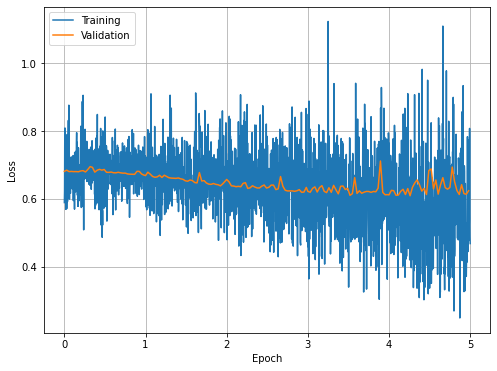

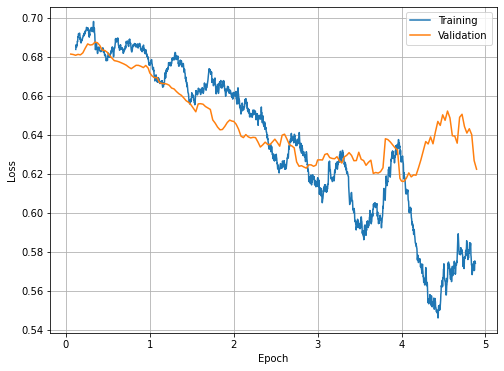

In [ ]:
# Messy code to extract information from the dumped .txt files
# Could be significantly improved + streamlined

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

with open("{}/train_loss.txt".format(dir_name)) as f:
    contents = f.readlines()

train_loss = [i.split(' ')[-2].split(':')[-1] for i in contents]
train_loss = [float(i.split(',')[0]) for i in train_loss]

train_step = [int(i.split(' ')[1].split(':')[-1]) for i in contents]
train_epoch = [int(i.split(' ')[0].split(':')[-1]) for i in contents]

train_total_step = []

steps_per_epoch = max(train_step)
for i in range(len(train_step)):
    train_total_step.append(steps_per_epoch*train_epoch[i]+train_step[i])



with open("{}/val_loss.txt".format(dir_name)) as f:
    contents = f.readlines()

val_loss = [i.split(' ')[-2].split(':')[-1] for i in contents]
val_loss = [float(i.split(',')[0]) for i in val_loss]

val_step = [int(i.split(' ')[1].split(':')[-1]) for i in contents]
val_epoch = [int(i.split(' ')[0].split(':')[-1]) for i in contents]

val_total_step = []

for i in range(len(val_step)):
    val_total_step.append(steps_per_epoch*val_epoch[i]+val_step[i])


train_epochs = np.array(train_total_step)/steps_per_epoch
val_epochs = np.array(val_total_step)/steps_per_epoch


plt.figure(figsize=(8,6))
plt.plot(train_epochs,train_loss, label='Training')
plt.plot(val_epochs, val_loss, label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


train_epochs = np.array(train_total_step[49:-50])/steps_per_epoch
val_epochs = np.array(val_total_step[2:-3])/steps_per_epoch

plt.figure(figsize=(8,6))
plt.plot(train_epochs, moving_average(train_loss,100), label='Training')
plt.plot(val_epochs, moving_average(val_loss,6), label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()




### Model performance and confusion matrix

In [ ]:
# Loading finetuned model
run_name = "Final_lr=5e-6"
model_name = 'codebert-base'
dir_name = 'codebert_finetune_runs/{}'.format(run_name)
model = AutoModelForSequenceClassification.from_pretrained("codebert_finetune_runs/Final_lr=5e-6/epoch_5").to(device)

test_acc = []
test_loss_total = 0
(X_train, A_train, Y_train), (X_val, A_val, Y_val), (X_test, A_test, Y_test) = split_loader(dir_name)

pred_list = []
truth_list = []

for test_badtch_id, j in tqdm(enumerate(range(0, X_test.shape[0]))):
                    # Loading singular validation data (overwrites train data as can only load 1 intp GPU)
                    batch_X, batch_Y, batch_A = X_test[j:j+1].to(device), Y_test[j:j+1].to(device), A_test[j:j+1].to(device)

                    with torch.no_grad():
                        test_outputs = model(batch_X, labels=batch_Y, attention_mask=batch_A)
                    test_loss_total += float(test_outputs['loss'].item())

                    
                    test_clsf = nn.Softmax(dim=1)(test_outputs.logits)

                    pred_list.append(test_clsf.argmax(axis=1).cpu()[0].item())
                    truth_list.append(batch_Y.cpu()[0].item())

                    test_acc.append(np.average(torch.eq(batch_Y.cpu(), test_clsf.argmax(axis=1).cpu())))

test_loss_total /= (j+1)
test_acc = np.average(test_acc)

from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(truth_list, pred_list).ravel()

print("\n\nConfusion Matrix:")
print("TP: {}, FP:{}\nFN:{}, TN:{}".format(tp, fp, fn, tn))
print("\nAccuracy {:.4f}".format(test_acc))
print("Precision: {:.4f}".format(tp/(tp+fp)))
print("Recall: {:.4f}".format(tp/(tp+fn)))


417it [00:09, 44.52it/s]



Confusion Matrix:
TP: 47, FP:6
FN:155, TN:209

Accuracy 0.6139
Precision: 0.8868
Recall: 0.2327


## Modified BERT architechture with additional FNN layers

Bellow there are experiments with a modified BERT architechture, this has not been cleaned as the results were worse than above. For similar reasons it was not included within the report

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(512,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      cls_hs = self.bert(sent_id, attention_mask=mask)

      x = self.fc1(cls_hs.logits)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
"""
Main configuration function for a given finetune run
:return: None
"""
run_name = "lr_5e-5 redo, 512 split Full unfreeze"
run_dir = "codebert_finetune_runs/{}".format(run_name)
model_name = 'codebert-base'
checkpoint_location = None
online = False
load_splits = False
save_data = True

print("generating data splits")

code_df = preprocess_data(file_loc='code_dataset.jsonl')
train_data, val_data, test_data = tokenize(code_df, model_name=model_name)

X_train, A_train, Y_train = train_data
X_val, A_val, Y_val = val_data
X_test, A_test, Y_test = test_data

data_type = ['train', 'val', 'test']
data_split_type = ['X', 'A', 'Y']


# Creating dir to save logs and checkpoints, re
dir_name = "{}".format(run_dir)
if os.path.exists(dir_name):
  input("run name already exists, press Enter to overwrite")
else:
  os.makedirs(dir_name)

if save_data:
  print("saving data splits")

  data_all = [train_data, val_data, test_data]
  for i, data in enumerate(data_all):
    for j, split in enumerate(data):
      with open('{}/{}_{}.pickle'.format(run_dir,data_type[i], data_split_type[j]), 'wb') as handle:
        pickle.dump(split, handle)

# Loading model from checkpoint if location provided
if online:
  print("loading model from online")
  model = AutoModelForSequenceClassification.from_pretrained("microsoft/codebert-base")
elif checkpoint_location is None:
  print("loading model from local repo")

  model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=512)
else:
  print("loading model from checkpoint: {}".format(checkpoint_location))
  model = AutoModelForSequenceClassification.from_pretrained(checkpoint_location)

generating data splits
Insecure code counts: 3729, Total code counts: 8000, Proportion 0.466125
Data points: 8000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


saving data splits
loading model from local repo


Some weights of the model checkpoint at codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at codebert-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for p

In [ ]:
# freeze all the parameters
for param in model.parameters():
    param.requires_grad = False


In [ ]:
custom_model = BERT_Arch(model)

In [ ]:
custom_model = custom_model.to(device)

In [ ]:

def train_custom(model, train_data, val_data, epochs=5, batch_size=16, learning_rate=2e-5, validate_per=500,
          run_name="temp", run_descrption=None):
    """
    Main fine-tuning training loop for the provided model

    :param model: model loaded with predefined weights
    :param train_data: tuple of X_train, A_train, Y_train (X = inputs, A = attention, Y = target)
    :param val_data: tuple X_val, A_val, Y_val
    :param epochs: number of epochs for training
    :param batch_size: batch size (see note below about batch_hack)
    :param learning_rate: optimizer learning rate
    :param validate_per: number of weight updates before validation occurs
                            (notes: - if batch_size = 32, and validate_per = 32, validation will occur every batch
                                    - this is wrt the start of each epoch
                                    - validation will always occour at the start of each epoch (step 0))
    :param run_name: name used to saving checkpoints and log files within codebert_finetune_runs
    :param run_descrption: string that is saved to info.txt describing the run


    :return: None (models are saved in checkpoints along with log data)
    """


    # Saving run description.txt
    if run_descrption is not None:
        with open("{}/info.txt".format(dir_name), "a+") as f:
            f.write(run_descrption)

    # Unpacking data
    X_train, A_train, Y_train = train_data
    X_val, A_val, Y_val = val_data


    batch_hack = batch_size  # See note below regarding limited GPU memory

    # Initializing arrays for tracking loss
    train_loss_hist = []
    val_loss_hist = []
    train_pred_hist = []
    # Counter to track batches (see note below related to GPU memory)
    batch_count = 0
    # validate_per_batch = int(validate_per/batch_hack)

    # Moving model to GPU if configured
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    validate_per = int(validate_per/batch_size)

    cross_entropy  = nn.NLLLoss() 
    for epoch in range(epochs):

        # Generating random index for manual shuffling of data each epoch as note using DataLoaders
        permutation = torch.randperm(X_train.shape[0])

        # Note here that only a single element is loaded at each iteration (batch size = 1) due to GPU memory constraint
        for batch_id, i in enumerate(range(0, X_train.shape[0], batch_hack)):

            # Loading batch and moving to device
            indices = permutation[i:i + batch_hack]
            batch_X, batch_Y, batch_A = X_train[indices].to(device), Y_train[indices].to(device), A_train[indices].to(device)


            batch_Y_one_hot = torch.nn.functional.one_hot(batch_Y, num_classes= 2)

            model.train()

            # Forward pass
            #outputs = model(batch_X,labels=batch_Y, attention_mask=batch_A)
            outputs = model(batch_X, batch_A)

            #loss = criterion(loss_clsf.float(), batch_Y_one_hot.float())
            #loss = outputs.loss

            loss = cross_entropy(outputs, batch_Y)


            # Clip params
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)


            # Backward pass
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_clsf = nn.Softmax(dim=1)(outputs)
            acc = np.average(torch.eq(batch_Y.cpu(), loss_clsf.argmax(axis=1).cpu()))
            #rint(correct)

            # Tracking loss
            train_loss_hist.append(float(loss.item()))
            train_pred_hist.append(acc)

            # Training output
            train_output = "Epoch:{} Step:{} Training_loss:{:.6f}, Acc_avg:{:.2f}%".format(epoch, i, loss.item(), np.sum(100*train_pred_hist[-50:])/min(len(train_pred_hist), 50))
            print(train_output+" Training_loss_avg:{:.6f}".format(np.average(train_loss_hist[-50:])))
            with open("{}/train_loss.txt".format(dir_name), "a+") as f:
                f.write(train_output+"\n")

            # Validation
            if batch_id % validate_per == 0:
                val_loss_total = 0
                model.eval()
                print("Validating:")
                val_acc = []
                for val_badtch_id, j in tqdm(enumerate(range(0, X_val.shape[0], batch_hack))):
                    # Loading singular validation data (overwrites train data as can only load 1 intp GPU)
                    batch_X, batch_Y, batch_A = X_val[j:j+batch_hack].to(device), Y_val[j:j+batch_hack].to(device), A_val[j:j+batch_hack].to(device)

                    with torch.no_grad():
                        outputs = model(batch_X, batch_A)

                    val_loss = cross_entropy(outputs, batch_Y)
                    val_loss_total += float(val_loss)

                    
                    val_clsf = nn.Softmax(dim=1)(outputs)
                    val_acc.append(np.average(torch.eq(batch_Y.cpu(), val_clsf.argmax(axis=1).cpu())))

                    del batch_X
                    del batch_Y

                # Adding average loss to tracker
                val_average = val_loss_total / (val_badtch_id+1)
                val_loss_hist.append(val_average)

                # Validation output and logging
                val_output = "Epoch:{} Step:{} Val_loss:{:.6f}, Val_Acc_avg:{:.2f}%".format(epoch, i, val_average, np.sum(100*val_acc[-50:])/min(len(val_acc), 50))
                print(val_output)
                with open("{}/val_los.txt".format(dir_name), "a+") as f:
                    f.write(val_output+"\n")

        # End of epoch checkpoint
        #model.save_pretrained("{}/epoch_{}".format(dir_name, epoch + 1))
        torch.save(model, "{}/epoch_{}".format(dir_name, epoch + 1))


In [ ]:
train_custom(model=custom_model,
      train_data=train_data,
      val_data=val_data,
      epochs=10,
      batch_size=8,
      learning_rate=5e-5,
      validate_per=250,
      run_name=run_name,
      run_descrption="lr_5e-5 redo")

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:0 Step:0 Training_loss:0.690187, Acc_avg:62.50% Training_loss_avg:0.690187
Validating:


52it [00:07,  6.60it/s]


Epoch:0 Step:0 Val_loss:0.694344, Val_Acc_avg:45.25%
Epoch:0 Step:8 Training_loss:0.680802, Acc_avg:56.25% Training_loss_avg:0.685494
Epoch:0 Step:16 Training_loss:0.673006, Acc_avg:58.33% Training_loss_avg:0.681332
Epoch:0 Step:24 Training_loss:0.697169, Acc_avg:56.25% Training_loss_avg:0.685291
Epoch:0 Step:32 Training_loss:0.741785, Acc_avg:50.00% Training_loss_avg:0.696590
Epoch:0 Step:40 Training_loss:0.683279, Acc_avg:52.08% Training_loss_avg:0.694371
Epoch:0 Step:48 Training_loss:0.709840, Acc_avg:51.79% Training_loss_avg:0.696581
Epoch:0 Step:56 Training_loss:0.716756, Acc_avg:50.00% Training_loss_avg:0.699103
Epoch:0 Step:64 Training_loss:0.698136, Acc_avg:48.61% Training_loss_avg:0.698996
Epoch:0 Step:72 Training_loss:0.681654, Acc_avg:51.25% Training_loss_avg:0.697261
Epoch:0 Step:80 Training_loss:0.666886, Acc_avg:52.27% Training_loss_avg:0.694500
Epoch:0 Step:88 Training_loss:0.753497, Acc_avg:50.00% Training_loss_avg:0.699416
Epoch:0 Step:96 Training_loss:0.744714, Acc_av

52it [00:07,  6.60it/s]


Epoch:0 Step:248 Val_loss:0.690676, Val_Acc_avg:54.75%
Epoch:0 Step:256 Training_loss:0.666537, Acc_avg:51.52% Training_loss_avg:0.697540
Epoch:0 Step:264 Training_loss:0.680447, Acc_avg:51.84% Training_loss_avg:0.697037
Epoch:0 Step:272 Training_loss:0.720582, Acc_avg:51.07% Training_loss_avg:0.697710
Epoch:0 Step:280 Training_loss:0.702439, Acc_avg:50.69% Training_loss_avg:0.697841
Epoch:0 Step:288 Training_loss:0.675730, Acc_avg:51.35% Training_loss_avg:0.697243
Epoch:0 Step:296 Training_loss:0.689450, Acc_avg:50.99% Training_loss_avg:0.697038
Epoch:0 Step:304 Training_loss:0.664400, Acc_avg:51.60% Training_loss_avg:0.696201
Epoch:0 Step:312 Training_loss:0.696716, Acc_avg:51.56% Training_loss_avg:0.696214
Epoch:0 Step:320 Training_loss:0.642353, Acc_avg:52.13% Training_loss_avg:0.694901
Epoch:0 Step:328 Training_loss:0.637699, Acc_avg:52.98% Training_loss_avg:0.693539
Epoch:0 Step:336 Training_loss:0.654247, Acc_avg:53.20% Training_loss_avg:0.692625
Epoch:0 Step:344 Training_loss:0

52it [00:07,  6.60it/s]


Epoch:0 Step:496 Val_loss:0.689451, Val_Acc_avg:54.75%
Epoch:0 Step:504 Training_loss:0.728552, Acc_avg:54.00% Training_loss_avg:0.694002
Epoch:0 Step:512 Training_loss:0.655941, Acc_avg:54.50% Training_loss_avg:0.693297
Epoch:0 Step:520 Training_loss:0.705081, Acc_avg:54.00% Training_loss_avg:0.694492
Epoch:0 Step:528 Training_loss:0.673421, Acc_avg:54.25% Training_loss_avg:0.694107
Epoch:0 Step:536 Training_loss:0.738257, Acc_avg:53.50% Training_loss_avg:0.695071
Epoch:0 Step:544 Training_loss:0.687615, Acc_avg:54.25% Training_loss_avg:0.693619
Epoch:0 Step:552 Training_loss:0.706785, Acc_avg:53.75% Training_loss_avg:0.694518
Epoch:0 Step:560 Training_loss:0.722193, Acc_avg:52.75% Training_loss_avg:0.695722
Epoch:0 Step:568 Training_loss:0.713471, Acc_avg:52.75% Training_loss_avg:0.695474
Epoch:0 Step:576 Training_loss:0.694515, Acc_avg:53.25% Training_loss_avg:0.694708
Epoch:0 Step:584 Training_loss:0.709620, Acc_avg:52.75% Training_loss_avg:0.695134
Epoch:0 Step:592 Training_loss:0

52it [00:07,  6.57it/s]


Epoch:0 Step:744 Val_loss:0.690865, Val_Acc_avg:54.75%
Epoch:0 Step:752 Training_loss:0.691318, Acc_avg:49.25% Training_loss_avg:0.700681
Epoch:0 Step:760 Training_loss:0.710777, Acc_avg:49.00% Training_loss_avg:0.699911
Epoch:0 Step:768 Training_loss:0.701909, Acc_avg:48.00% Training_loss_avg:0.702261
Epoch:0 Step:776 Training_loss:0.656889, Acc_avg:48.50% Training_loss_avg:0.701096
Epoch:0 Step:784 Training_loss:0.669000, Acc_avg:48.75% Training_loss_avg:0.700148
Epoch:0 Step:792 Training_loss:0.702417, Acc_avg:49.25% Training_loss_avg:0.696433
Epoch:0 Step:800 Training_loss:0.694154, Acc_avg:49.25% Training_loss_avg:0.695942
Epoch:0 Step:808 Training_loss:0.722732, Acc_avg:49.25% Training_loss_avg:0.696782
Epoch:0 Step:816 Training_loss:0.679268, Acc_avg:48.50% Training_loss_avg:0.697213
Epoch:0 Step:824 Training_loss:0.688930, Acc_avg:49.00% Training_loss_avg:0.695760
Epoch:0 Step:832 Training_loss:0.697173, Acc_avg:48.75% Training_loss_avg:0.696368
Epoch:0 Step:840 Training_loss:0

52it [00:07,  6.59it/s]


Epoch:0 Step:992 Val_loss:0.693227, Val_Acc_avg:51.25%
Epoch:0 Step:1000 Training_loss:0.714614, Acc_avg:49.00% Training_loss_avg:0.696266
Epoch:0 Step:1008 Training_loss:0.706624, Acc_avg:49.25% Training_loss_avg:0.696303
Epoch:0 Step:1016 Training_loss:0.692806, Acc_avg:49.75% Training_loss_avg:0.695681
Epoch:0 Step:1024 Training_loss:0.696425, Acc_avg:49.75% Training_loss_avg:0.695684
Epoch:0 Step:1032 Training_loss:0.700209, Acc_avg:49.50% Training_loss_avg:0.695926
Epoch:0 Step:1040 Training_loss:0.683811, Acc_avg:49.50% Training_loss_avg:0.696085
Epoch:0 Step:1048 Training_loss:0.690085, Acc_avg:49.25% Training_loss_avg:0.696098
Epoch:0 Step:1056 Training_loss:0.697493, Acc_avg:50.00% Training_loss_avg:0.695386
Epoch:0 Step:1064 Training_loss:0.682435, Acc_avg:50.25% Training_loss_avg:0.695141
Epoch:0 Step:1072 Training_loss:0.665634, Acc_avg:51.00% Training_loss_avg:0.694422
Epoch:0 Step:1080 Training_loss:0.703195, Acc_avg:50.50% Training_loss_avg:0.694705
Epoch:0 Step:1088 Tra

52it [00:07,  6.60it/s]


Epoch:0 Step:1240 Val_loss:0.689155, Val_Acc_avg:54.75%
Epoch:0 Step:1248 Training_loss:0.717662, Acc_avg:50.25% Training_loss_avg:0.699230
Epoch:0 Step:1256 Training_loss:0.687631, Acc_avg:49.75% Training_loss_avg:0.699866
Epoch:0 Step:1264 Training_loss:0.640316, Acc_avg:50.25% Training_loss_avg:0.698658
Epoch:0 Step:1272 Training_loss:0.731873, Acc_avg:50.50% Training_loss_avg:0.698616
Epoch:0 Step:1280 Training_loss:0.667151, Acc_avg:51.50% Training_loss_avg:0.697050
Epoch:0 Step:1288 Training_loss:0.706316, Acc_avg:52.00% Training_loss_avg:0.696493
Epoch:0 Step:1296 Training_loss:0.756635, Acc_avg:51.25% Training_loss_avg:0.697507
Epoch:0 Step:1304 Training_loss:0.712083, Acc_avg:51.00% Training_loss_avg:0.698101
Epoch:0 Step:1312 Training_loss:0.611016, Acc_avg:51.75% Training_loss_avg:0.696513
Epoch:0 Step:1320 Training_loss:0.704283, Acc_avg:51.75% Training_loss_avg:0.696824
Epoch:0 Step:1328 Training_loss:0.686676, Acc_avg:52.00% Training_loss_avg:0.696595
Epoch:0 Step:1336 Tr

52it [00:07,  6.60it/s]


Epoch:0 Step:1488 Val_loss:0.692784, Val_Acc_avg:55.00%
Epoch:0 Step:1496 Training_loss:0.713372, Acc_avg:52.25% Training_loss_avg:0.696876
Epoch:0 Step:1504 Training_loss:0.680884, Acc_avg:52.25% Training_loss_avg:0.697455
Epoch:0 Step:1512 Training_loss:0.702530, Acc_avg:51.50% Training_loss_avg:0.698894
Epoch:0 Step:1520 Training_loss:0.686602, Acc_avg:51.00% Training_loss_avg:0.699634
Epoch:0 Step:1528 Training_loss:0.697565, Acc_avg:50.25% Training_loss_avg:0.700742
Epoch:0 Step:1536 Training_loss:0.711924, Acc_avg:50.00% Training_loss_avg:0.700555
Epoch:0 Step:1544 Training_loss:0.696498, Acc_avg:49.75% Training_loss_avg:0.701701
Epoch:0 Step:1552 Training_loss:0.700407, Acc_avg:49.00% Training_loss_avg:0.703565
Epoch:0 Step:1560 Training_loss:0.675557, Acc_avg:49.75% Training_loss_avg:0.701676
Epoch:0 Step:1568 Training_loss:0.692506, Acc_avg:49.50% Training_loss_avg:0.702125
Epoch:0 Step:1576 Training_loss:0.683433, Acc_avg:49.75% Training_loss_avg:0.702229
Epoch:0 Step:1584 Tr

52it [00:07,  6.60it/s]


Epoch:0 Step:1736 Val_loss:0.689789, Val_Acc_avg:54.75%
Epoch:0 Step:1744 Training_loss:0.667858, Acc_avg:53.50% Training_loss_avg:0.690578
Epoch:0 Step:1752 Training_loss:0.670912, Acc_avg:54.00% Training_loss_avg:0.689471
Epoch:0 Step:1760 Training_loss:0.722182, Acc_avg:53.25% Training_loss_avg:0.690200
Epoch:0 Step:1768 Training_loss:0.657721, Acc_avg:52.75% Training_loss_avg:0.690606
Epoch:0 Step:1776 Training_loss:0.740686, Acc_avg:52.50% Training_loss_avg:0.691483
Epoch:0 Step:1784 Training_loss:0.657467, Acc_avg:52.75% Training_loss_avg:0.690707
Epoch:0 Step:1792 Training_loss:0.614626, Acc_avg:53.25% Training_loss_avg:0.689412
Epoch:0 Step:1800 Training_loss:0.562730, Acc_avg:54.50% Training_loss_avg:0.686443
Epoch:0 Step:1808 Training_loss:0.707965, Acc_avg:54.50% Training_loss_avg:0.687202
Epoch:0 Step:1816 Training_loss:0.676999, Acc_avg:54.75% Training_loss_avg:0.687215
Epoch:0 Step:1824 Training_loss:0.571864, Acc_avg:55.50% Training_loss_avg:0.684753
Epoch:0 Step:1832 Tr

52it [00:07,  6.60it/s]


Epoch:0 Step:1984 Val_loss:0.690180, Val_Acc_avg:54.75%
Epoch:0 Step:1992 Training_loss:0.733718, Acc_avg:57.75% Training_loss_avg:0.686699
Epoch:0 Step:2000 Training_loss:0.660284, Acc_avg:57.75% Training_loss_avg:0.686721
Epoch:0 Step:2008 Training_loss:0.690024, Acc_avg:57.25% Training_loss_avg:0.687548
Epoch:0 Step:2016 Training_loss:0.697006, Acc_avg:57.75% Training_loss_avg:0.686774
Epoch:0 Step:2024 Training_loss:0.662936, Acc_avg:57.75% Training_loss_avg:0.686501
Epoch:0 Step:2032 Training_loss:0.640414, Acc_avg:58.25% Training_loss_avg:0.685565
Epoch:0 Step:2040 Training_loss:0.675602, Acc_avg:58.50% Training_loss_avg:0.685020
Epoch:0 Step:2048 Training_loss:0.668633, Acc_avg:58.75% Training_loss_avg:0.684455
Epoch:0 Step:2056 Training_loss:0.674682, Acc_avg:59.00% Training_loss_avg:0.684673
Epoch:0 Step:2064 Training_loss:0.676014, Acc_avg:59.25% Training_loss_avg:0.684083
Epoch:0 Step:2072 Training_loss:0.729344, Acc_avg:58.75% Training_loss_avg:0.685449
Epoch:0 Step:2080 Tr

52it [00:07,  6.60it/s]


Epoch:0 Step:2232 Val_loss:0.692831, Val_Acc_avg:54.75%
Epoch:0 Step:2240 Training_loss:0.624778, Acc_avg:58.00% Training_loss_avg:0.687993
Epoch:0 Step:2248 Training_loss:0.676481, Acc_avg:58.00% Training_loss_avg:0.686630
Epoch:0 Step:2256 Training_loss:0.694115, Acc_avg:58.50% Training_loss_avg:0.685720
Epoch:0 Step:2264 Training_loss:0.706340, Acc_avg:58.25% Training_loss_avg:0.685429
Epoch:0 Step:2272 Training_loss:0.685847, Acc_avg:58.00% Training_loss_avg:0.686083
Epoch:0 Step:2280 Training_loss:0.790069, Acc_avg:57.50% Training_loss_avg:0.687792
Epoch:0 Step:2288 Training_loss:0.591203, Acc_avg:57.50% Training_loss_avg:0.688692
Epoch:0 Step:2296 Training_loss:0.672169, Acc_avg:58.00% Training_loss_avg:0.686476
Epoch:0 Step:2304 Training_loss:0.657899, Acc_avg:58.25% Training_loss_avg:0.684225
Epoch:0 Step:2312 Training_loss:0.747400, Acc_avg:57.75% Training_loss_avg:0.686037
Epoch:0 Step:2320 Training_loss:0.619553, Acc_avg:58.00% Training_loss_avg:0.684235
Epoch:0 Step:2328 Tr

52it [00:07,  6.60it/s]


Epoch:0 Step:2480 Val_loss:0.689398, Val_Acc_avg:54.75%
Epoch:0 Step:2488 Training_loss:0.672953, Acc_avg:56.75% Training_loss_avg:0.686796
Epoch:0 Step:2496 Training_loss:0.732289, Acc_avg:56.75% Training_loss_avg:0.686730
Epoch:0 Step:2504 Training_loss:0.661141, Acc_avg:56.50% Training_loss_avg:0.687250
Epoch:0 Step:2512 Training_loss:0.701096, Acc_avg:56.25% Training_loss_avg:0.687745
Epoch:0 Step:2520 Training_loss:0.713584, Acc_avg:55.50% Training_loss_avg:0.690189
Epoch:0 Step:2528 Training_loss:0.716832, Acc_avg:55.25% Training_loss_avg:0.690400
Epoch:0 Step:2536 Training_loss:0.660574, Acc_avg:55.25% Training_loss_avg:0.690998
Epoch:0 Step:2544 Training_loss:0.657001, Acc_avg:55.75% Training_loss_avg:0.690541
Epoch:0 Step:2552 Training_loss:0.656324, Acc_avg:57.00% Training_loss_avg:0.686962
Epoch:0 Step:2560 Training_loss:0.717269, Acc_avg:57.00% Training_loss_avg:0.686944
Epoch:0 Step:2568 Training_loss:0.688413, Acc_avg:56.75% Training_loss_avg:0.688349
Epoch:0 Step:2576 Tr

52it [00:07,  6.60it/s]


Epoch:0 Step:2728 Val_loss:0.702151, Val_Acc_avg:54.75%
Epoch:0 Step:2736 Training_loss:0.655666, Acc_avg:57.25% Training_loss_avg:0.684113
Epoch:0 Step:2744 Training_loss:0.600003, Acc_avg:57.75% Training_loss_avg:0.682026
Epoch:0 Step:2752 Training_loss:0.790610, Acc_avg:57.25% Training_loss_avg:0.684299
Epoch:0 Step:2760 Training_loss:0.716397, Acc_avg:57.50% Training_loss_avg:0.683809
Epoch:0 Step:2768 Training_loss:0.599597, Acc_avg:57.75% Training_loss_avg:0.682447
Epoch:0 Step:2776 Training_loss:0.721443, Acc_avg:57.75% Training_loss_avg:0.683059
Epoch:0 Step:2784 Training_loss:0.589316, Acc_avg:58.50% Training_loss_avg:0.679897
Epoch:0 Step:2792 Training_loss:0.603580, Acc_avg:59.00% Training_loss_avg:0.678334
Epoch:0 Step:2800 Training_loss:0.774922, Acc_avg:58.75% Training_loss_avg:0.679157
Epoch:0 Step:2808 Training_loss:0.555429, Acc_avg:59.25% Training_loss_avg:0.676963
Epoch:0 Step:2816 Training_loss:0.694086, Acc_avg:59.00% Training_loss_avg:0.677394
Epoch:0 Step:2824 Tr

52it [00:07,  6.59it/s]


Epoch:0 Step:2976 Val_loss:0.689770, Val_Acc_avg:54.75%
Epoch:0 Step:2984 Training_loss:0.668998, Acc_avg:56.75% Training_loss_avg:0.683509
Epoch:0 Step:2992 Training_loss:0.694852, Acc_avg:56.50% Training_loss_avg:0.683729
Epoch:0 Step:3000 Training_loss:0.697067, Acc_avg:56.25% Training_loss_avg:0.683821
Epoch:0 Step:3008 Training_loss:0.691123, Acc_avg:55.75% Training_loss_avg:0.685343
Epoch:0 Step:3016 Training_loss:0.676391, Acc_avg:56.25% Training_loss_avg:0.684829
Epoch:0 Step:3024 Training_loss:0.685539, Acc_avg:56.75% Training_loss_avg:0.683713
Epoch:0 Step:3032 Training_loss:0.692612, Acc_avg:56.00% Training_loss_avg:0.685150
Epoch:0 Step:3040 Training_loss:0.717217, Acc_avg:55.00% Training_loss_avg:0.686690
Epoch:0 Step:3048 Training_loss:0.694569, Acc_avg:54.75% Training_loss_avg:0.687241
Epoch:0 Step:3056 Training_loss:0.701690, Acc_avg:54.00% Training_loss_avg:0.688464
Epoch:0 Step:3064 Training_loss:0.670736, Acc_avg:54.25% Training_loss_avg:0.689705
Epoch:0 Step:3072 Tr

52it [00:07,  6.60it/s]


Epoch:0 Step:3224 Val_loss:0.689523, Val_Acc_avg:54.75%
Epoch:0 Step:3232 Training_loss:0.696144, Acc_avg:53.75% Training_loss_avg:0.695248
Epoch:0 Step:3240 Training_loss:0.654708, Acc_avg:54.00% Training_loss_avg:0.695027
Epoch:0 Step:3248 Training_loss:0.636326, Acc_avg:54.25% Training_loss_avg:0.695509
Epoch:0 Step:3256 Training_loss:0.678839, Acc_avg:55.00% Training_loss_avg:0.692645
Epoch:0 Step:3264 Training_loss:0.661039, Acc_avg:55.50% Training_loss_avg:0.691662
Epoch:0 Step:3272 Training_loss:0.674975, Acc_avg:55.25% Training_loss_avg:0.693153
Epoch:0 Step:3280 Training_loss:0.667766, Acc_avg:55.50% Training_loss_avg:0.692035
Epoch:0 Step:3288 Training_loss:0.807302, Acc_avg:55.00% Training_loss_avg:0.693960
Epoch:0 Step:3296 Training_loss:0.626782, Acc_avg:55.75% Training_loss_avg:0.692835
Epoch:0 Step:3304 Training_loss:0.668977, Acc_avg:56.25% Training_loss_avg:0.691031
Epoch:0 Step:3312 Training_loss:0.739475, Acc_avg:56.25% Training_loss_avg:0.690834
Epoch:0 Step:3320 Tr

52it [00:07,  6.60it/s]


Epoch:1 Step:0 Val_loss:0.690072, Val_Acc_avg:54.75%
Epoch:1 Step:8 Training_loss:0.682009, Acc_avg:56.33% Training_loss_avg:0.689772
Epoch:1 Step:16 Training_loss:0.680851, Acc_avg:56.58% Training_loss_avg:0.688776
Epoch:1 Step:24 Training_loss:0.689244, Acc_avg:56.58% Training_loss_avg:0.688626
Epoch:1 Step:32 Training_loss:0.724989, Acc_avg:56.08% Training_loss_avg:0.689670
Epoch:1 Step:40 Training_loss:0.703208, Acc_avg:55.83% Training_loss_avg:0.690221
Epoch:1 Step:48 Training_loss:0.798657, Acc_avg:54.83% Training_loss_avg:0.692814
Epoch:1 Step:56 Training_loss:0.652369, Acc_avg:55.33% Training_loss_avg:0.691964
Epoch:1 Step:64 Training_loss:0.680933, Acc_avg:55.58% Training_loss_avg:0.691642
Epoch:1 Step:72 Training_loss:0.721750, Acc_avg:55.08% Training_loss_avg:0.692254
Epoch:1 Step:80 Training_loss:0.682205, Acc_avg:55.08% Training_loss_avg:0.692371
Epoch:1 Step:88 Training_loss:0.617236, Acc_avg:55.83% Training_loss_avg:0.691005
Epoch:1 Step:96 Training_loss:0.686916, Acc_av

52it [00:07,  6.59it/s]


Epoch:1 Step:248 Val_loss:0.689412, Val_Acc_avg:54.75%
Epoch:1 Step:256 Training_loss:0.691442, Acc_avg:55.83% Training_loss_avg:0.691030
Epoch:1 Step:264 Training_loss:0.733696, Acc_avg:55.33% Training_loss_avg:0.692095
Epoch:1 Step:272 Training_loss:0.706248, Acc_avg:54.58% Training_loss_avg:0.692968
Epoch:1 Step:280 Training_loss:0.728563, Acc_avg:54.33% Training_loss_avg:0.693245
Epoch:1 Step:288 Training_loss:0.685498, Acc_avg:54.58% Training_loss_avg:0.692830
Epoch:1 Step:296 Training_loss:0.718774, Acc_avg:54.08% Training_loss_avg:0.693283
Epoch:1 Step:304 Training_loss:0.687873, Acc_avg:53.58% Training_loss_avg:0.693946
Epoch:1 Step:312 Training_loss:0.691298, Acc_avg:52.83% Training_loss_avg:0.695045
Epoch:1 Step:320 Training_loss:0.691454, Acc_avg:52.83% Training_loss_avg:0.695298
Epoch:1 Step:328 Training_loss:0.723955, Acc_avg:52.08% Training_loss_avg:0.696556
Epoch:1 Step:336 Training_loss:0.731609, Acc_avg:51.08% Training_loss_avg:0.697689
Epoch:1 Step:344 Training_loss:0

52it [00:07,  6.60it/s]


Epoch:1 Step:496 Val_loss:0.691591, Val_Acc_avg:54.75%
Epoch:1 Step:504 Training_loss:0.696092, Acc_avg:49.25% Training_loss_avg:0.697577
Epoch:1 Step:512 Training_loss:0.674716, Acc_avg:49.75% Training_loss_avg:0.697466
Epoch:1 Step:520 Training_loss:0.700106, Acc_avg:50.00% Training_loss_avg:0.697013
Epoch:1 Step:528 Training_loss:0.686539, Acc_avg:50.25% Training_loss_avg:0.696394
Epoch:1 Step:536 Training_loss:0.701227, Acc_avg:50.25% Training_loss_avg:0.696088
Epoch:1 Step:544 Training_loss:0.691290, Acc_avg:50.25% Training_loss_avg:0.696291
Epoch:1 Step:552 Training_loss:0.696896, Acc_avg:49.75% Training_loss_avg:0.696658
Epoch:1 Step:560 Training_loss:0.690051, Acc_avg:49.75% Training_loss_avg:0.696584
Epoch:1 Step:568 Training_loss:0.692537, Acc_avg:49.75% Training_loss_avg:0.696623
Epoch:1 Step:576 Training_loss:0.679122, Acc_avg:50.00% Training_loss_avg:0.696271
Epoch:1 Step:584 Training_loss:0.690608, Acc_avg:50.25% Training_loss_avg:0.694812
Epoch:1 Step:592 Training_loss:0

52it [00:07,  6.60it/s]


Epoch:1 Step:744 Val_loss:0.693428, Val_Acc_avg:54.75%
Epoch:1 Step:752 Training_loss:0.653056, Acc_avg:53.25% Training_loss_avg:0.690945
Epoch:1 Step:760 Training_loss:0.628677, Acc_avg:54.25% Training_loss_avg:0.689404
Epoch:1 Step:768 Training_loss:0.763015, Acc_avg:54.25% Training_loss_avg:0.690830
Epoch:1 Step:776 Training_loss:0.598144, Acc_avg:55.00% Training_loss_avg:0.688732
Epoch:1 Step:784 Training_loss:0.727583, Acc_avg:54.50% Training_loss_avg:0.689611
Epoch:1 Step:792 Training_loss:0.707133, Acc_avg:54.50% Training_loss_avg:0.689811
Epoch:1 Step:800 Training_loss:0.729049, Acc_avg:54.50% Training_loss_avg:0.690631
Epoch:1 Step:808 Training_loss:0.636508, Acc_avg:54.75% Training_loss_avg:0.689612
Epoch:1 Step:816 Training_loss:0.757233, Acc_avg:54.50% Training_loss_avg:0.690629
Epoch:1 Step:824 Training_loss:0.582089, Acc_avg:55.25% Training_loss_avg:0.688327
Epoch:1 Step:832 Training_loss:0.632143, Acc_avg:56.00% Training_loss_avg:0.687065
Epoch:1 Step:840 Training_loss:0

52it [00:07,  6.60it/s]


Epoch:1 Step:992 Val_loss:0.689733, Val_Acc_avg:54.75%
Epoch:1 Step:1000 Training_loss:0.717705, Acc_avg:57.25% Training_loss_avg:0.688727
Epoch:1 Step:1008 Training_loss:0.715496, Acc_avg:57.25% Training_loss_avg:0.689045
Epoch:1 Step:1016 Training_loss:0.652318, Acc_avg:57.25% Training_loss_avg:0.688654
Epoch:1 Step:1024 Training_loss:0.729212, Acc_avg:56.75% Training_loss_avg:0.689458
Epoch:1 Step:1032 Training_loss:0.680759, Acc_avg:56.50% Training_loss_avg:0.689699
Epoch:1 Step:1040 Training_loss:0.684820, Acc_avg:56.25% Training_loss_avg:0.690237
Epoch:1 Step:1048 Training_loss:0.738624, Acc_avg:55.50% Training_loss_avg:0.691758
Epoch:1 Step:1056 Training_loss:0.655438, Acc_avg:55.50% Training_loss_avg:0.691427
Epoch:1 Step:1064 Training_loss:0.711086, Acc_avg:55.00% Training_loss_avg:0.692671
Epoch:1 Step:1072 Training_loss:0.674698, Acc_avg:55.25% Training_loss_avg:0.692468
Epoch:1 Step:1080 Training_loss:0.700764, Acc_avg:54.50% Training_loss_avg:0.693157
Epoch:1 Step:1088 Tra

52it [00:07,  6.60it/s]


Epoch:1 Step:1240 Val_loss:0.689868, Val_Acc_avg:54.75%
Epoch:1 Step:1248 Training_loss:0.659882, Acc_avg:57.00% Training_loss_avg:0.686787
Epoch:1 Step:1256 Training_loss:0.761358, Acc_avg:56.25% Training_loss_avg:0.687818
Epoch:1 Step:1264 Training_loss:0.649499, Acc_avg:57.25% Training_loss_avg:0.685518
Epoch:1 Step:1272 Training_loss:0.670485, Acc_avg:57.50% Training_loss_avg:0.684827
Epoch:1 Step:1280 Training_loss:0.634299, Acc_avg:57.50% Training_loss_avg:0.684409
Epoch:1 Step:1288 Training_loss:0.734403, Acc_avg:57.00% Training_loss_avg:0.686219
Epoch:1 Step:1296 Training_loss:0.656124, Acc_avg:57.50% Training_loss_avg:0.685474
Epoch:1 Step:1304 Training_loss:0.761549, Acc_avg:57.25% Training_loss_avg:0.686656
Epoch:1 Step:1312 Training_loss:0.658361, Acc_avg:57.00% Training_loss_avg:0.687420
Epoch:1 Step:1320 Training_loss:0.574880, Acc_avg:57.75% Training_loss_avg:0.684833
Epoch:1 Step:1328 Training_loss:0.673642, Acc_avg:58.00% Training_loss_avg:0.684370
Epoch:1 Step:1336 Tr

52it [00:07,  6.60it/s]


Epoch:1 Step:1488 Val_loss:0.691186, Val_Acc_avg:54.75%
Epoch:1 Step:1496 Training_loss:0.821093, Acc_avg:58.00% Training_loss_avg:0.684984
Epoch:1 Step:1504 Training_loss:0.676563, Acc_avg:58.50% Training_loss_avg:0.684283
Epoch:1 Step:1512 Training_loss:0.717124, Acc_avg:58.50% Training_loss_avg:0.684600
Epoch:1 Step:1520 Training_loss:0.729210, Acc_avg:57.75% Training_loss_avg:0.685925
Epoch:1 Step:1528 Training_loss:0.693635, Acc_avg:57.50% Training_loss_avg:0.686417
Epoch:1 Step:1536 Training_loss:0.699660, Acc_avg:57.50% Training_loss_avg:0.686820
Epoch:1 Step:1544 Training_loss:0.640642, Acc_avg:58.00% Training_loss_avg:0.685987
Epoch:1 Step:1552 Training_loss:0.661713, Acc_avg:58.25% Training_loss_avg:0.685274
Epoch:1 Step:1560 Training_loss:0.686300, Acc_avg:58.25% Training_loss_avg:0.685148
Epoch:1 Step:1568 Training_loss:0.727454, Acc_avg:57.50% Training_loss_avg:0.687481
Epoch:1 Step:1576 Training_loss:0.687310, Acc_avg:57.50% Training_loss_avg:0.687423
Epoch:1 Step:1584 Tr

52it [00:07,  6.60it/s]


Epoch:1 Step:1736 Val_loss:0.693910, Val_Acc_avg:45.25%
Epoch:1 Step:1744 Training_loss:0.687233, Acc_avg:52.25% Training_loss_avg:0.692792
Epoch:1 Step:1752 Training_loss:0.687925, Acc_avg:52.00% Training_loss_avg:0.694085
Epoch:1 Step:1760 Training_loss:0.693581, Acc_avg:52.00% Training_loss_avg:0.694537
Epoch:1 Step:1768 Training_loss:0.731357, Acc_avg:51.25% Training_loss_avg:0.695177
Epoch:1 Step:1776 Training_loss:0.704039, Acc_avg:50.75% Training_loss_avg:0.697490
Epoch:1 Step:1784 Training_loss:0.719204, Acc_avg:50.50% Training_loss_avg:0.697776
Epoch:1 Step:1792 Training_loss:0.706865, Acc_avg:50.00% Training_loss_avg:0.698738
Epoch:1 Step:1800 Training_loss:0.685802, Acc_avg:49.75% Training_loss_avg:0.699148
Epoch:1 Step:1808 Training_loss:0.717254, Acc_avg:49.50% Training_loss_avg:0.698724
Epoch:1 Step:1816 Training_loss:0.718382, Acc_avg:48.75% Training_loss_avg:0.700456
Epoch:1 Step:1824 Training_loss:0.706733, Acc_avg:48.50% Training_loss_avg:0.699448
Epoch:1 Step:1832 Tr

52it [00:07,  6.60it/s]


Epoch:1 Step:1984 Val_loss:0.689883, Val_Acc_avg:54.75%
Epoch:1 Step:1992 Training_loss:0.707875, Acc_avg:49.00% Training_loss_avg:0.695991
Epoch:1 Step:2000 Training_loss:0.714183, Acc_avg:48.75% Training_loss_avg:0.696637
Epoch:1 Step:2008 Training_loss:0.674640, Acc_avg:49.25% Training_loss_avg:0.695740
Epoch:1 Step:2016 Training_loss:0.659623, Acc_avg:49.50% Training_loss_avg:0.694950
Epoch:1 Step:2024 Training_loss:0.761721, Acc_avg:48.50% Training_loss_avg:0.696912
Epoch:1 Step:2032 Training_loss:0.750165, Acc_avg:48.25% Training_loss_avg:0.697679
Epoch:1 Step:2040 Training_loss:0.673482, Acc_avg:47.25% Training_loss_avg:0.698110
Epoch:1 Step:2048 Training_loss:0.658465, Acc_avg:47.25% Training_loss_avg:0.697759
Epoch:1 Step:2056 Training_loss:0.673116, Acc_avg:47.75% Training_loss_avg:0.696962
Epoch:1 Step:2064 Training_loss:0.664082, Acc_avg:48.50% Training_loss_avg:0.696392
Epoch:1 Step:2072 Training_loss:0.722272, Acc_avg:48.50% Training_loss_avg:0.696577
Epoch:1 Step:2080 Tr

52it [00:07,  6.60it/s]


Epoch:1 Step:2232 Val_loss:0.690354, Val_Acc_avg:54.75%
Epoch:1 Step:2240 Training_loss:0.681989, Acc_avg:53.25% Training_loss_avg:0.693959
Epoch:1 Step:2248 Training_loss:0.681253, Acc_avg:53.00% Training_loss_avg:0.694055
Epoch:1 Step:2256 Training_loss:0.685650, Acc_avg:52.75% Training_loss_avg:0.694145
Epoch:1 Step:2264 Training_loss:0.704441, Acc_avg:52.50% Training_loss_avg:0.694716
Epoch:1 Step:2272 Training_loss:0.665086, Acc_avg:52.75% Training_loss_avg:0.694214
Epoch:1 Step:2280 Training_loss:0.691852, Acc_avg:53.00% Training_loss_avg:0.693509
Epoch:1 Step:2288 Training_loss:0.669717, Acc_avg:53.00% Training_loss_avg:0.693218
Epoch:1 Step:2296 Training_loss:0.716572, Acc_avg:52.50% Training_loss_avg:0.693862
Epoch:1 Step:2304 Training_loss:0.724002, Acc_avg:52.00% Training_loss_avg:0.694900
Epoch:1 Step:2312 Training_loss:0.729329, Acc_avg:52.00% Training_loss_avg:0.695108
Epoch:1 Step:2320 Training_loss:0.697960, Acc_avg:52.00% Training_loss_avg:0.695369
Epoch:1 Step:2328 Tr

52it [00:07,  6.60it/s]


Epoch:1 Step:2480 Val_loss:0.689887, Val_Acc_avg:54.75%
Epoch:1 Step:2488 Training_loss:0.658777, Acc_avg:57.50% Training_loss_avg:0.687250
Epoch:1 Step:2496 Training_loss:0.689685, Acc_avg:57.50% Training_loss_avg:0.686962
Epoch:1 Step:2504 Training_loss:0.712870, Acc_avg:57.00% Training_loss_avg:0.687327
Epoch:1 Step:2512 Training_loss:0.731748, Acc_avg:57.25% Training_loss_avg:0.687413
Epoch:1 Step:2520 Training_loss:0.752986, Acc_avg:56.25% Training_loss_avg:0.688934
Epoch:1 Step:2528 Training_loss:0.701414, Acc_avg:56.25% Training_loss_avg:0.689064
Epoch:1 Step:2536 Training_loss:0.725322, Acc_avg:56.75% Training_loss_avg:0.689018
Epoch:1 Step:2544 Training_loss:0.619727, Acc_avg:56.75% Training_loss_avg:0.688029
Epoch:1 Step:2552 Training_loss:0.629938, Acc_avg:56.75% Training_loss_avg:0.687470
Epoch:1 Step:2560 Training_loss:0.581994, Acc_avg:57.25% Training_loss_avg:0.685730
Epoch:1 Step:2568 Training_loss:0.724756, Acc_avg:56.75% Training_loss_avg:0.687034
Epoch:1 Step:2576 Tr

52it [00:07,  6.60it/s]


Epoch:1 Step:2728 Val_loss:0.691591, Val_Acc_avg:54.75%
Epoch:1 Step:2736 Training_loss:0.671998, Acc_avg:57.00% Training_loss_avg:0.684331
Epoch:1 Step:2744 Training_loss:0.805842, Acc_avg:55.75% Training_loss_avg:0.687409
Epoch:1 Step:2752 Training_loss:0.670754, Acc_avg:55.25% Training_loss_avg:0.687852
Epoch:1 Step:2760 Training_loss:0.674184, Acc_avg:54.75% Training_loss_avg:0.688109
Epoch:1 Step:2768 Training_loss:0.668298, Acc_avg:55.25% Training_loss_avg:0.687029
Epoch:1 Step:2776 Training_loss:0.586067, Acc_avg:55.75% Training_loss_avg:0.685352
Epoch:1 Step:2784 Training_loss:0.688838, Acc_avg:55.50% Training_loss_avg:0.685703
Epoch:1 Step:2792 Training_loss:0.590551, Acc_avg:55.50% Training_loss_avg:0.684551
Epoch:1 Step:2800 Training_loss:0.682762, Acc_avg:55.25% Training_loss_avg:0.684843
Epoch:1 Step:2808 Training_loss:0.688088, Acc_avg:55.25% Training_loss_avg:0.684548
Epoch:1 Step:2816 Training_loss:0.732422, Acc_avg:54.75% Training_loss_avg:0.685330
Epoch:1 Step:2824 Tr

52it [00:07,  6.60it/s]


Epoch:1 Step:2976 Val_loss:0.689709, Val_Acc_avg:54.75%
Epoch:1 Step:2984 Training_loss:0.786107, Acc_avg:56.25% Training_loss_avg:0.687374
Epoch:1 Step:2992 Training_loss:0.671563, Acc_avg:56.00% Training_loss_avg:0.687503
Epoch:1 Step:3000 Training_loss:0.627448, Acc_avg:56.00% Training_loss_avg:0.687070
Epoch:1 Step:3008 Training_loss:0.695153, Acc_avg:55.75% Training_loss_avg:0.687813
Epoch:1 Step:3016 Training_loss:0.728727, Acc_avg:55.50% Training_loss_avg:0.690225
Epoch:1 Step:3024 Training_loss:0.621992, Acc_avg:56.25% Training_loss_avg:0.687799
Epoch:1 Step:3032 Training_loss:0.676590, Acc_avg:57.25% Training_loss_avg:0.685466
Epoch:1 Step:3040 Training_loss:0.676676, Acc_avg:57.25% Training_loss_avg:0.685187
Epoch:1 Step:3048 Training_loss:0.722736, Acc_avg:56.50% Training_loss_avg:0.687364
Epoch:1 Step:3056 Training_loss:0.758577, Acc_avg:56.00% Training_loss_avg:0.688587
Epoch:1 Step:3064 Training_loss:0.699017, Acc_avg:55.75% Training_loss_avg:0.689191
Epoch:1 Step:3072 Tr

52it [00:07,  6.59it/s]


Epoch:1 Step:3224 Val_loss:0.690433, Val_Acc_avg:54.75%
Epoch:1 Step:3232 Training_loss:0.628554, Acc_avg:57.25% Training_loss_avg:0.684869
Epoch:1 Step:3240 Training_loss:0.716417, Acc_avg:57.00% Training_loss_avg:0.684498
Epoch:1 Step:3248 Training_loss:0.653213, Acc_avg:57.00% Training_loss_avg:0.684173
Epoch:1 Step:3256 Training_loss:0.750495, Acc_avg:56.75% Training_loss_avg:0.685514
Epoch:1 Step:3264 Training_loss:0.738826, Acc_avg:56.75% Training_loss_avg:0.685440
Epoch:1 Step:3272 Training_loss:0.641282, Acc_avg:56.75% Training_loss_avg:0.684928
Epoch:1 Step:3280 Training_loss:0.766388, Acc_avg:56.25% Training_loss_avg:0.686350
Epoch:1 Step:3288 Training_loss:0.750429, Acc_avg:56.00% Training_loss_avg:0.687283
Epoch:1 Step:3296 Training_loss:0.712698, Acc_avg:55.25% Training_loss_avg:0.689182
Epoch:1 Step:3304 Training_loss:0.666629, Acc_avg:55.75% Training_loss_avg:0.688043
Epoch:1 Step:3312 Training_loss:0.615455, Acc_avg:56.00% Training_loss_avg:0.686581
Epoch:1 Step:3320 Tr

52it [00:07,  6.60it/s]


Epoch:2 Step:0 Val_loss:0.689678, Val_Acc_avg:54.75%
Epoch:2 Step:8 Training_loss:0.696189, Acc_avg:55.17% Training_loss_avg:0.688705
Epoch:2 Step:16 Training_loss:0.632581, Acc_avg:54.67% Training_loss_avg:0.689186
Epoch:2 Step:24 Training_loss:0.682463, Acc_avg:54.67% Training_loss_avg:0.688759
Epoch:2 Step:32 Training_loss:0.701211, Acc_avg:54.67% Training_loss_avg:0.688689
Epoch:2 Step:40 Training_loss:0.701367, Acc_avg:54.42% Training_loss_avg:0.689610
Epoch:2 Step:48 Training_loss:0.737642, Acc_avg:54.67% Training_loss_avg:0.688641
Epoch:2 Step:56 Training_loss:0.639866, Acc_avg:55.17% Training_loss_avg:0.688007
Epoch:2 Step:64 Training_loss:0.716373, Acc_avg:54.67% Training_loss_avg:0.689786
Epoch:2 Step:72 Training_loss:0.716569, Acc_avg:54.42% Training_loss_avg:0.690214
Epoch:2 Step:80 Training_loss:0.657661, Acc_avg:54.92% Training_loss_avg:0.688793
Epoch:2 Step:88 Training_loss:0.653828, Acc_avg:54.67% Training_loss_avg:0.689429
Epoch:2 Step:96 Training_loss:0.681602, Acc_av

52it [00:07,  6.60it/s]


Epoch:2 Step:248 Val_loss:0.689678, Val_Acc_avg:54.75%
Epoch:2 Step:256 Training_loss:0.689449, Acc_avg:55.67% Training_loss_avg:0.688183
Epoch:2 Step:264 Training_loss:0.719927, Acc_avg:55.17% Training_loss_avg:0.689985
Epoch:2 Step:272 Training_loss:0.748491, Acc_avg:54.92% Training_loss_avg:0.691040
Epoch:2 Step:280 Training_loss:0.726097, Acc_avg:54.42% Training_loss_avg:0.693018
Epoch:2 Step:288 Training_loss:0.649543, Acc_avg:54.92% Training_loss_avg:0.691333
Epoch:2 Step:296 Training_loss:0.660155, Acc_avg:54.67% Training_loss_avg:0.691965
Epoch:2 Step:304 Training_loss:0.728855, Acc_avg:54.42% Training_loss_avg:0.692214
Epoch:2 Step:312 Training_loss:0.651436, Acc_avg:54.42% Training_loss_avg:0.692178
Epoch:2 Step:320 Training_loss:0.609603, Acc_avg:54.92% Training_loss_avg:0.689360
Epoch:2 Step:328 Training_loss:0.686396, Acc_avg:54.92% Training_loss_avg:0.688312
Epoch:2 Step:336 Training_loss:0.646859, Acc_avg:55.17% Training_loss_avg:0.688423
Epoch:2 Step:344 Training_loss:0

52it [00:07,  6.60it/s]


Epoch:2 Step:496 Val_loss:0.691755, Val_Acc_avg:54.75%
Epoch:2 Step:504 Training_loss:0.744354, Acc_avg:57.00% Training_loss_avg:0.681769
Epoch:2 Step:512 Training_loss:0.612641, Acc_avg:57.75% Training_loss_avg:0.680026
Epoch:2 Step:520 Training_loss:0.706097, Acc_avg:58.00% Training_loss_avg:0.679289
Epoch:2 Step:528 Training_loss:0.690839, Acc_avg:58.50% Training_loss_avg:0.678581
Epoch:2 Step:536 Training_loss:0.743532, Acc_avg:58.25% Training_loss_avg:0.679648
Epoch:2 Step:544 Training_loss:0.744109, Acc_avg:58.00% Training_loss_avg:0.681504
Epoch:2 Step:552 Training_loss:0.738496, Acc_avg:57.50% Training_loss_avg:0.682697
Epoch:2 Step:560 Training_loss:0.604785, Acc_avg:58.25% Training_loss_avg:0.681346
Epoch:2 Step:568 Training_loss:0.701740, Acc_avg:57.75% Training_loss_avg:0.681975
Epoch:2 Step:576 Training_loss:0.660343, Acc_avg:57.50% Training_loss_avg:0.681180
Epoch:2 Step:584 Training_loss:0.779133, Acc_avg:56.75% Training_loss_avg:0.683289
Epoch:2 Step:592 Training_loss:0

52it [00:07,  6.60it/s]


Epoch:2 Step:744 Val_loss:0.689435, Val_Acc_avg:54.75%
Epoch:2 Step:752 Training_loss:0.744375, Acc_avg:54.75% Training_loss_avg:0.689106
Epoch:2 Step:760 Training_loss:0.650416, Acc_avg:55.00% Training_loss_avg:0.689356
Epoch:2 Step:768 Training_loss:0.742884, Acc_avg:54.25% Training_loss_avg:0.690606
Epoch:2 Step:776 Training_loss:0.651511, Acc_avg:54.50% Training_loss_avg:0.691193
Epoch:2 Step:784 Training_loss:0.735982, Acc_avg:54.00% Training_loss_avg:0.691560
Epoch:2 Step:792 Training_loss:0.641420, Acc_avg:54.50% Training_loss_avg:0.691494
Epoch:2 Step:800 Training_loss:0.662982, Acc_avg:55.25% Training_loss_avg:0.690067
Epoch:2 Step:808 Training_loss:0.661833, Acc_avg:55.75% Training_loss_avg:0.688411
Epoch:2 Step:816 Training_loss:0.706601, Acc_avg:55.00% Training_loss_avg:0.690229
Epoch:2 Step:824 Training_loss:0.721832, Acc_avg:54.50% Training_loss_avg:0.691113
Epoch:2 Step:832 Training_loss:0.692030, Acc_avg:54.00% Training_loss_avg:0.692828
Epoch:2 Step:840 Training_loss:0

52it [00:07,  6.59it/s]


Epoch:2 Step:992 Val_loss:0.689683, Val_Acc_avg:54.75%
Epoch:2 Step:1000 Training_loss:0.672785, Acc_avg:55.00% Training_loss_avg:0.689784
Epoch:2 Step:1008 Training_loss:0.716620, Acc_avg:54.00% Training_loss_avg:0.691876
Epoch:2 Step:1016 Training_loss:0.712740, Acc_avg:53.50% Training_loss_avg:0.692906
Epoch:2 Step:1024 Training_loss:0.687575, Acc_avg:53.25% Training_loss_avg:0.693565
Epoch:2 Step:1032 Training_loss:0.733015, Acc_avg:52.50% Training_loss_avg:0.694736
Epoch:2 Step:1040 Training_loss:0.698353, Acc_avg:52.25% Training_loss_avg:0.695928
Epoch:2 Step:1048 Training_loss:0.610090, Acc_avg:53.00% Training_loss_avg:0.694171
Epoch:2 Step:1056 Training_loss:0.808439, Acc_avg:52.25% Training_loss_avg:0.697085
Epoch:2 Step:1064 Training_loss:0.697467, Acc_avg:52.00% Training_loss_avg:0.698537
Epoch:2 Step:1072 Training_loss:0.718301, Acc_avg:51.75% Training_loss_avg:0.699510
Epoch:2 Step:1080 Training_loss:0.682180, Acc_avg:52.25% Training_loss_avg:0.699008
Epoch:2 Step:1088 Tra

52it [00:07,  6.60it/s]


Epoch:2 Step:1240 Val_loss:0.689490, Val_Acc_avg:54.75%
Epoch:2 Step:1248 Training_loss:0.673598, Acc_avg:56.25% Training_loss_avg:0.686737
Epoch:2 Step:1256 Training_loss:0.791773, Acc_avg:56.25% Training_loss_avg:0.688467
Epoch:2 Step:1264 Training_loss:0.746047, Acc_avg:55.50% Training_loss_avg:0.689358
Epoch:2 Step:1272 Training_loss:0.672713, Acc_avg:56.25% Training_loss_avg:0.688309
Epoch:2 Step:1280 Training_loss:0.705975, Acc_avg:55.50% Training_loss_avg:0.689209
Epoch:2 Step:1288 Training_loss:0.675780, Acc_avg:56.25% Training_loss_avg:0.688361
Epoch:2 Step:1296 Training_loss:0.690233, Acc_avg:56.00% Training_loss_avg:0.688705
Epoch:2 Step:1304 Training_loss:0.641236, Acc_avg:56.50% Training_loss_avg:0.687886
Epoch:2 Step:1312 Training_loss:0.704985, Acc_avg:56.00% Training_loss_avg:0.688365
Epoch:2 Step:1320 Training_loss:0.665937, Acc_avg:56.00% Training_loss_avg:0.687833
Epoch:2 Step:1328 Training_loss:0.742556, Acc_avg:55.75% Training_loss_avg:0.688893
Epoch:2 Step:1336 Tr

52it [00:07,  6.60it/s]


Epoch:2 Step:1488 Val_loss:0.689631, Val_Acc_avg:54.75%
Epoch:2 Step:1496 Training_loss:0.736560, Acc_avg:54.00% Training_loss_avg:0.691773
Epoch:2 Step:1504 Training_loss:0.697538, Acc_avg:53.75% Training_loss_avg:0.691716
Epoch:2 Step:1512 Training_loss:0.662046, Acc_avg:54.25% Training_loss_avg:0.690754
Epoch:2 Step:1520 Training_loss:0.681868, Acc_avg:54.00% Training_loss_avg:0.691760
Epoch:2 Step:1528 Training_loss:0.722854, Acc_avg:54.25% Training_loss_avg:0.691653
Epoch:2 Step:1536 Training_loss:0.703241, Acc_avg:53.75% Training_loss_avg:0.693191
Epoch:2 Step:1544 Training_loss:0.703219, Acc_avg:53.25% Training_loss_avg:0.693687
Epoch:2 Step:1552 Training_loss:0.672051, Acc_avg:53.50% Training_loss_avg:0.693392
Epoch:2 Step:1560 Training_loss:0.660132, Acc_avg:54.00% Training_loss_avg:0.692688
Epoch:2 Step:1568 Training_loss:0.692823, Acc_avg:53.25% Training_loss_avg:0.693824
Epoch:2 Step:1576 Training_loss:0.658759, Acc_avg:53.00% Training_loss_avg:0.694371
Epoch:2 Step:1584 Tr

52it [00:07,  6.60it/s]


Epoch:2 Step:1736 Val_loss:0.689403, Val_Acc_avg:54.75%
Epoch:2 Step:1744 Training_loss:0.763252, Acc_avg:53.00% Training_loss_avg:0.694203
Epoch:2 Step:1752 Training_loss:0.678379, Acc_avg:52.50% Training_loss_avg:0.694996
Epoch:2 Step:1760 Training_loss:0.678535, Acc_avg:52.75% Training_loss_avg:0.694497
Epoch:2 Step:1768 Training_loss:0.686842, Acc_avg:52.75% Training_loss_avg:0.694787
Epoch:2 Step:1776 Training_loss:0.702843, Acc_avg:52.50% Training_loss_avg:0.694521
Epoch:2 Step:1784 Training_loss:0.697520, Acc_avg:52.50% Training_loss_avg:0.694405
Epoch:2 Step:1792 Training_loss:0.665308, Acc_avg:53.00% Training_loss_avg:0.694157
Epoch:2 Step:1800 Training_loss:0.678645, Acc_avg:53.75% Training_loss_avg:0.693004
Epoch:2 Step:1808 Training_loss:0.678798, Acc_avg:54.00% Training_loss_avg:0.692892
Epoch:2 Step:1816 Training_loss:0.668830, Acc_avg:54.75% Training_loss_avg:0.691177
Epoch:2 Step:1824 Training_loss:0.719294, Acc_avg:54.00% Training_loss_avg:0.692657
Epoch:2 Step:1832 Tr

52it [00:07,  6.59it/s]


Epoch:2 Step:1984 Val_loss:0.689585, Val_Acc_avg:54.75%
Epoch:2 Step:1992 Training_loss:0.678926, Acc_avg:53.25% Training_loss_avg:0.690569
Epoch:2 Step:2000 Training_loss:0.643779, Acc_avg:53.50% Training_loss_avg:0.689810
Epoch:2 Step:2008 Training_loss:0.721654, Acc_avg:53.00% Training_loss_avg:0.690651
Epoch:2 Step:2016 Training_loss:0.709974, Acc_avg:52.25% Training_loss_avg:0.691924
Epoch:2 Step:2024 Training_loss:0.805743, Acc_avg:51.75% Training_loss_avg:0.693774
Epoch:2 Step:2032 Training_loss:0.718684, Acc_avg:51.50% Training_loss_avg:0.693906
Epoch:2 Step:2040 Training_loss:0.755998, Acc_avg:50.50% Training_loss_avg:0.695571
Epoch:2 Step:2048 Training_loss:0.648976, Acc_avg:51.25% Training_loss_avg:0.694292
Epoch:2 Step:2056 Training_loss:0.696129, Acc_avg:51.50% Training_loss_avg:0.693411
Epoch:2 Step:2064 Training_loss:0.735199, Acc_avg:51.25% Training_loss_avg:0.694094
Epoch:2 Step:2072 Training_loss:0.691939, Acc_avg:51.75% Training_loss_avg:0.694001
Epoch:2 Step:2080 Tr

52it [00:07,  6.60it/s]


Epoch:2 Step:2232 Val_loss:0.689861, Val_Acc_avg:54.75%
Epoch:2 Step:2240 Training_loss:0.721870, Acc_avg:53.75% Training_loss_avg:0.689466
Epoch:2 Step:2248 Training_loss:0.752506, Acc_avg:53.50% Training_loss_avg:0.690298
Epoch:2 Step:2256 Training_loss:0.713031, Acc_avg:53.25% Training_loss_avg:0.690863
Epoch:2 Step:2264 Training_loss:0.664873, Acc_avg:54.50% Training_loss_avg:0.689714
Epoch:2 Step:2272 Training_loss:0.678905, Acc_avg:54.25% Training_loss_avg:0.689780
Epoch:2 Step:2280 Training_loss:0.638072, Acc_avg:54.50% Training_loss_avg:0.689197
Epoch:2 Step:2288 Training_loss:0.672786, Acc_avg:54.75% Training_loss_avg:0.688756
Epoch:2 Step:2296 Training_loss:0.796936, Acc_avg:54.75% Training_loss_avg:0.690800
Epoch:2 Step:2304 Training_loss:0.653636, Acc_avg:54.00% Training_loss_avg:0.690720
Epoch:2 Step:2312 Training_loss:0.681118, Acc_avg:54.00% Training_loss_avg:0.690746
Epoch:2 Step:2320 Training_loss:0.706693, Acc_avg:53.50% Training_loss_avg:0.691177
Epoch:2 Step:2328 Tr

52it [00:07,  6.60it/s]


Epoch:2 Step:2480 Val_loss:0.690607, Val_Acc_avg:54.75%
Epoch:2 Step:2488 Training_loss:0.602675, Acc_avg:57.75% Training_loss_avg:0.680852
Epoch:2 Step:2496 Training_loss:0.643989, Acc_avg:57.75% Training_loss_avg:0.680869
Epoch:2 Step:2504 Training_loss:0.617912, Acc_avg:58.25% Training_loss_avg:0.679419
Epoch:2 Step:2512 Training_loss:0.679738, Acc_avg:58.25% Training_loss_avg:0.679236
Epoch:2 Step:2520 Training_loss:0.682435, Acc_avg:58.00% Training_loss_avg:0.679666
Epoch:2 Step:2528 Training_loss:0.666259, Acc_avg:58.00% Training_loss_avg:0.679351
Epoch:2 Step:2536 Training_loss:0.726110, Acc_avg:57.50% Training_loss_avg:0.680171
Epoch:2 Step:2544 Training_loss:0.862691, Acc_avg:57.25% Training_loss_avg:0.683561
Epoch:2 Step:2552 Training_loss:0.600403, Acc_avg:57.50% Training_loss_avg:0.682047
Epoch:2 Step:2560 Training_loss:0.774638, Acc_avg:56.25% Training_loss_avg:0.684648
Epoch:2 Step:2568 Training_loss:0.706463, Acc_avg:56.00% Training_loss_avg:0.685670
Epoch:2 Step:2576 Tr

52it [00:07,  6.60it/s]


Epoch:2 Step:2728 Val_loss:0.690016, Val_Acc_avg:54.75%
Epoch:2 Step:2736 Training_loss:0.679814, Acc_avg:56.75% Training_loss_avg:0.682414
Epoch:2 Step:2744 Training_loss:0.678105, Acc_avg:57.00% Training_loss_avg:0.681375
Epoch:2 Step:2752 Training_loss:0.708332, Acc_avg:57.00% Training_loss_avg:0.681249
Epoch:2 Step:2760 Training_loss:0.698713, Acc_avg:56.75% Training_loss_avg:0.681503
Epoch:2 Step:2768 Training_loss:0.704549, Acc_avg:56.50% Training_loss_avg:0.682047
Epoch:2 Step:2776 Training_loss:0.665801, Acc_avg:57.00% Training_loss_avg:0.681112
Epoch:2 Step:2784 Training_loss:0.689097, Acc_avg:57.25% Training_loss_avg:0.681096
Epoch:2 Step:2792 Training_loss:0.727955, Acc_avg:57.00% Training_loss_avg:0.682846
Epoch:2 Step:2800 Training_loss:0.732436, Acc_avg:55.75% Training_loss_avg:0.685569
Epoch:2 Step:2808 Training_loss:0.605215, Acc_avg:55.75% Training_loss_avg:0.684294
Epoch:2 Step:2816 Training_loss:0.759926, Acc_avg:55.25% Training_loss_avg:0.685682
Epoch:2 Step:2824 Tr

52it [00:07,  6.60it/s]


Epoch:2 Step:2976 Val_loss:0.690188, Val_Acc_avg:54.75%
Epoch:2 Step:2984 Training_loss:0.564663, Acc_avg:58.50% Training_loss_avg:0.683145
Epoch:2 Step:2992 Training_loss:0.756511, Acc_avg:58.75% Training_loss_avg:0.681575
Epoch:2 Step:3000 Training_loss:0.637981, Acc_avg:58.75% Training_loss_avg:0.681619
Epoch:2 Step:3008 Training_loss:0.740618, Acc_avg:58.75% Training_loss_avg:0.682112
Epoch:2 Step:3016 Training_loss:0.735960, Acc_avg:58.00% Training_loss_avg:0.683695
Epoch:2 Step:3024 Training_loss:0.664075, Acc_avg:58.25% Training_loss_avg:0.683728
Epoch:2 Step:3032 Training_loss:0.675266, Acc_avg:58.50% Training_loss_avg:0.683025
Epoch:2 Step:3040 Training_loss:0.696586, Acc_avg:58.50% Training_loss_avg:0.683408
Epoch:2 Step:3048 Training_loss:0.684902, Acc_avg:58.50% Training_loss_avg:0.683921
Epoch:2 Step:3056 Training_loss:0.714274, Acc_avg:59.00% Training_loss_avg:0.683903
Epoch:2 Step:3064 Training_loss:0.761887, Acc_avg:58.75% Training_loss_avg:0.685736
Epoch:2 Step:3072 Tr

52it [00:07,  6.60it/s]


Epoch:2 Step:3224 Val_loss:0.689519, Val_Acc_avg:54.75%
Epoch:2 Step:3232 Training_loss:0.705650, Acc_avg:59.50% Training_loss_avg:0.683384
Epoch:2 Step:3240 Training_loss:0.660432, Acc_avg:59.00% Training_loss_avg:0.683591
Epoch:2 Step:3248 Training_loss:0.700537, Acc_avg:58.75% Training_loss_avg:0.684046
Epoch:2 Step:3256 Training_loss:0.696962, Acc_avg:59.50% Training_loss_avg:0.681770
Epoch:2 Step:3264 Training_loss:0.728328, Acc_avg:58.50% Training_loss_avg:0.683507
Epoch:2 Step:3272 Training_loss:0.667756, Acc_avg:58.50% Training_loss_avg:0.683360
Epoch:2 Step:3280 Training_loss:0.691938, Acc_avg:58.50% Training_loss_avg:0.683417
Epoch:2 Step:3288 Training_loss:0.658242, Acc_avg:58.75% Training_loss_avg:0.683270
Epoch:2 Step:3296 Training_loss:0.719250, Acc_avg:58.00% Training_loss_avg:0.684677
Epoch:2 Step:3304 Training_loss:0.703125, Acc_avg:57.50% Training_loss_avg:0.685575
Epoch:2 Step:3312 Training_loss:0.688327, Acc_avg:57.00% Training_loss_avg:0.686578
Epoch:2 Step:3320 Tr

52it [00:07,  6.60it/s]


Epoch:3 Step:0 Val_loss:0.689552, Val_Acc_avg:54.75%
Epoch:3 Step:8 Training_loss:0.630056, Acc_avg:55.92% Training_loss_avg:0.686949
Epoch:3 Step:16 Training_loss:0.666231, Acc_avg:55.92% Training_loss_avg:0.686193
Epoch:3 Step:24 Training_loss:0.729109, Acc_avg:55.92% Training_loss_avg:0.686515
Epoch:3 Step:32 Training_loss:0.678267, Acc_avg:55.92% Training_loss_avg:0.686972
Epoch:3 Step:40 Training_loss:0.650525, Acc_avg:55.92% Training_loss_avg:0.687122
Epoch:3 Step:48 Training_loss:0.620574, Acc_avg:55.67% Training_loss_avg:0.688241
Epoch:3 Step:56 Training_loss:0.596751, Acc_avg:56.92% Training_loss_avg:0.685045
Epoch:3 Step:64 Training_loss:0.653019, Acc_avg:56.92% Training_loss_avg:0.685346
Epoch:3 Step:72 Training_loss:0.764051, Acc_avg:56.42% Training_loss_avg:0.685815
Epoch:3 Step:80 Training_loss:0.648366, Acc_avg:56.92% Training_loss_avg:0.684063
Epoch:3 Step:88 Training_loss:0.649350, Acc_avg:57.17% Training_loss_avg:0.683768
Epoch:3 Step:96 Training_loss:0.660269, Acc_av

52it [00:07,  6.60it/s]


Epoch:3 Step:248 Val_loss:0.690707, Val_Acc_avg:54.75%
Epoch:3 Step:256 Training_loss:0.631342, Acc_avg:58.42% Training_loss_avg:0.679400
Epoch:3 Step:264 Training_loss:0.686041, Acc_avg:58.17% Training_loss_avg:0.680171
Epoch:3 Step:272 Training_loss:0.695883, Acc_avg:57.92% Training_loss_avg:0.680377
Epoch:3 Step:280 Training_loss:0.733364, Acc_avg:57.67% Training_loss_avg:0.681696
Epoch:3 Step:288 Training_loss:0.600312, Acc_avg:57.92% Training_loss_avg:0.681161
Epoch:3 Step:296 Training_loss:0.694808, Acc_avg:58.17% Training_loss_avg:0.680944
Epoch:3 Step:304 Training_loss:0.731956, Acc_avg:57.92% Training_loss_avg:0.682375
Epoch:3 Step:312 Training_loss:0.720057, Acc_avg:57.92% Training_loss_avg:0.682765
Epoch:3 Step:320 Training_loss:0.684570, Acc_avg:58.17% Training_loss_avg:0.682517
Epoch:3 Step:328 Training_loss:0.725796, Acc_avg:58.17% Training_loss_avg:0.682467
Epoch:3 Step:336 Training_loss:0.621472, Acc_avg:58.42% Training_loss_avg:0.681541
Epoch:3 Step:344 Training_loss:0

52it [00:07,  6.60it/s]


Epoch:3 Step:496 Val_loss:0.690611, Val_Acc_avg:54.75%
Epoch:3 Step:504 Training_loss:0.703544, Acc_avg:57.00% Training_loss_avg:0.685063
Epoch:3 Step:512 Training_loss:0.675074, Acc_avg:57.00% Training_loss_avg:0.685577
Epoch:3 Step:520 Training_loss:0.736357, Acc_avg:56.25% Training_loss_avg:0.688853
Epoch:3 Step:528 Training_loss:0.675740, Acc_avg:56.25% Training_loss_avg:0.688936
Epoch:3 Step:536 Training_loss:0.656375, Acc_avg:56.75% Training_loss_avg:0.687047
Epoch:3 Step:544 Training_loss:0.783999, Acc_avg:56.75% Training_loss_avg:0.687293
Epoch:3 Step:552 Training_loss:0.759366, Acc_avg:56.50% Training_loss_avg:0.688098
Epoch:3 Step:560 Training_loss:0.647639, Acc_avg:56.50% Training_loss_avg:0.686690
Epoch:3 Step:568 Training_loss:0.728012, Acc_avg:56.75% Training_loss_avg:0.684842
Epoch:3 Step:576 Training_loss:0.747568, Acc_avg:56.75% Training_loss_avg:0.685249
Epoch:3 Step:584 Training_loss:0.678482, Acc_avg:56.25% Training_loss_avg:0.687429
Epoch:3 Step:592 Training_loss:0

52it [00:07,  6.60it/s]


Epoch:3 Step:744 Val_loss:0.690208, Val_Acc_avg:54.75%
Epoch:3 Step:752 Training_loss:0.705785, Acc_avg:57.25% Training_loss_avg:0.681450
Epoch:3 Step:760 Training_loss:0.652038, Acc_avg:57.25% Training_loss_avg:0.681328
Epoch:3 Step:768 Training_loss:0.702028, Acc_avg:56.75% Training_loss_avg:0.682760
Epoch:3 Step:776 Training_loss:0.667649, Acc_avg:57.50% Training_loss_avg:0.680910
Epoch:3 Step:784 Training_loss:0.741895, Acc_avg:56.75% Training_loss_avg:0.682598
Epoch:3 Step:792 Training_loss:0.695778, Acc_avg:56.50% Training_loss_avg:0.682994
Epoch:3 Step:800 Training_loss:0.780334, Acc_avg:56.25% Training_loss_avg:0.684236
Epoch:3 Step:808 Training_loss:0.782824, Acc_avg:56.00% Training_loss_avg:0.686384
Epoch:3 Step:816 Training_loss:0.686676, Acc_avg:55.75% Training_loss_avg:0.687958
Epoch:3 Step:824 Training_loss:0.728668, Acc_avg:55.25% Training_loss_avg:0.690136
Epoch:3 Step:832 Training_loss:0.788150, Acc_avg:55.25% Training_loss_avg:0.691378
Epoch:3 Step:840 Training_loss:0

52it [00:07,  6.60it/s]


Epoch:3 Step:992 Val_loss:0.690358, Val_Acc_avg:54.75%
Epoch:3 Step:1000 Training_loss:0.681985, Acc_avg:56.00% Training_loss_avg:0.690619
Epoch:3 Step:1008 Training_loss:0.714140, Acc_avg:56.00% Training_loss_avg:0.690581
Epoch:3 Step:1016 Training_loss:0.717940, Acc_avg:55.50% Training_loss_avg:0.691362
Epoch:3 Step:1024 Training_loss:0.705739, Acc_avg:55.00% Training_loss_avg:0.692561
Epoch:3 Step:1032 Training_loss:0.678238, Acc_avg:55.25% Training_loss_avg:0.692667
Epoch:3 Step:1040 Training_loss:0.676944, Acc_avg:55.00% Training_loss_avg:0.693564
Epoch:3 Step:1048 Training_loss:0.693688, Acc_avg:54.50% Training_loss_avg:0.694447
Epoch:3 Step:1056 Training_loss:0.653011, Acc_avg:55.00% Training_loss_avg:0.693147
Epoch:3 Step:1064 Training_loss:0.682540, Acc_avg:55.00% Training_loss_avg:0.693186
Epoch:3 Step:1072 Training_loss:0.686363, Acc_avg:55.25% Training_loss_avg:0.692842
Epoch:3 Step:1080 Training_loss:0.703503, Acc_avg:54.75% Training_loss_avg:0.693482
Epoch:3 Step:1088 Tra

52it [00:07,  6.59it/s]


Epoch:3 Step:1240 Val_loss:0.689660, Val_Acc_avg:54.75%
Epoch:3 Step:1248 Training_loss:0.652982, Acc_avg:56.75% Training_loss_avg:0.687684
Epoch:3 Step:1256 Training_loss:0.693119, Acc_avg:56.25% Training_loss_avg:0.688908
Epoch:3 Step:1264 Training_loss:0.753968, Acc_avg:55.50% Training_loss_avg:0.690411
Epoch:3 Step:1272 Training_loss:0.776992, Acc_avg:55.25% Training_loss_avg:0.691879
Epoch:3 Step:1280 Training_loss:0.740736, Acc_avg:54.50% Training_loss_avg:0.693542
Epoch:3 Step:1288 Training_loss:0.616984, Acc_avg:55.00% Training_loss_avg:0.691893
Epoch:3 Step:1296 Training_loss:0.719599, Acc_avg:54.50% Training_loss_avg:0.692722
Epoch:3 Step:1304 Training_loss:0.693692, Acc_avg:54.25% Training_loss_avg:0.693084
Epoch:3 Step:1312 Training_loss:0.702029, Acc_avg:54.50% Training_loss_avg:0.692543
Epoch:3 Step:1320 Training_loss:0.672356, Acc_avg:54.75% Training_loss_avg:0.691957
Epoch:3 Step:1328 Training_loss:0.703767, Acc_avg:55.25% Training_loss_avg:0.690819
Epoch:3 Step:1336 Tr

52it [00:07,  6.60it/s]


Epoch:3 Step:1488 Val_loss:0.689428, Val_Acc_avg:54.75%
Epoch:3 Step:1496 Training_loss:0.615730, Acc_avg:56.25% Training_loss_avg:0.685904
Epoch:3 Step:1504 Training_loss:0.678934, Acc_avg:55.75% Training_loss_avg:0.686101
Epoch:3 Step:1512 Training_loss:0.689451, Acc_avg:56.25% Training_loss_avg:0.685471
Epoch:3 Step:1520 Training_loss:0.708400, Acc_avg:56.00% Training_loss_avg:0.686375
Epoch:3 Step:1528 Training_loss:0.673559, Acc_avg:56.25% Training_loss_avg:0.685583
Epoch:3 Step:1536 Training_loss:0.696994, Acc_avg:55.50% Training_loss_avg:0.686462
Epoch:3 Step:1544 Training_loss:0.687424, Acc_avg:56.00% Training_loss_avg:0.685622
Epoch:3 Step:1552 Training_loss:0.626591, Acc_avg:56.25% Training_loss_avg:0.683754
Epoch:3 Step:1560 Training_loss:0.696475, Acc_avg:55.75% Training_loss_avg:0.684464
Epoch:3 Step:1568 Training_loss:0.656836, Acc_avg:55.50% Training_loss_avg:0.684528
Epoch:3 Step:1576 Training_loss:0.710750, Acc_avg:55.25% Training_loss_avg:0.685249
Epoch:3 Step:1584 Tr

52it [00:07,  6.60it/s]


Epoch:3 Step:1736 Val_loss:0.690490, Val_Acc_avg:54.75%
Epoch:3 Step:1744 Training_loss:0.691545, Acc_avg:56.25% Training_loss_avg:0.686240
Epoch:3 Step:1752 Training_loss:0.719655, Acc_avg:55.75% Training_loss_avg:0.687926
Epoch:3 Step:1760 Training_loss:0.671464, Acc_avg:55.75% Training_loss_avg:0.687951
Epoch:3 Step:1768 Training_loss:0.674624, Acc_avg:56.25% Training_loss_avg:0.687343
Epoch:3 Step:1776 Training_loss:0.645742, Acc_avg:57.25% Training_loss_avg:0.685751
Epoch:3 Step:1784 Training_loss:0.695296, Acc_avg:57.50% Training_loss_avg:0.685293
Epoch:3 Step:1792 Training_loss:0.685401, Acc_avg:57.50% Training_loss_avg:0.685929
Epoch:3 Step:1800 Training_loss:0.743634, Acc_avg:57.00% Training_loss_avg:0.687309
Epoch:3 Step:1808 Training_loss:0.722251, Acc_avg:57.00% Training_loss_avg:0.687021
Epoch:3 Step:1816 Training_loss:0.700707, Acc_avg:57.00% Training_loss_avg:0.686616
Epoch:3 Step:1824 Training_loss:0.618289, Acc_avg:57.25% Training_loss_avg:0.685375
Epoch:3 Step:1832 Tr

52it [00:07,  6.60it/s]


Epoch:3 Step:1984 Val_loss:0.689411, Val_Acc_avg:54.75%
Epoch:3 Step:1992 Training_loss:0.697811, Acc_avg:55.75% Training_loss_avg:0.691568
Epoch:3 Step:2000 Training_loss:0.676403, Acc_avg:56.25% Training_loss_avg:0.690301
Epoch:3 Step:2008 Training_loss:0.667353, Acc_avg:56.50% Training_loss_avg:0.689641
Epoch:3 Step:2016 Training_loss:0.730906, Acc_avg:56.25% Training_loss_avg:0.690670
Epoch:3 Step:2024 Training_loss:0.771875, Acc_avg:55.25% Training_loss_avg:0.692722
Epoch:3 Step:2032 Training_loss:0.708916, Acc_avg:55.00% Training_loss_avg:0.693358
Epoch:3 Step:2040 Training_loss:0.669642, Acc_avg:55.00% Training_loss_avg:0.693296
Epoch:3 Step:2048 Training_loss:0.678858, Acc_avg:55.00% Training_loss_avg:0.693380
Epoch:3 Step:2056 Training_loss:0.675016, Acc_avg:55.25% Training_loss_avg:0.693371
Epoch:3 Step:2064 Training_loss:0.672982, Acc_avg:55.25% Training_loss_avg:0.694524
Epoch:3 Step:2072 Training_loss:0.693419, Acc_avg:54.50% Training_loss_avg:0.696311
Epoch:3 Step:2080 Tr

52it [00:07,  6.60it/s]


Epoch:3 Step:2232 Val_loss:0.689412, Val_Acc_avg:54.75%
Epoch:3 Step:2240 Training_loss:0.678548, Acc_avg:55.50% Training_loss_avg:0.691492
Epoch:3 Step:2248 Training_loss:0.692757, Acc_avg:55.25% Training_loss_avg:0.690924
Epoch:3 Step:2256 Training_loss:0.730642, Acc_avg:55.25% Training_loss_avg:0.691088
Epoch:3 Step:2264 Training_loss:0.705993, Acc_avg:54.75% Training_loss_avg:0.692326
Epoch:3 Step:2272 Training_loss:0.680440, Acc_avg:54.75% Training_loss_avg:0.692460
Epoch:3 Step:2280 Training_loss:0.719911, Acc_avg:54.75% Training_loss_avg:0.692519
Epoch:3 Step:2288 Training_loss:0.686763, Acc_avg:54.50% Training_loss_avg:0.693137
Epoch:3 Step:2296 Training_loss:0.688715, Acc_avg:54.00% Training_loss_avg:0.693723
Epoch:3 Step:2304 Training_loss:0.701177, Acc_avg:53.75% Training_loss_avg:0.693358
Epoch:3 Step:2312 Training_loss:0.729655, Acc_avg:52.75% Training_loss_avg:0.695153
Epoch:3 Step:2320 Training_loss:0.674218, Acc_avg:53.25% Training_loss_avg:0.694716
Epoch:3 Step:2328 Tr

52it [00:07,  6.60it/s]


Epoch:3 Step:2480 Val_loss:0.689687, Val_Acc_avg:54.75%
Epoch:3 Step:2488 Training_loss:0.692510, Acc_avg:54.00% Training_loss_avg:0.692303
Epoch:3 Step:2496 Training_loss:0.703476, Acc_avg:53.50% Training_loss_avg:0.693541
Epoch:3 Step:2504 Training_loss:0.690886, Acc_avg:53.75% Training_loss_avg:0.693093
Epoch:3 Step:2512 Training_loss:0.657431, Acc_avg:54.25% Training_loss_avg:0.692784
Epoch:3 Step:2520 Training_loss:0.706846, Acc_avg:53.50% Training_loss_avg:0.693908
Epoch:3 Step:2528 Training_loss:0.651580, Acc_avg:53.25% Training_loss_avg:0.693993
Epoch:3 Step:2536 Training_loss:0.665082, Acc_avg:53.75% Training_loss_avg:0.693217
Epoch:3 Step:2544 Training_loss:0.675792, Acc_avg:53.75% Training_loss_avg:0.693350
Epoch:3 Step:2552 Training_loss:0.642785, Acc_avg:54.50% Training_loss_avg:0.691984
Epoch:3 Step:2560 Training_loss:0.706830, Acc_avg:55.25% Training_loss_avg:0.690607
Epoch:3 Step:2568 Training_loss:0.675937, Acc_avg:55.75% Training_loss_avg:0.689489
Epoch:3 Step:2576 Tr

52it [00:07,  6.60it/s]


Epoch:3 Step:2728 Val_loss:0.689405, Val_Acc_avg:54.75%
Epoch:3 Step:2736 Training_loss:0.740482, Acc_avg:55.25% Training_loss_avg:0.691993
Epoch:3 Step:2744 Training_loss:0.701060, Acc_avg:55.00% Training_loss_avg:0.692363
Epoch:3 Step:2752 Training_loss:0.658580, Acc_avg:55.50% Training_loss_avg:0.691818
Epoch:3 Step:2760 Training_loss:0.707368, Acc_avg:54.50% Training_loss_avg:0.692552
Epoch:3 Step:2768 Training_loss:0.657230, Acc_avg:54.75% Training_loss_avg:0.692095
Epoch:3 Step:2776 Training_loss:0.682133, Acc_avg:54.75% Training_loss_avg:0.691770
Epoch:3 Step:2784 Training_loss:0.697859, Acc_avg:54.75% Training_loss_avg:0.691890
Epoch:3 Step:2792 Training_loss:0.716793, Acc_avg:54.25% Training_loss_avg:0.692513
Epoch:3 Step:2800 Training_loss:0.658253, Acc_avg:54.25% Training_loss_avg:0.692289
Epoch:3 Step:2808 Training_loss:0.608660, Acc_avg:55.00% Training_loss_avg:0.690773
Epoch:3 Step:2816 Training_loss:0.693535, Acc_avg:55.50% Training_loss_avg:0.690235
Epoch:3 Step:2824 Tr

52it [00:07,  6.60it/s]


Epoch:3 Step:2976 Val_loss:0.689581, Val_Acc_avg:54.75%
Epoch:3 Step:2984 Training_loss:0.785856, Acc_avg:52.50% Training_loss_avg:0.694841
Epoch:3 Step:2992 Training_loss:0.656739, Acc_avg:53.25% Training_loss_avg:0.693672
Epoch:3 Step:3000 Training_loss:0.729967, Acc_avg:53.50% Training_loss_avg:0.693082
Epoch:3 Step:3008 Training_loss:0.644637, Acc_avg:54.00% Training_loss_avg:0.691906
Epoch:3 Step:3016 Training_loss:0.691376, Acc_avg:54.00% Training_loss_avg:0.691413
Epoch:3 Step:3024 Training_loss:0.705686, Acc_avg:54.00% Training_loss_avg:0.691661
Epoch:3 Step:3032 Training_loss:0.685577, Acc_avg:54.25% Training_loss_avg:0.690659
Epoch:3 Step:3040 Training_loss:0.676704, Acc_avg:54.75% Training_loss_avg:0.689741
Epoch:3 Step:3048 Training_loss:0.720304, Acc_avg:54.25% Training_loss_avg:0.690769
Epoch:3 Step:3056 Training_loss:0.625140, Acc_avg:55.00% Training_loss_avg:0.688722
Epoch:3 Step:3064 Training_loss:0.690330, Acc_avg:54.50% Training_loss_avg:0.689427
Epoch:3 Step:3072 Tr

52it [00:07,  6.59it/s]


Epoch:3 Step:3224 Val_loss:0.689840, Val_Acc_avg:54.75%
Epoch:3 Step:3232 Training_loss:0.714061, Acc_avg:50.75% Training_loss_avg:0.692473
Epoch:3 Step:3240 Training_loss:0.710459, Acc_avg:50.50% Training_loss_avg:0.692470
Epoch:3 Step:3248 Training_loss:0.695321, Acc_avg:50.00% Training_loss_avg:0.693748
Epoch:3 Step:3256 Training_loss:0.671118, Acc_avg:51.00% Training_loss_avg:0.691701
Epoch:3 Step:3264 Training_loss:0.705958, Acc_avg:50.25% Training_loss_avg:0.693055
Epoch:3 Step:3272 Training_loss:0.713495, Acc_avg:49.75% Training_loss_avg:0.693762
Epoch:3 Step:3280 Training_loss:0.701438, Acc_avg:49.25% Training_loss_avg:0.694906
Epoch:3 Step:3288 Training_loss:0.662077, Acc_avg:49.25% Training_loss_avg:0.695162
Epoch:3 Step:3296 Training_loss:0.709593, Acc_avg:49.25% Training_loss_avg:0.695491
Epoch:3 Step:3304 Training_loss:0.679494, Acc_avg:49.50% Training_loss_avg:0.695703
Epoch:3 Step:3312 Training_loss:0.691901, Acc_avg:49.25% Training_loss_avg:0.695790
Epoch:3 Step:3320 Tr

52it [00:07,  6.59it/s]


Epoch:4 Step:0 Val_loss:0.690375, Val_Acc_avg:54.75%
Epoch:4 Step:8 Training_loss:0.694855, Acc_avg:50.83% Training_loss_avg:0.693888
Epoch:4 Step:16 Training_loss:0.678773, Acc_avg:51.08% Training_loss_avg:0.693902
Epoch:4 Step:24 Training_loss:0.698471, Acc_avg:51.58% Training_loss_avg:0.693598
Epoch:4 Step:32 Training_loss:0.660385, Acc_avg:52.58% Training_loss_avg:0.691905
Epoch:4 Step:40 Training_loss:0.704610, Acc_avg:52.08% Training_loss_avg:0.692596
Epoch:4 Step:48 Training_loss:0.705973, Acc_avg:52.83% Training_loss_avg:0.690999
Epoch:4 Step:56 Training_loss:0.696798, Acc_avg:52.58% Training_loss_avg:0.691800
Epoch:4 Step:64 Training_loss:0.717039, Acc_avg:52.58% Training_loss_avg:0.691541
Epoch:4 Step:72 Training_loss:0.711562, Acc_avg:51.83% Training_loss_avg:0.692880
Epoch:4 Step:80 Training_loss:0.719542, Acc_avg:51.83% Training_loss_avg:0.693443
Epoch:4 Step:88 Training_loss:0.747467, Acc_avg:51.33% Training_loss_avg:0.694279
Epoch:4 Step:96 Training_loss:0.692326, Acc_av

52it [00:07,  6.60it/s]


Epoch:4 Step:248 Val_loss:0.689719, Val_Acc_avg:54.75%
Epoch:4 Step:256 Training_loss:0.672037, Acc_avg:52.83% Training_loss_avg:0.696002
Epoch:4 Step:264 Training_loss:0.670797, Acc_avg:52.83% Training_loss_avg:0.696168
Epoch:4 Step:272 Training_loss:0.688460, Acc_avg:53.83% Training_loss_avg:0.695266
Epoch:4 Step:280 Training_loss:0.712195, Acc_avg:53.83% Training_loss_avg:0.694747
Epoch:4 Step:288 Training_loss:0.680958, Acc_avg:53.58% Training_loss_avg:0.694824
Epoch:4 Step:296 Training_loss:0.658868, Acc_avg:54.33% Training_loss_avg:0.693720
Epoch:4 Step:304 Training_loss:0.689574, Acc_avg:54.83% Training_loss_avg:0.693303
Epoch:4 Step:312 Training_loss:0.688113, Acc_avg:54.83% Training_loss_avg:0.693159
Epoch:4 Step:320 Training_loss:0.679645, Acc_avg:54.58% Training_loss_avg:0.693329
Epoch:4 Step:328 Training_loss:0.682732, Acc_avg:55.08% Training_loss_avg:0.692865
Epoch:4 Step:336 Training_loss:0.683326, Acc_avg:55.58% Training_loss_avg:0.692261
Epoch:4 Step:344 Training_loss:0

52it [00:07,  6.59it/s]


Epoch:4 Step:496 Val_loss:0.689810, Val_Acc_avg:54.75%
Epoch:4 Step:504 Training_loss:0.802242, Acc_avg:57.00% Training_loss_avg:0.688364
Epoch:4 Step:512 Training_loss:0.621690, Acc_avg:57.75% Training_loss_avg:0.686636
Epoch:4 Step:520 Training_loss:0.659203, Acc_avg:57.25% Training_loss_avg:0.686617
Epoch:4 Step:528 Training_loss:0.626494, Acc_avg:57.00% Training_loss_avg:0.686149
Epoch:4 Step:536 Training_loss:0.744577, Acc_avg:55.75% Training_loss_avg:0.687873
Epoch:4 Step:544 Training_loss:0.729626, Acc_avg:54.75% Training_loss_avg:0.689677
Epoch:4 Step:552 Training_loss:0.734740, Acc_avg:54.75% Training_loss_avg:0.690408
Epoch:4 Step:560 Training_loss:0.726444, Acc_avg:54.25% Training_loss_avg:0.691189
Epoch:4 Step:568 Training_loss:0.675008, Acc_avg:54.50% Training_loss_avg:0.691034
Epoch:4 Step:576 Training_loss:0.724053, Acc_avg:54.00% Training_loss_avg:0.692206
Epoch:4 Step:584 Training_loss:0.710178, Acc_avg:54.25% Training_loss_avg:0.691776
Epoch:4 Step:592 Training_loss:0

52it [00:07,  6.60it/s]


Epoch:4 Step:744 Val_loss:0.690292, Val_Acc_avg:54.75%
Epoch:4 Step:752 Training_loss:0.708905, Acc_avg:53.25% Training_loss_avg:0.694923
Epoch:4 Step:760 Training_loss:0.709719, Acc_avg:52.75% Training_loss_avg:0.695117
Epoch:4 Step:768 Training_loss:0.704650, Acc_avg:52.50% Training_loss_avg:0.695625
Epoch:4 Step:776 Training_loss:0.677213, Acc_avg:52.00% Training_loss_avg:0.696520
Epoch:4 Step:784 Training_loss:0.691638, Acc_avg:51.25% Training_loss_avg:0.697922
Epoch:4 Step:792 Training_loss:0.678666, Acc_avg:51.50% Training_loss_avg:0.698315
Epoch:4 Step:800 Training_loss:0.687287, Acc_avg:52.25% Training_loss_avg:0.697288
Epoch:4 Step:808 Training_loss:0.686822, Acc_avg:52.50% Training_loss_avg:0.697043
Epoch:4 Step:816 Training_loss:0.677978, Acc_avg:52.75% Training_loss_avg:0.696547
Epoch:4 Step:824 Training_loss:0.683336, Acc_avg:53.25% Training_loss_avg:0.695744
Epoch:4 Step:832 Training_loss:0.675266, Acc_avg:53.00% Training_loss_avg:0.696229
Epoch:4 Step:840 Training_loss:0

52it [00:07,  6.60it/s]


Epoch:4 Step:992 Val_loss:0.689410, Val_Acc_avg:54.75%
Epoch:4 Step:1000 Training_loss:0.679050, Acc_avg:55.75% Training_loss_avg:0.690793
Epoch:4 Step:1008 Training_loss:0.715491, Acc_avg:56.00% Training_loss_avg:0.690403
Epoch:4 Step:1016 Training_loss:0.689743, Acc_avg:56.75% Training_loss_avg:0.688843
Epoch:4 Step:1024 Training_loss:0.657060, Acc_avg:57.25% Training_loss_avg:0.687680
Epoch:4 Step:1032 Training_loss:0.653703, Acc_avg:57.75% Training_loss_avg:0.685948
Epoch:4 Step:1040 Training_loss:0.735508, Acc_avg:57.25% Training_loss_avg:0.687066
Epoch:4 Step:1048 Training_loss:0.709926, Acc_avg:57.25% Training_loss_avg:0.687170
Epoch:4 Step:1056 Training_loss:0.693217, Acc_avg:57.25% Training_loss_avg:0.687781
Epoch:4 Step:1064 Training_loss:0.673693, Acc_avg:57.25% Training_loss_avg:0.687725
Epoch:4 Step:1072 Training_loss:0.719850, Acc_avg:57.25% Training_loss_avg:0.687969
Epoch:4 Step:1080 Training_loss:0.744043, Acc_avg:56.25% Training_loss_avg:0.689684
Epoch:4 Step:1088 Tra

52it [00:07,  6.61it/s]


Epoch:4 Step:1240 Val_loss:0.689436, Val_Acc_avg:54.75%
Epoch:4 Step:1248 Training_loss:0.653853, Acc_avg:55.00% Training_loss_avg:0.689594
Epoch:4 Step:1256 Training_loss:0.711313, Acc_avg:55.00% Training_loss_avg:0.689918
Epoch:4 Step:1264 Training_loss:0.666239, Acc_avg:55.00% Training_loss_avg:0.689623
Epoch:4 Step:1272 Training_loss:0.705670, Acc_avg:54.50% Training_loss_avg:0.690163
Epoch:4 Step:1280 Training_loss:0.634411, Acc_avg:55.25% Training_loss_avg:0.689097
Epoch:4 Step:1288 Training_loss:0.684105, Acc_avg:54.75% Training_loss_avg:0.689381
Epoch:4 Step:1296 Training_loss:0.654259, Acc_avg:55.25% Training_loss_avg:0.688533
Epoch:4 Step:1304 Training_loss:0.662409, Acc_avg:55.75% Training_loss_avg:0.687892
Epoch:4 Step:1312 Training_loss:0.690932, Acc_avg:56.00% Training_loss_avg:0.687439
Epoch:4 Step:1320 Training_loss:0.668911, Acc_avg:56.25% Training_loss_avg:0.686864
Epoch:4 Step:1328 Training_loss:0.661147, Acc_avg:56.25% Training_loss_avg:0.686321
Epoch:4 Step:1336 Tr

52it [00:07,  6.60it/s]


Epoch:4 Step:1488 Val_loss:0.689995, Val_Acc_avg:54.75%
Epoch:4 Step:1496 Training_loss:0.592583, Acc_avg:57.00% Training_loss_avg:0.686418
Epoch:4 Step:1504 Training_loss:0.730320, Acc_avg:56.75% Training_loss_avg:0.687087
Epoch:4 Step:1512 Training_loss:0.689353, Acc_avg:57.00% Training_loss_avg:0.686238
Epoch:4 Step:1520 Training_loss:0.654617, Acc_avg:57.75% Training_loss_avg:0.684911
Epoch:4 Step:1528 Training_loss:0.708563, Acc_avg:57.75% Training_loss_avg:0.685606
Epoch:4 Step:1536 Training_loss:0.759779, Acc_avg:57.50% Training_loss_avg:0.686392
Epoch:4 Step:1544 Training_loss:0.674044, Acc_avg:57.50% Training_loss_avg:0.685888
Epoch:4 Step:1552 Training_loss:0.654699, Acc_avg:57.75% Training_loss_avg:0.685265
Epoch:4 Step:1560 Training_loss:0.747890, Acc_avg:57.25% Training_loss_avg:0.686697
Epoch:4 Step:1568 Training_loss:0.736326, Acc_avg:56.75% Training_loss_avg:0.687641
Epoch:4 Step:1576 Training_loss:0.742995, Acc_avg:56.50% Training_loss_avg:0.689149
Epoch:4 Step:1584 Tr

52it [00:07,  6.60it/s]


Epoch:4 Step:1736 Val_loss:0.689416, Val_Acc_avg:54.75%
Epoch:4 Step:1744 Training_loss:0.717543, Acc_avg:55.75% Training_loss_avg:0.690441
Epoch:4 Step:1752 Training_loss:0.635497, Acc_avg:56.00% Training_loss_avg:0.690223
Epoch:4 Step:1760 Training_loss:0.622804, Acc_avg:56.75% Training_loss_avg:0.688129
Epoch:4 Step:1768 Training_loss:0.635326, Acc_avg:57.00% Training_loss_avg:0.688184
Epoch:4 Step:1776 Training_loss:0.681534, Acc_avg:57.25% Training_loss_avg:0.687156
Epoch:4 Step:1784 Training_loss:0.661731, Acc_avg:58.00% Training_loss_avg:0.685265
Epoch:4 Step:1792 Training_loss:0.710426, Acc_avg:57.50% Training_loss_avg:0.686005
Epoch:4 Step:1800 Training_loss:0.668699, Acc_avg:57.75% Training_loss_avg:0.685828
Epoch:4 Step:1808 Training_loss:0.735451, Acc_avg:57.00% Training_loss_avg:0.688969
Epoch:4 Step:1816 Training_loss:0.658779, Acc_avg:57.25% Training_loss_avg:0.688709
Epoch:4 Step:1824 Training_loss:0.669751, Acc_avg:57.25% Training_loss_avg:0.688348
Epoch:4 Step:1832 Tr

52it [00:07,  6.60it/s]


Epoch:4 Step:1984 Val_loss:0.690133, Val_Acc_avg:54.75%
Epoch:4 Step:1992 Training_loss:0.655764, Acc_avg:56.50% Training_loss_avg:0.682730
Epoch:4 Step:2000 Training_loss:0.692039, Acc_avg:57.00% Training_loss_avg:0.681754
Epoch:4 Step:2008 Training_loss:0.666187, Acc_avg:57.25% Training_loss_avg:0.680780
Epoch:4 Step:2016 Training_loss:0.798554, Acc_avg:56.25% Training_loss_avg:0.684249
Epoch:4 Step:2024 Training_loss:0.674103, Acc_avg:56.00% Training_loss_avg:0.684516
Epoch:4 Step:2032 Training_loss:0.664924, Acc_avg:55.75% Training_loss_avg:0.684773
Epoch:4 Step:2040 Training_loss:0.648409, Acc_avg:56.00% Training_loss_avg:0.684285
Epoch:4 Step:2048 Training_loss:0.630550, Acc_avg:56.75% Training_loss_avg:0.683315
Epoch:4 Step:2056 Training_loss:0.764830, Acc_avg:56.00% Training_loss_avg:0.685359
Epoch:4 Step:2064 Training_loss:0.766002, Acc_avg:54.75% Training_loss_avg:0.688810
Epoch:4 Step:2072 Training_loss:0.683634, Acc_avg:55.25% Training_loss_avg:0.687976
Epoch:4 Step:2080 Tr

52it [00:07,  6.60it/s]


Epoch:4 Step:2232 Val_loss:0.691023, Val_Acc_avg:54.75%
Epoch:4 Step:2240 Training_loss:0.677373, Acc_avg:54.00% Training_loss_avg:0.692397
Epoch:4 Step:2248 Training_loss:0.693935, Acc_avg:53.75% Training_loss_avg:0.691700
Epoch:4 Step:2256 Training_loss:0.716233, Acc_avg:52.75% Training_loss_avg:0.693610
Epoch:4 Step:2264 Training_loss:0.685953, Acc_avg:53.25% Training_loss_avg:0.692104
Epoch:4 Step:2272 Training_loss:0.714172, Acc_avg:53.00% Training_loss_avg:0.691860
Epoch:4 Step:2280 Training_loss:0.672179, Acc_avg:53.00% Training_loss_avg:0.692495
Epoch:4 Step:2288 Training_loss:0.683301, Acc_avg:53.50% Training_loss_avg:0.691216
Epoch:4 Step:2296 Training_loss:0.705753, Acc_avg:52.75% Training_loss_avg:0.692641
Epoch:4 Step:2304 Training_loss:0.686195, Acc_avg:52.25% Training_loss_avg:0.694115
Epoch:4 Step:2312 Training_loss:0.667789, Acc_avg:53.00% Training_loss_avg:0.693599
Epoch:4 Step:2320 Training_loss:0.676254, Acc_avg:53.00% Training_loss_avg:0.694382
Epoch:4 Step:2328 Tr

52it [00:07,  6.60it/s]


Epoch:4 Step:2480 Val_loss:0.689569, Val_Acc_avg:54.75%
Epoch:4 Step:2488 Training_loss:0.700303, Acc_avg:52.75% Training_loss_avg:0.692634
Epoch:4 Step:2496 Training_loss:0.713639, Acc_avg:51.75% Training_loss_avg:0.694716
Epoch:4 Step:2504 Training_loss:0.720093, Acc_avg:51.25% Training_loss_avg:0.696036
Epoch:4 Step:2512 Training_loss:0.695885, Acc_avg:51.25% Training_loss_avg:0.695304
Epoch:4 Step:2520 Training_loss:0.675602, Acc_avg:51.75% Training_loss_avg:0.694848
Epoch:4 Step:2528 Training_loss:0.708439, Acc_avg:52.25% Training_loss_avg:0.694158
Epoch:4 Step:2536 Training_loss:0.675104, Acc_avg:53.00% Training_loss_avg:0.692275
Epoch:4 Step:2544 Training_loss:0.684001, Acc_avg:52.50% Training_loss_avg:0.693703
Epoch:4 Step:2552 Training_loss:0.676045, Acc_avg:53.25% Training_loss_avg:0.691998
Epoch:4 Step:2560 Training_loss:0.674200, Acc_avg:53.25% Training_loss_avg:0.691880
Epoch:4 Step:2568 Training_loss:0.690082, Acc_avg:53.50% Training_loss_avg:0.691283
Epoch:4 Step:2576 Tr

52it [00:07,  6.60it/s]


Epoch:4 Step:2728 Val_loss:0.689732, Val_Acc_avg:54.75%
Epoch:4 Step:2736 Training_loss:0.661500, Acc_avg:54.75% Training_loss_avg:0.689266
Epoch:4 Step:2744 Training_loss:0.698792, Acc_avg:55.00% Training_loss_avg:0.689025
Epoch:4 Step:2752 Training_loss:0.696682, Acc_avg:54.75% Training_loss_avg:0.689278
Epoch:4 Step:2760 Training_loss:0.684644, Acc_avg:55.00% Training_loss_avg:0.688933
Epoch:4 Step:2768 Training_loss:0.649919, Acc_avg:55.25% Training_loss_avg:0.687974
Epoch:4 Step:2776 Training_loss:0.658310, Acc_avg:55.00% Training_loss_avg:0.687735
Epoch:4 Step:2784 Training_loss:0.664840, Acc_avg:55.50% Training_loss_avg:0.686763
Epoch:4 Step:2792 Training_loss:0.681501, Acc_avg:55.75% Training_loss_avg:0.686137
Epoch:4 Step:2800 Training_loss:0.767145, Acc_avg:55.00% Training_loss_avg:0.688366
Epoch:4 Step:2808 Training_loss:0.858269, Acc_avg:54.75% Training_loss_avg:0.691121
Epoch:4 Step:2816 Training_loss:0.642874, Acc_avg:55.00% Training_loss_avg:0.690432
Epoch:4 Step:2824 Tr

52it [00:07,  6.60it/s]


Epoch:4 Step:2976 Val_loss:0.689415, Val_Acc_avg:54.75%
Epoch:4 Step:2984 Training_loss:0.676128, Acc_avg:55.50% Training_loss_avg:0.689859
Epoch:4 Step:2992 Training_loss:0.789602, Acc_avg:55.00% Training_loss_avg:0.691827
Epoch:4 Step:3000 Training_loss:0.702376, Acc_avg:55.25% Training_loss_avg:0.691645
Epoch:4 Step:3008 Training_loss:0.679447, Acc_avg:56.00% Training_loss_avg:0.690814
Epoch:4 Step:3016 Training_loss:0.652764, Acc_avg:56.25% Training_loss_avg:0.690474
Epoch:4 Step:3024 Training_loss:0.684437, Acc_avg:56.25% Training_loss_avg:0.690602
Epoch:4 Step:3032 Training_loss:0.700319, Acc_avg:56.25% Training_loss_avg:0.690746
Epoch:4 Step:3040 Training_loss:0.635938, Acc_avg:56.50% Training_loss_avg:0.690812
Epoch:4 Step:3048 Training_loss:0.651998, Acc_avg:57.00% Training_loss_avg:0.690213
Epoch:4 Step:3056 Training_loss:0.725900, Acc_avg:56.50% Training_loss_avg:0.690739
Epoch:4 Step:3064 Training_loss:0.735718, Acc_avg:55.75% Training_loss_avg:0.691447
Epoch:4 Step:3072 Tr

52it [00:07,  6.60it/s]


Epoch:4 Step:3224 Val_loss:0.690396, Val_Acc_avg:54.75%
Epoch:4 Step:3232 Training_loss:0.694982, Acc_avg:53.75% Training_loss_avg:0.695221
Epoch:4 Step:3240 Training_loss:0.679275, Acc_avg:54.00% Training_loss_avg:0.695104
Epoch:4 Step:3248 Training_loss:0.681982, Acc_avg:54.00% Training_loss_avg:0.695285
Epoch:4 Step:3256 Training_loss:0.694223, Acc_avg:54.25% Training_loss_avg:0.694114
Epoch:4 Step:3264 Training_loss:0.688099, Acc_avg:54.25% Training_loss_avg:0.694731
Epoch:4 Step:3272 Training_loss:0.681785, Acc_avg:54.00% Training_loss_avg:0.695805
Epoch:4 Step:3280 Training_loss:0.646374, Acc_avg:54.75% Training_loss_avg:0.694825
Epoch:4 Step:3288 Training_loss:0.683718, Acc_avg:55.00% Training_loss_avg:0.694031
Epoch:4 Step:3296 Training_loss:0.687078, Acc_avg:54.75% Training_loss_avg:0.694272
Epoch:4 Step:3304 Training_loss:0.696507, Acc_avg:55.00% Training_loss_avg:0.693432
Epoch:4 Step:3312 Training_loss:0.673314, Acc_avg:55.25% Training_loss_avg:0.693640
Epoch:4 Step:3320 Tr

52it [00:07,  6.60it/s]


Epoch:5 Step:0 Val_loss:0.689400, Val_Acc_avg:54.75%
Epoch:5 Step:8 Training_loss:0.637885, Acc_avg:57.08% Training_loss_avg:0.689743
Epoch:5 Step:16 Training_loss:0.746261, Acc_avg:56.58% Training_loss_avg:0.692041
Epoch:5 Step:24 Training_loss:0.693920, Acc_avg:57.08% Training_loss_avg:0.690562
Epoch:5 Step:32 Training_loss:0.711072, Acc_avg:57.33% Training_loss_avg:0.689764
Epoch:5 Step:40 Training_loss:0.707648, Acc_avg:57.08% Training_loss_avg:0.690387
Epoch:5 Step:48 Training_loss:0.769661, Acc_avg:56.33% Training_loss_avg:0.692258
Epoch:5 Step:56 Training_loss:0.782958, Acc_avg:56.08% Training_loss_avg:0.692125
Epoch:5 Step:64 Training_loss:0.681936, Acc_avg:56.33% Training_loss_avg:0.691716
Epoch:5 Step:72 Training_loss:0.698592, Acc_avg:55.83% Training_loss_avg:0.692099
Epoch:5 Step:80 Training_loss:0.719530, Acc_avg:55.08% Training_loss_avg:0.693434
Epoch:5 Step:88 Training_loss:0.696806, Acc_avg:55.08% Training_loss_avg:0.693682
Epoch:5 Step:96 Training_loss:0.594371, Acc_av

52it [00:07,  6.60it/s]


Epoch:5 Step:248 Val_loss:0.689861, Val_Acc_avg:54.75%
Epoch:5 Step:256 Training_loss:0.666554, Acc_avg:55.33% Training_loss_avg:0.692509
Epoch:5 Step:264 Training_loss:0.709725, Acc_avg:54.83% Training_loss_avg:0.692956
Epoch:5 Step:272 Training_loss:0.677613, Acc_avg:55.33% Training_loss_avg:0.692344
Epoch:5 Step:280 Training_loss:0.688305, Acc_avg:56.08% Training_loss_avg:0.691704
Epoch:5 Step:288 Training_loss:0.715737, Acc_avg:55.58% Training_loss_avg:0.692120
Epoch:5 Step:296 Training_loss:0.726997, Acc_avg:55.08% Training_loss_avg:0.692760
Epoch:5 Step:304 Training_loss:0.685627, Acc_avg:55.08% Training_loss_avg:0.692887
Epoch:5 Step:312 Training_loss:0.697523, Acc_avg:55.08% Training_loss_avg:0.693198
Epoch:5 Step:320 Training_loss:0.688043, Acc_avg:55.08% Training_loss_avg:0.693074
Epoch:5 Step:328 Training_loss:0.686056, Acc_avg:55.08% Training_loss_avg:0.693033
Epoch:5 Step:336 Training_loss:0.695464, Acc_avg:54.83% Training_loss_avg:0.693307
Epoch:5 Step:344 Training_loss:0

52it [00:07,  6.60it/s]


Epoch:5 Step:496 Val_loss:0.689401, Val_Acc_avg:54.75%
Epoch:5 Step:504 Training_loss:0.656176, Acc_avg:55.25% Training_loss_avg:0.689644
Epoch:5 Step:512 Training_loss:0.757768, Acc_avg:54.75% Training_loss_avg:0.691089
Epoch:5 Step:520 Training_loss:0.697069, Acc_avg:54.25% Training_loss_avg:0.691752
Epoch:5 Step:528 Training_loss:0.713102, Acc_avg:54.00% Training_loss_avg:0.691719
Epoch:5 Step:536 Training_loss:0.698771, Acc_avg:53.75% Training_loss_avg:0.692063
Epoch:5 Step:544 Training_loss:0.711484, Acc_avg:53.50% Training_loss_avg:0.692220
Epoch:5 Step:552 Training_loss:0.651579, Acc_avg:54.25% Training_loss_avg:0.690742
Epoch:5 Step:560 Training_loss:0.697595, Acc_avg:54.25% Training_loss_avg:0.690994
Epoch:5 Step:568 Training_loss:0.664106, Acc_avg:55.00% Training_loss_avg:0.689507
Epoch:5 Step:576 Training_loss:0.770139, Acc_avg:54.25% Training_loss_avg:0.691440
Epoch:5 Step:584 Training_loss:0.707061, Acc_avg:54.25% Training_loss_avg:0.691240
Epoch:5 Step:592 Training_loss:0

52it [00:07,  6.60it/s]


Epoch:5 Step:744 Val_loss:0.689449, Val_Acc_avg:54.75%
Epoch:5 Step:752 Training_loss:0.661620, Acc_avg:55.50% Training_loss_avg:0.687614
Epoch:5 Step:760 Training_loss:0.671688, Acc_avg:56.00% Training_loss_avg:0.687075
Epoch:5 Step:768 Training_loss:0.696101, Acc_avg:56.25% Training_loss_avg:0.687125
Epoch:5 Step:776 Training_loss:0.648116, Acc_avg:56.50% Training_loss_avg:0.686517
Epoch:5 Step:784 Training_loss:0.720864, Acc_avg:56.25% Training_loss_avg:0.687111
Epoch:5 Step:792 Training_loss:0.712674, Acc_avg:56.00% Training_loss_avg:0.687779
Epoch:5 Step:800 Training_loss:0.675823, Acc_avg:56.50% Training_loss_avg:0.687185
Epoch:5 Step:808 Training_loss:0.632066, Acc_avg:57.25% Training_loss_avg:0.685797
Epoch:5 Step:816 Training_loss:0.657582, Acc_avg:57.75% Training_loss_avg:0.685108
Epoch:5 Step:824 Training_loss:0.675563, Acc_avg:57.00% Training_loss_avg:0.685370
Epoch:5 Step:832 Training_loss:0.680054, Acc_avg:57.50% Training_loss_avg:0.684922
Epoch:5 Step:840 Training_loss:0

52it [00:07,  6.60it/s]


Epoch:5 Step:992 Val_loss:0.691569, Val_Acc_avg:54.75%
Epoch:5 Step:1000 Training_loss:0.643687, Acc_avg:59.50% Training_loss_avg:0.679941
Epoch:5 Step:1008 Training_loss:0.597096, Acc_avg:60.25% Training_loss_avg:0.677920
Epoch:5 Step:1016 Training_loss:0.733723, Acc_avg:60.00% Training_loss_avg:0.679192
Epoch:5 Step:1024 Training_loss:0.532469, Acc_avg:60.75% Training_loss_avg:0.676195
Epoch:5 Step:1032 Training_loss:0.714178, Acc_avg:60.25% Training_loss_avg:0.677209
Epoch:5 Step:1040 Training_loss:0.774708, Acc_avg:60.00% Training_loss_avg:0.678920
Epoch:5 Step:1048 Training_loss:0.706029, Acc_avg:59.50% Training_loss_avg:0.679614
Epoch:5 Step:1056 Training_loss:0.637931, Acc_avg:60.00% Training_loss_avg:0.678262
Epoch:5 Step:1064 Training_loss:0.666731, Acc_avg:59.75% Training_loss_avg:0.678618
Epoch:5 Step:1072 Training_loss:0.612021, Acc_avg:60.00% Training_loss_avg:0.677767
Epoch:5 Step:1080 Training_loss:0.671517, Acc_avg:60.25% Training_loss_avg:0.677399
Epoch:5 Step:1088 Tra

52it [00:07,  6.59it/s]


Epoch:5 Step:1240 Val_loss:0.690260, Val_Acc_avg:54.75%
Epoch:5 Step:1248 Training_loss:0.683569, Acc_avg:56.50% Training_loss_avg:0.687667
Epoch:5 Step:1256 Training_loss:0.679958, Acc_avg:56.75% Training_loss_avg:0.686897
Epoch:5 Step:1264 Training_loss:0.746372, Acc_avg:55.50% Training_loss_avg:0.689084
Epoch:5 Step:1272 Training_loss:0.679908, Acc_avg:56.25% Training_loss_avg:0.687112
Epoch:5 Step:1280 Training_loss:0.723005, Acc_avg:55.25% Training_loss_avg:0.689962
Epoch:5 Step:1288 Training_loss:0.703128, Acc_avg:55.00% Training_loss_avg:0.690591
Epoch:5 Step:1296 Training_loss:0.662508, Acc_avg:56.00% Training_loss_avg:0.689189
Epoch:5 Step:1304 Training_loss:0.679871, Acc_avg:56.00% Training_loss_avg:0.689728
Epoch:5 Step:1312 Training_loss:0.676311, Acc_avg:56.25% Training_loss_avg:0.689759
Epoch:5 Step:1320 Training_loss:0.687947, Acc_avg:55.75% Training_loss_avg:0.690965
Epoch:5 Step:1328 Training_loss:0.683248, Acc_avg:56.25% Training_loss_avg:0.689740
Epoch:5 Step:1336 Tr

52it [00:07,  6.60it/s]


Epoch:5 Step:1488 Val_loss:0.689433, Val_Acc_avg:54.75%
Epoch:5 Step:1496 Training_loss:0.647760, Acc_avg:56.25% Training_loss_avg:0.691946
Epoch:5 Step:1504 Training_loss:0.722348, Acc_avg:56.25% Training_loss_avg:0.690972
Epoch:5 Step:1512 Training_loss:0.699694, Acc_avg:56.00% Training_loss_avg:0.691931
Epoch:5 Step:1520 Training_loss:0.672891, Acc_avg:56.50% Training_loss_avg:0.690474
Epoch:5 Step:1528 Training_loss:0.695436, Acc_avg:57.00% Training_loss_avg:0.688619
Epoch:5 Step:1536 Training_loss:0.760157, Acc_avg:56.75% Training_loss_avg:0.689518
Epoch:5 Step:1544 Training_loss:0.642868, Acc_avg:57.25% Training_loss_avg:0.688178
Epoch:5 Step:1552 Training_loss:0.640379, Acc_avg:57.75% Training_loss_avg:0.687171
Epoch:5 Step:1560 Training_loss:0.731011, Acc_avg:57.25% Training_loss_avg:0.688265
Epoch:5 Step:1568 Training_loss:0.717601, Acc_avg:57.25% Training_loss_avg:0.688902
Epoch:5 Step:1576 Training_loss:0.662507, Acc_avg:57.25% Training_loss_avg:0.688448
Epoch:5 Step:1584 Tr

52it [00:07,  6.59it/s]


Epoch:5 Step:1736 Val_loss:0.690714, Val_Acc_avg:54.75%
Epoch:5 Step:1744 Training_loss:0.666356, Acc_avg:54.25% Training_loss_avg:0.693673
Epoch:5 Step:1752 Training_loss:0.709818, Acc_avg:54.50% Training_loss_avg:0.693083
Epoch:5 Step:1760 Training_loss:0.687423, Acc_avg:54.25% Training_loss_avg:0.693112
Epoch:5 Step:1768 Training_loss:0.676742, Acc_avg:54.50% Training_loss_avg:0.693336
Epoch:5 Step:1776 Training_loss:0.713363, Acc_avg:53.25% Training_loss_avg:0.695017
Epoch:5 Step:1784 Training_loss:0.690560, Acc_avg:53.25% Training_loss_avg:0.694925
Epoch:5 Step:1792 Training_loss:0.676678, Acc_avg:54.25% Training_loss_avg:0.693118
Epoch:5 Step:1800 Training_loss:0.707926, Acc_avg:53.75% Training_loss_avg:0.693563
Epoch:5 Step:1808 Training_loss:0.671136, Acc_avg:54.50% Training_loss_avg:0.692621
Epoch:5 Step:1816 Training_loss:0.720429, Acc_avg:53.75% Training_loss_avg:0.693394
Epoch:5 Step:1824 Training_loss:0.699008, Acc_avg:53.50% Training_loss_avg:0.693965
Epoch:5 Step:1832 Tr

52it [00:07,  6.60it/s]


Epoch:5 Step:1984 Val_loss:0.689438, Val_Acc_avg:54.75%
Epoch:5 Step:1992 Training_loss:0.644122, Acc_avg:53.00% Training_loss_avg:0.694618
Epoch:5 Step:2000 Training_loss:0.700789, Acc_avg:53.25% Training_loss_avg:0.694097
Epoch:5 Step:2008 Training_loss:0.697660, Acc_avg:53.75% Training_loss_avg:0.692848
Epoch:5 Step:2016 Training_loss:0.723055, Acc_avg:53.25% Training_loss_avg:0.693829
Epoch:5 Step:2024 Training_loss:0.660684, Acc_avg:54.25% Training_loss_avg:0.692051
Epoch:5 Step:2032 Training_loss:0.695355, Acc_avg:54.25% Training_loss_avg:0.692048
Epoch:5 Step:2040 Training_loss:0.700945, Acc_avg:54.00% Training_loss_avg:0.692083
Epoch:5 Step:2048 Training_loss:0.700443, Acc_avg:54.75% Training_loss_avg:0.691064
Epoch:5 Step:2056 Training_loss:0.640258, Acc_avg:55.25% Training_loss_avg:0.690194
Epoch:5 Step:2064 Training_loss:0.635742, Acc_avg:55.75% Training_loss_avg:0.689206
Epoch:5 Step:2072 Training_loss:0.678477, Acc_avg:55.75% Training_loss_avg:0.689184
Epoch:5 Step:2080 Tr

52it [00:07,  6.60it/s]


Epoch:5 Step:2232 Val_loss:0.690255, Val_Acc_avg:54.75%
Epoch:5 Step:2240 Training_loss:0.632030, Acc_avg:56.75% Training_loss_avg:0.687030
Epoch:5 Step:2248 Training_loss:0.648343, Acc_avg:56.75% Training_loss_avg:0.686633
Epoch:5 Step:2256 Training_loss:0.620142, Acc_avg:57.25% Training_loss_avg:0.685362
Epoch:5 Step:2264 Training_loss:0.666644, Acc_avg:57.50% Training_loss_avg:0.684516
Epoch:5 Step:2272 Training_loss:0.718586, Acc_avg:57.25% Training_loss_avg:0.685051
Epoch:5 Step:2280 Training_loss:0.658331, Acc_avg:58.00% Training_loss_avg:0.683508
Epoch:5 Step:2288 Training_loss:0.719877, Acc_avg:57.25% Training_loss_avg:0.685266
Epoch:5 Step:2296 Training_loss:0.665342, Acc_avg:57.75% Training_loss_avg:0.684091
Epoch:5 Step:2304 Training_loss:0.646256, Acc_avg:58.00% Training_loss_avg:0.683398
Epoch:5 Step:2312 Training_loss:0.753131, Acc_avg:57.50% Training_loss_avg:0.685137
Epoch:5 Step:2320 Training_loss:0.732944, Acc_avg:57.50% Training_loss_avg:0.685894
Epoch:5 Step:2328 Tr

52it [00:07,  6.60it/s]


Epoch:5 Step:2480 Val_loss:0.691848, Val_Acc_avg:54.75%
Epoch:5 Step:2488 Training_loss:0.762089, Acc_avg:57.50% Training_loss_avg:0.683781
Epoch:5 Step:2496 Training_loss:0.629293, Acc_avg:58.00% Training_loss_avg:0.682268
Epoch:5 Step:2504 Training_loss:0.847270, Acc_avg:56.50% Training_loss_avg:0.686065
Epoch:5 Step:2512 Training_loss:0.725591, Acc_avg:56.25% Training_loss_avg:0.686984
Epoch:5 Step:2520 Training_loss:0.650635, Acc_avg:57.25% Training_loss_avg:0.684618
Epoch:5 Step:2528 Training_loss:0.665257, Acc_avg:57.00% Training_loss_avg:0.684805
Epoch:5 Step:2536 Training_loss:0.759067, Acc_avg:56.25% Training_loss_avg:0.686890
Epoch:5 Step:2544 Training_loss:0.651701, Acc_avg:56.75% Training_loss_avg:0.685546
Epoch:5 Step:2552 Training_loss:0.662092, Acc_avg:56.25% Training_loss_avg:0.686361
Epoch:5 Step:2560 Training_loss:0.762917, Acc_avg:56.25% Training_loss_avg:0.687183
Epoch:5 Step:2568 Training_loss:0.617310, Acc_avg:57.25% Training_loss_avg:0.685009
Epoch:5 Step:2576 Tr

52it [00:07,  6.60it/s]


Epoch:5 Step:2728 Val_loss:0.689466, Val_Acc_avg:54.75%
Epoch:5 Step:2736 Training_loss:0.655579, Acc_avg:55.75% Training_loss_avg:0.688351
Epoch:5 Step:2744 Training_loss:0.681576, Acc_avg:55.50% Training_loss_avg:0.688487
Epoch:5 Step:2752 Training_loss:0.676788, Acc_avg:55.25% Training_loss_avg:0.689348
Epoch:5 Step:2760 Training_loss:0.648466, Acc_avg:56.00% Training_loss_avg:0.687792
Epoch:5 Step:2768 Training_loss:0.707605, Acc_avg:55.50% Training_loss_avg:0.688393
Epoch:5 Step:2776 Training_loss:0.677506, Acc_avg:55.50% Training_loss_avg:0.689016
Epoch:5 Step:2784 Training_loss:0.645991, Acc_avg:56.50% Training_loss_avg:0.687084
Epoch:5 Step:2792 Training_loss:0.671507, Acc_avg:56.75% Training_loss_avg:0.686591
Epoch:5 Step:2800 Training_loss:0.659041, Acc_avg:56.50% Training_loss_avg:0.687811
Epoch:5 Step:2808 Training_loss:0.710238, Acc_avg:56.00% Training_loss_avg:0.688950
Epoch:5 Step:2816 Training_loss:0.671346, Acc_avg:56.00% Training_loss_avg:0.688791
Epoch:5 Step:2824 Tr

52it [00:07,  6.60it/s]


Epoch:5 Step:2976 Val_loss:0.690284, Val_Acc_avg:54.75%
Epoch:5 Step:2984 Training_loss:0.668178, Acc_avg:56.00% Training_loss_avg:0.686594
Epoch:5 Step:2992 Training_loss:0.673589, Acc_avg:56.00% Training_loss_avg:0.686640
Epoch:5 Step:3000 Training_loss:0.755895, Acc_avg:55.25% Training_loss_avg:0.688150
Epoch:5 Step:3008 Training_loss:0.667498, Acc_avg:55.25% Training_loss_avg:0.687993
Epoch:5 Step:3016 Training_loss:0.658008, Acc_avg:56.25% Training_loss_avg:0.685485
Epoch:5 Step:3024 Training_loss:0.595222, Acc_avg:57.25% Training_loss_avg:0.682960
Epoch:5 Step:3032 Training_loss:0.739820, Acc_avg:57.00% Training_loss_avg:0.683799
Epoch:5 Step:3040 Training_loss:0.779657, Acc_avg:56.50% Training_loss_avg:0.685232
Epoch:5 Step:3048 Training_loss:0.664533, Acc_avg:56.75% Training_loss_avg:0.684561
Epoch:5 Step:3056 Training_loss:0.765029, Acc_avg:55.50% Training_loss_avg:0.687345
Epoch:5 Step:3064 Training_loss:0.733528, Acc_avg:55.00% Training_loss_avg:0.688522
Epoch:5 Step:3072 Tr

52it [00:07,  6.60it/s]


Epoch:5 Step:3224 Val_loss:0.690282, Val_Acc_avg:54.75%
Epoch:5 Step:3232 Training_loss:0.707884, Acc_avg:52.75% Training_loss_avg:0.691881
Epoch:5 Step:3240 Training_loss:0.711275, Acc_avg:53.00% Training_loss_avg:0.691189
Epoch:5 Step:3248 Training_loss:0.680233, Acc_avg:52.75% Training_loss_avg:0.691726
Epoch:5 Step:3256 Training_loss:0.686758, Acc_avg:53.00% Training_loss_avg:0.691752
Epoch:5 Step:3264 Training_loss:0.694003, Acc_avg:53.50% Training_loss_avg:0.690580
Epoch:5 Step:3272 Training_loss:0.683234, Acc_avg:53.50% Training_loss_avg:0.691098
Epoch:5 Step:3280 Training_loss:0.694953, Acc_avg:53.25% Training_loss_avg:0.691644
Epoch:5 Step:3288 Training_loss:0.684156, Acc_avg:53.25% Training_loss_avg:0.691635
Epoch:5 Step:3296 Training_loss:0.705938, Acc_avg:52.75% Training_loss_avg:0.692761
Epoch:5 Step:3304 Training_loss:0.710930, Acc_avg:52.50% Training_loss_avg:0.692391
Epoch:5 Step:3312 Training_loss:0.706021, Acc_avg:52.75% Training_loss_avg:0.691970
Epoch:5 Step:3320 Tr

52it [00:07,  6.60it/s]


Epoch:6 Step:0 Val_loss:0.690305, Val_Acc_avg:54.75%
Epoch:6 Step:8 Training_loss:0.704515, Acc_avg:52.08% Training_loss_avg:0.693164
Epoch:6 Step:16 Training_loss:0.689471, Acc_avg:52.08% Training_loss_avg:0.693460
Epoch:6 Step:24 Training_loss:0.678916, Acc_avg:51.83% Training_loss_avg:0.694006
Epoch:6 Step:32 Training_loss:0.692030, Acc_avg:51.83% Training_loss_avg:0.693435
Epoch:6 Step:40 Training_loss:0.703372, Acc_avg:51.58% Training_loss_avg:0.694305
Epoch:6 Step:48 Training_loss:0.680287, Acc_avg:51.58% Training_loss_avg:0.694548
Epoch:6 Step:56 Training_loss:0.700102, Acc_avg:51.33% Training_loss_avg:0.695078
Epoch:6 Step:64 Training_loss:0.755700, Acc_avg:50.83% Training_loss_avg:0.695074
Epoch:6 Step:72 Training_loss:0.697697, Acc_avg:50.33% Training_loss_avg:0.695678
Epoch:6 Step:80 Training_loss:0.679056, Acc_avg:50.58% Training_loss_avg:0.696099
Epoch:6 Step:88 Training_loss:0.720382, Acc_avg:49.33% Training_loss_avg:0.698602
Epoch:6 Step:96 Training_loss:0.700430, Acc_av

52it [00:07,  6.60it/s]


Epoch:6 Step:248 Val_loss:0.690584, Val_Acc_avg:54.75%
Epoch:6 Step:256 Training_loss:0.680991, Acc_avg:52.08% Training_loss_avg:0.694079
Epoch:6 Step:264 Training_loss:0.699528, Acc_avg:52.08% Training_loss_avg:0.694021
Epoch:6 Step:272 Training_loss:0.681596, Acc_avg:52.33% Training_loss_avg:0.693842
Epoch:6 Step:280 Training_loss:0.675236, Acc_avg:52.58% Training_loss_avg:0.693307
Epoch:6 Step:288 Training_loss:0.689647, Acc_avg:52.83% Training_loss_avg:0.693172
Epoch:6 Step:296 Training_loss:0.717406, Acc_avg:52.83% Training_loss_avg:0.693363
Epoch:6 Step:304 Training_loss:0.671923, Acc_avg:53.33% Training_loss_avg:0.692576
Epoch:6 Step:312 Training_loss:0.660521, Acc_avg:53.58% Training_loss_avg:0.692182
Epoch:6 Step:320 Training_loss:0.699222, Acc_avg:53.33% Training_loss_avg:0.692431
Epoch:6 Step:328 Training_loss:0.661701, Acc_avg:53.58% Training_loss_avg:0.691785
Epoch:6 Step:336 Training_loss:0.632917, Acc_avg:54.08% Training_loss_avg:0.690778
Epoch:6 Step:344 Training_loss:0

52it [00:07,  6.60it/s]


Epoch:6 Step:496 Val_loss:0.689931, Val_Acc_avg:54.75%
Epoch:6 Step:504 Training_loss:0.739670, Acc_avg:56.25% Training_loss_avg:0.691555
Epoch:6 Step:512 Training_loss:0.673064, Acc_avg:56.25% Training_loss_avg:0.691222
Epoch:6 Step:520 Training_loss:0.648439, Acc_avg:56.75% Training_loss_avg:0.690213
Epoch:6 Step:528 Training_loss:0.648111, Acc_avg:57.50% Training_loss_avg:0.689169
Epoch:6 Step:536 Training_loss:0.661219, Acc_avg:57.50% Training_loss_avg:0.688603
Epoch:6 Step:544 Training_loss:0.695492, Acc_avg:57.25% Training_loss_avg:0.688746
Epoch:6 Step:552 Training_loss:0.673633, Acc_avg:57.50% Training_loss_avg:0.688239
Epoch:6 Step:560 Training_loss:0.732551, Acc_avg:57.25% Training_loss_avg:0.688976
Epoch:6 Step:568 Training_loss:0.794089, Acc_avg:56.75% Training_loss_avg:0.690831
Epoch:6 Step:576 Training_loss:0.726267, Acc_avg:56.25% Training_loss_avg:0.691551
Epoch:6 Step:584 Training_loss:0.701137, Acc_avg:56.75% Training_loss_avg:0.691578
Epoch:6 Step:592 Training_loss:0

52it [00:07,  6.60it/s]


Epoch:6 Step:744 Val_loss:0.689591, Val_Acc_avg:54.75%
Epoch:6 Step:752 Training_loss:0.678239, Acc_avg:55.00% Training_loss_avg:0.693479
Epoch:6 Step:760 Training_loss:0.698531, Acc_avg:55.00% Training_loss_avg:0.692901
Epoch:6 Step:768 Training_loss:0.671430, Acc_avg:55.50% Training_loss_avg:0.691705
Epoch:6 Step:776 Training_loss:0.628169, Acc_avg:56.50% Training_loss_avg:0.689548
Epoch:6 Step:784 Training_loss:0.683353, Acc_avg:56.50% Training_loss_avg:0.689375
Epoch:6 Step:792 Training_loss:0.668713, Acc_avg:56.75% Training_loss_avg:0.688210
Epoch:6 Step:800 Training_loss:0.672128, Acc_avg:57.25% Training_loss_avg:0.686498
Epoch:6 Step:808 Training_loss:0.750598, Acc_avg:56.75% Training_loss_avg:0.687729
Epoch:6 Step:816 Training_loss:0.716037, Acc_avg:56.00% Training_loss_avg:0.689147
Epoch:6 Step:824 Training_loss:0.638806, Acc_avg:56.00% Training_loss_avg:0.689039
Epoch:6 Step:832 Training_loss:0.680298, Acc_avg:56.00% Training_loss_avg:0.689254
Epoch:6 Step:840 Training_loss:0

52it [00:07,  6.60it/s]


Epoch:6 Step:992 Val_loss:0.692488, Val_Acc_avg:54.75%
Epoch:6 Step:1000 Training_loss:0.763833, Acc_avg:59.50% Training_loss_avg:0.680318
Epoch:6 Step:1008 Training_loss:0.618070, Acc_avg:59.75% Training_loss_avg:0.679159
Epoch:6 Step:1016 Training_loss:0.732981, Acc_avg:59.75% Training_loss_avg:0.679802
Epoch:6 Step:1024 Training_loss:0.780513, Acc_avg:59.25% Training_loss_avg:0.681371
Epoch:6 Step:1032 Training_loss:0.674082, Acc_avg:59.00% Training_loss_avg:0.681651
Epoch:6 Step:1040 Training_loss:0.737434, Acc_avg:58.25% Training_loss_avg:0.683347
Epoch:6 Step:1048 Training_loss:0.786158, Acc_avg:57.00% Training_loss_avg:0.686565
Epoch:6 Step:1056 Training_loss:0.703981, Acc_avg:57.00% Training_loss_avg:0.686895
Epoch:6 Step:1064 Training_loss:0.755516, Acc_avg:56.50% Training_loss_avg:0.688907
Epoch:6 Step:1072 Training_loss:0.691178, Acc_avg:56.25% Training_loss_avg:0.689488
Epoch:6 Step:1080 Training_loss:0.624308, Acc_avg:56.50% Training_loss_avg:0.688523
Epoch:6 Step:1088 Tra

52it [00:07,  6.60it/s]


Epoch:6 Step:1240 Val_loss:0.689445, Val_Acc_avg:54.75%
Epoch:6 Step:1248 Training_loss:0.672142, Acc_avg:53.50% Training_loss_avg:0.692267
Epoch:6 Step:1256 Training_loss:0.698383, Acc_avg:53.75% Training_loss_avg:0.692327
Epoch:6 Step:1264 Training_loss:0.679933, Acc_avg:53.75% Training_loss_avg:0.691954
Epoch:6 Step:1272 Training_loss:0.660291, Acc_avg:53.50% Training_loss_avg:0.692650
Epoch:6 Step:1280 Training_loss:0.662450, Acc_avg:53.00% Training_loss_avg:0.693839
Epoch:6 Step:1288 Training_loss:0.739631, Acc_avg:52.75% Training_loss_avg:0.694524
Epoch:6 Step:1296 Training_loss:0.748376, Acc_avg:52.25% Training_loss_avg:0.695384
Epoch:6 Step:1304 Training_loss:0.655323, Acc_avg:53.00% Training_loss_avg:0.694719
Epoch:6 Step:1312 Training_loss:0.702066, Acc_avg:53.25% Training_loss_avg:0.693291
Epoch:6 Step:1320 Training_loss:0.641074, Acc_avg:53.75% Training_loss_avg:0.692750
Epoch:6 Step:1328 Training_loss:0.710461, Acc_avg:53.75% Training_loss_avg:0.692851
Epoch:6 Step:1336 Tr

52it [00:07,  6.60it/s]


Epoch:6 Step:1488 Val_loss:0.689918, Val_Acc_avg:54.75%
Epoch:6 Step:1496 Training_loss:0.667809, Acc_avg:52.50% Training_loss_avg:0.690926
Epoch:6 Step:1504 Training_loss:0.700712, Acc_avg:52.75% Training_loss_avg:0.690705
Epoch:6 Step:1512 Training_loss:0.697443, Acc_avg:52.75% Training_loss_avg:0.690781
Epoch:6 Step:1520 Training_loss:0.698910, Acc_avg:52.75% Training_loss_avg:0.690734
Epoch:6 Step:1528 Training_loss:0.679854, Acc_avg:53.25% Training_loss_avg:0.690305
Epoch:6 Step:1536 Training_loss:0.708493, Acc_avg:52.50% Training_loss_avg:0.691716
Epoch:6 Step:1544 Training_loss:0.693096, Acc_avg:52.50% Training_loss_avg:0.691616
Epoch:6 Step:1552 Training_loss:0.698854, Acc_avg:52.25% Training_loss_avg:0.691980
Epoch:6 Step:1560 Training_loss:0.671202, Acc_avg:52.00% Training_loss_avg:0.692461
Epoch:6 Step:1568 Training_loss:0.695209, Acc_avg:52.50% Training_loss_avg:0.691506
Epoch:6 Step:1576 Training_loss:0.700912, Acc_avg:52.50% Training_loss_avg:0.691203
Epoch:6 Step:1584 Tr

52it [00:07,  6.60it/s]


Epoch:6 Step:1736 Val_loss:0.689431, Val_Acc_avg:54.75%
Epoch:6 Step:1744 Training_loss:0.674637, Acc_avg:53.50% Training_loss_avg:0.690182
Epoch:6 Step:1752 Training_loss:0.680103, Acc_avg:54.00% Training_loss_avg:0.689355
Epoch:6 Step:1760 Training_loss:0.694052, Acc_avg:54.00% Training_loss_avg:0.689291
Epoch:6 Step:1768 Training_loss:0.700522, Acc_avg:54.50% Training_loss_avg:0.688800
Epoch:6 Step:1776 Training_loss:0.673206, Acc_avg:54.75% Training_loss_avg:0.688420
Epoch:6 Step:1784 Training_loss:0.681803, Acc_avg:54.75% Training_loss_avg:0.688795
Epoch:6 Step:1792 Training_loss:0.682465, Acc_avg:55.25% Training_loss_avg:0.688207
Epoch:6 Step:1800 Training_loss:0.695404, Acc_avg:55.75% Training_loss_avg:0.688051
Epoch:6 Step:1808 Training_loss:0.722373, Acc_avg:55.50% Training_loss_avg:0.688724
Epoch:6 Step:1816 Training_loss:0.719157, Acc_avg:55.25% Training_loss_avg:0.689100
Epoch:6 Step:1824 Training_loss:0.740513, Acc_avg:54.50% Training_loss_avg:0.690655
Epoch:6 Step:1832 Tr

52it [00:07,  6.59it/s]


Epoch:6 Step:1984 Val_loss:0.690576, Val_Acc_avg:54.75%
Epoch:6 Step:1992 Training_loss:0.694337, Acc_avg:53.50% Training_loss_avg:0.693929
Epoch:6 Step:2000 Training_loss:0.678336, Acc_avg:53.25% Training_loss_avg:0.694146
Epoch:6 Step:2008 Training_loss:0.699611, Acc_avg:52.25% Training_loss_avg:0.694741
Epoch:6 Step:2016 Training_loss:0.680806, Acc_avg:52.00% Training_loss_avg:0.695114
Epoch:6 Step:2024 Training_loss:0.673449, Acc_avg:53.00% Training_loss_avg:0.693898
Epoch:6 Step:2032 Training_loss:0.701510, Acc_avg:53.00% Training_loss_avg:0.693784
Epoch:6 Step:2040 Training_loss:0.691630, Acc_avg:53.00% Training_loss_avg:0.693665
Epoch:6 Step:2048 Training_loss:0.687823, Acc_avg:53.00% Training_loss_avg:0.693510
Epoch:6 Step:2056 Training_loss:0.672489, Acc_avg:53.75% Training_loss_avg:0.693412
Epoch:6 Step:2064 Training_loss:0.702964, Acc_avg:54.00% Training_loss_avg:0.693279
Epoch:6 Step:2072 Training_loss:0.696542, Acc_avg:53.50% Training_loss_avg:0.693900
Epoch:6 Step:2080 Tr

52it [00:07,  6.60it/s]


Epoch:6 Step:2232 Val_loss:0.689566, Val_Acc_avg:54.75%
Epoch:6 Step:2240 Training_loss:0.741322, Acc_avg:52.75% Training_loss_avg:0.693271
Epoch:6 Step:2248 Training_loss:0.634469, Acc_avg:53.00% Training_loss_avg:0.693608
Epoch:6 Step:2256 Training_loss:0.699026, Acc_avg:53.00% Training_loss_avg:0.693649
Epoch:6 Step:2264 Training_loss:0.670497, Acc_avg:53.25% Training_loss_avg:0.692242
Epoch:6 Step:2272 Training_loss:0.670402, Acc_avg:53.00% Training_loss_avg:0.692501
Epoch:6 Step:2280 Training_loss:0.727460, Acc_avg:52.25% Training_loss_avg:0.693930
Epoch:6 Step:2288 Training_loss:0.682500, Acc_avg:52.50% Training_loss_avg:0.693708
Epoch:6 Step:2296 Training_loss:0.664862, Acc_avg:53.00% Training_loss_avg:0.692597
Epoch:6 Step:2304 Training_loss:0.692960, Acc_avg:52.50% Training_loss_avg:0.692980
Epoch:6 Step:2312 Training_loss:0.653602, Acc_avg:53.25% Training_loss_avg:0.691437
Epoch:6 Step:2320 Training_loss:0.682481, Acc_avg:53.75% Training_loss_avg:0.690716
Epoch:6 Step:2328 Tr

52it [00:07,  6.60it/s]


Epoch:6 Step:2480 Val_loss:0.689744, Val_Acc_avg:54.75%
Epoch:6 Step:2488 Training_loss:0.642682, Acc_avg:55.75% Training_loss_avg:0.689863
Epoch:6 Step:2496 Training_loss:0.672854, Acc_avg:56.00% Training_loss_avg:0.689585
Epoch:6 Step:2504 Training_loss:0.715383, Acc_avg:55.75% Training_loss_avg:0.690035
Epoch:6 Step:2512 Training_loss:0.734552, Acc_avg:55.25% Training_loss_avg:0.691170
Epoch:6 Step:2520 Training_loss:0.637979, Acc_avg:55.25% Training_loss_avg:0.690296
Epoch:6 Step:2528 Training_loss:0.741109, Acc_avg:54.50% Training_loss_avg:0.691124
Epoch:6 Step:2536 Training_loss:0.678145, Acc_avg:54.25% Training_loss_avg:0.691405
Epoch:6 Step:2544 Training_loss:0.726055, Acc_avg:54.00% Training_loss_avg:0.691977
Epoch:6 Step:2552 Training_loss:0.659681, Acc_avg:54.50% Training_loss_avg:0.691224
Epoch:6 Step:2560 Training_loss:0.708124, Acc_avg:53.75% Training_loss_avg:0.692007
Epoch:6 Step:2568 Training_loss:0.674216, Acc_avg:54.25% Training_loss_avg:0.691326
Epoch:6 Step:2576 Tr

52it [00:07,  6.60it/s]


Epoch:6 Step:2728 Val_loss:0.689439, Val_Acc_avg:54.75%
Epoch:6 Step:2736 Training_loss:0.699883, Acc_avg:55.25% Training_loss_avg:0.691608
Epoch:6 Step:2744 Training_loss:0.643961, Acc_avg:56.25% Training_loss_avg:0.690212
Epoch:6 Step:2752 Training_loss:0.725640, Acc_avg:55.75% Training_loss_avg:0.691317
Epoch:6 Step:2760 Training_loss:0.669744, Acc_avg:56.00% Training_loss_avg:0.690321
Epoch:6 Step:2768 Training_loss:0.651225, Acc_avg:56.00% Training_loss_avg:0.690457
Epoch:6 Step:2776 Training_loss:0.657787, Acc_avg:55.75% Training_loss_avg:0.690380
Epoch:6 Step:2784 Training_loss:0.587198, Acc_avg:56.25% Training_loss_avg:0.688857
Epoch:6 Step:2792 Training_loss:0.694926, Acc_avg:56.00% Training_loss_avg:0.689445
Epoch:6 Step:2800 Training_loss:0.674176, Acc_avg:56.25% Training_loss_avg:0.688588
Epoch:6 Step:2808 Training_loss:0.599233, Acc_avg:57.25% Training_loss_avg:0.686012
Epoch:6 Step:2816 Training_loss:0.572201, Acc_avg:58.50% Training_loss_avg:0.682393
Epoch:6 Step:2824 Tr

52it [00:07,  6.60it/s]


Epoch:6 Step:2976 Val_loss:0.691668, Val_Acc_avg:54.75%
Epoch:6 Step:2984 Training_loss:0.662016, Acc_avg:59.50% Training_loss_avg:0.687765
Epoch:6 Step:2992 Training_loss:0.742159, Acc_avg:59.25% Training_loss_avg:0.688721
Epoch:6 Step:3000 Training_loss:0.653962, Acc_avg:59.25% Training_loss_avg:0.688152
Epoch:6 Step:3008 Training_loss:0.696451, Acc_avg:59.00% Training_loss_avg:0.688426
Epoch:6 Step:3016 Training_loss:0.765579, Acc_avg:58.50% Training_loss_avg:0.689828
Epoch:6 Step:3024 Training_loss:0.727302, Acc_avg:57.75% Training_loss_avg:0.690993
Epoch:6 Step:3032 Training_loss:0.732758, Acc_avg:57.50% Training_loss_avg:0.691803
Epoch:6 Step:3040 Training_loss:0.656382, Acc_avg:58.00% Training_loss_avg:0.690998
Epoch:6 Step:3048 Training_loss:0.671699, Acc_avg:58.00% Training_loss_avg:0.690739
Epoch:6 Step:3056 Training_loss:0.653422, Acc_avg:58.00% Training_loss_avg:0.690637
Epoch:6 Step:3064 Training_loss:0.733722, Acc_avg:57.50% Training_loss_avg:0.691418
Epoch:6 Step:3072 Tr

52it [00:07,  6.60it/s]


Epoch:6 Step:3224 Val_loss:0.689622, Val_Acc_avg:54.75%
Epoch:6 Step:3232 Training_loss:0.668353, Acc_avg:54.25% Training_loss_avg:0.699293
Epoch:6 Step:3240 Training_loss:0.718677, Acc_avg:53.75% Training_loss_avg:0.700334
Epoch:6 Step:3248 Training_loss:0.717984, Acc_avg:52.50% Training_loss_avg:0.703653
Epoch:6 Step:3256 Training_loss:0.694270, Acc_avg:52.50% Training_loss_avg:0.702324
Epoch:6 Step:3264 Training_loss:0.693174, Acc_avg:52.50% Training_loss_avg:0.702762
Epoch:6 Step:3272 Training_loss:0.636539, Acc_avg:52.50% Training_loss_avg:0.704532
Epoch:6 Step:3280 Training_loss:0.711876, Acc_avg:52.75% Training_loss_avg:0.703268
Epoch:6 Step:3288 Training_loss:0.773368, Acc_avg:51.50% Training_loss_avg:0.706457
Epoch:6 Step:3296 Training_loss:0.710118, Acc_avg:51.00% Training_loss_avg:0.707491
Epoch:6 Step:3304 Training_loss:0.676663, Acc_avg:51.75% Training_loss_avg:0.704104
Epoch:6 Step:3312 Training_loss:0.640793, Acc_avg:52.25% Training_loss_avg:0.702209
Epoch:6 Step:3320 Tr

52it [00:07,  6.60it/s]


Epoch:7 Step:0 Val_loss:0.689401, Val_Acc_avg:54.75%
Epoch:7 Step:8 Training_loss:0.658186, Acc_avg:53.42% Training_loss_avg:0.696534
Epoch:7 Step:16 Training_loss:0.723897, Acc_avg:53.42% Training_loss_avg:0.694867
Epoch:7 Step:24 Training_loss:0.699128, Acc_avg:53.67% Training_loss_avg:0.694032
Epoch:7 Step:32 Training_loss:0.671460, Acc_avg:53.67% Training_loss_avg:0.693780
Epoch:7 Step:40 Training_loss:0.677963, Acc_avg:53.92% Training_loss_avg:0.692498
Epoch:7 Step:48 Training_loss:0.725701, Acc_avg:53.42% Training_loss_avg:0.693771
Epoch:7 Step:56 Training_loss:0.760549, Acc_avg:53.17% Training_loss_avg:0.694139
Epoch:7 Step:64 Training_loss:0.716480, Acc_avg:52.92% Training_loss_avg:0.695390
Epoch:7 Step:72 Training_loss:0.653828, Acc_avg:53.17% Training_loss_avg:0.694537
Epoch:7 Step:80 Training_loss:0.694888, Acc_avg:53.67% Training_loss_avg:0.693123
Epoch:7 Step:88 Training_loss:0.717418, Acc_avg:53.67% Training_loss_avg:0.692926
Epoch:7 Step:96 Training_loss:0.656812, Acc_av

52it [00:07,  6.60it/s]


Epoch:7 Step:248 Val_loss:0.690291, Val_Acc_avg:54.75%
Epoch:7 Step:256 Training_loss:0.684975, Acc_avg:53.17% Training_loss_avg:0.693878
Epoch:7 Step:264 Training_loss:0.668187, Acc_avg:53.67% Training_loss_avg:0.693493
Epoch:7 Step:272 Training_loss:0.669133, Acc_avg:54.17% Training_loss_avg:0.693197
Epoch:7 Step:280 Training_loss:0.726578, Acc_avg:52.92% Training_loss_avg:0.694563
Epoch:7 Step:288 Training_loss:0.699839, Acc_avg:52.42% Training_loss_avg:0.695249
Epoch:7 Step:296 Training_loss:0.682223, Acc_avg:52.42% Training_loss_avg:0.695526
Epoch:7 Step:304 Training_loss:0.689094, Acc_avg:52.67% Training_loss_avg:0.694935
Epoch:7 Step:312 Training_loss:0.747525, Acc_avg:52.42% Training_loss_avg:0.695526
Epoch:7 Step:320 Training_loss:0.662831, Acc_avg:52.92% Training_loss_avg:0.694897
Epoch:7 Step:328 Training_loss:0.662748, Acc_avg:53.17% Training_loss_avg:0.694288
Epoch:7 Step:336 Training_loss:0.645633, Acc_avg:52.92% Training_loss_avg:0.694470
Epoch:7 Step:344 Training_loss:0

52it [00:07,  6.60it/s]


Epoch:7 Step:496 Val_loss:0.689417, Val_Acc_avg:54.75%
Epoch:7 Step:504 Training_loss:0.651284, Acc_avg:54.00% Training_loss_avg:0.691608
Epoch:7 Step:512 Training_loss:0.650618, Acc_avg:55.00% Training_loss_avg:0.690036
Epoch:7 Step:520 Training_loss:0.666453, Acc_avg:55.25% Training_loss_avg:0.689415
Epoch:7 Step:528 Training_loss:0.699447, Acc_avg:54.75% Training_loss_avg:0.690066
Epoch:7 Step:536 Training_loss:0.692584, Acc_avg:55.00% Training_loss_avg:0.689529
Epoch:7 Step:544 Training_loss:0.664305, Acc_avg:55.50% Training_loss_avg:0.688642
Epoch:7 Step:552 Training_loss:0.660435, Acc_avg:56.25% Training_loss_avg:0.687686
Epoch:7 Step:560 Training_loss:0.686312, Acc_avg:56.25% Training_loss_avg:0.687825
Epoch:7 Step:568 Training_loss:0.747856, Acc_avg:55.75% Training_loss_avg:0.688939
Epoch:7 Step:576 Training_loss:0.760606, Acc_avg:55.25% Training_loss_avg:0.690531
Epoch:7 Step:584 Training_loss:0.719222, Acc_avg:55.00% Training_loss_avg:0.691021
Epoch:7 Step:592 Training_loss:0

52it [00:07,  6.60it/s]


Epoch:7 Step:744 Val_loss:0.689400, Val_Acc_avg:54.75%
Epoch:7 Step:752 Training_loss:0.704409, Acc_avg:54.00% Training_loss_avg:0.690671
Epoch:7 Step:760 Training_loss:0.685958, Acc_avg:53.25% Training_loss_avg:0.691438
Epoch:7 Step:768 Training_loss:0.746265, Acc_avg:52.75% Training_loss_avg:0.692952
Epoch:7 Step:776 Training_loss:0.685577, Acc_avg:52.75% Training_loss_avg:0.692442
Epoch:7 Step:784 Training_loss:0.644257, Acc_avg:53.50% Training_loss_avg:0.690988
Epoch:7 Step:792 Training_loss:0.699224, Acc_avg:53.75% Training_loss_avg:0.690711
Epoch:7 Step:800 Training_loss:0.703758, Acc_avg:53.50% Training_loss_avg:0.691421
Epoch:7 Step:808 Training_loss:0.632242, Acc_avg:54.00% Training_loss_avg:0.691413
Epoch:7 Step:816 Training_loss:0.705179, Acc_avg:53.75% Training_loss_avg:0.691419
Epoch:7 Step:824 Training_loss:0.701325, Acc_avg:53.75% Training_loss_avg:0.691049
Epoch:7 Step:832 Training_loss:0.624015, Acc_avg:55.00% Training_loss_avg:0.688574
Epoch:7 Step:840 Training_loss:0

52it [00:07,  6.60it/s]


Epoch:7 Step:992 Val_loss:0.690630, Val_Acc_avg:54.75%
Epoch:7 Step:1000 Training_loss:0.694106, Acc_avg:55.50% Training_loss_avg:0.684804
Epoch:7 Step:1008 Training_loss:0.599906, Acc_avg:56.25% Training_loss_avg:0.682530
Epoch:7 Step:1016 Training_loss:0.747642, Acc_avg:55.75% Training_loss_avg:0.683938
Epoch:7 Step:1024 Training_loss:0.747263, Acc_avg:55.25% Training_loss_avg:0.685726
Epoch:7 Step:1032 Training_loss:0.576450, Acc_avg:56.00% Training_loss_avg:0.683121
Epoch:7 Step:1040 Training_loss:0.602855, Acc_avg:56.50% Training_loss_avg:0.681121
Epoch:7 Step:1048 Training_loss:0.679739, Acc_avg:56.75% Training_loss_avg:0.680907
Epoch:7 Step:1056 Training_loss:0.586316, Acc_avg:57.75% Training_loss_avg:0.678080
Epoch:7 Step:1064 Training_loss:0.659253, Acc_avg:58.00% Training_loss_avg:0.677606
Epoch:7 Step:1072 Training_loss:0.666361, Acc_avg:57.75% Training_loss_avg:0.678013
Epoch:7 Step:1080 Training_loss:0.669592, Acc_avg:58.00% Training_loss_avg:0.677486
Epoch:7 Step:1088 Tra

52it [00:07,  6.60it/s]


Epoch:7 Step:1240 Val_loss:0.691555, Val_Acc_avg:54.75%
Epoch:7 Step:1248 Training_loss:0.757620, Acc_avg:58.75% Training_loss_avg:0.683603
Epoch:7 Step:1256 Training_loss:0.627487, Acc_avg:59.50% Training_loss_avg:0.681533
Epoch:7 Step:1264 Training_loss:0.615762, Acc_avg:59.25% Training_loss_avg:0.681491
Epoch:7 Step:1272 Training_loss:0.675329, Acc_avg:59.50% Training_loss_avg:0.681077
Epoch:7 Step:1280 Training_loss:0.638956, Acc_avg:59.75% Training_loss_avg:0.680399
Epoch:7 Step:1288 Training_loss:0.592329, Acc_avg:60.50% Training_loss_avg:0.678513
Epoch:7 Step:1296 Training_loss:0.715490, Acc_avg:60.00% Training_loss_avg:0.680053
Epoch:7 Step:1304 Training_loss:0.637450, Acc_avg:60.25% Training_loss_avg:0.678974
Epoch:7 Step:1312 Training_loss:0.634765, Acc_avg:60.25% Training_loss_avg:0.678046
Epoch:7 Step:1320 Training_loss:0.744059, Acc_avg:59.75% Training_loss_avg:0.679487
Epoch:7 Step:1328 Training_loss:0.675673, Acc_avg:59.75% Training_loss_avg:0.679252
Epoch:7 Step:1336 Tr

52it [00:07,  6.60it/s]


Epoch:7 Step:1488 Val_loss:0.690182, Val_Acc_avg:54.75%
Epoch:7 Step:1496 Training_loss:0.679728, Acc_avg:56.25% Training_loss_avg:0.692377
Epoch:7 Step:1504 Training_loss:0.757376, Acc_avg:55.25% Training_loss_avg:0.696272
Epoch:7 Step:1512 Training_loss:0.670391, Acc_avg:55.25% Training_loss_avg:0.696664
Epoch:7 Step:1520 Training_loss:0.729235, Acc_avg:55.00% Training_loss_avg:0.697002
Epoch:7 Step:1528 Training_loss:0.705801, Acc_avg:55.50% Training_loss_avg:0.694260
Epoch:7 Step:1536 Training_loss:0.778536, Acc_avg:55.00% Training_loss_avg:0.693243
Epoch:7 Step:1544 Training_loss:0.717031, Acc_avg:55.25% Training_loss_avg:0.691258
Epoch:7 Step:1552 Training_loss:0.617213, Acc_avg:56.00% Training_loss_avg:0.689440
Epoch:7 Step:1560 Training_loss:0.655866, Acc_avg:56.75% Training_loss_avg:0.687540
Epoch:7 Step:1568 Training_loss:0.688854, Acc_avg:56.00% Training_loss_avg:0.692141
Epoch:7 Step:1576 Training_loss:0.638887, Acc_avg:56.00% Training_loss_avg:0.693462
Epoch:7 Step:1584 Tr

52it [00:07,  6.60it/s]


Epoch:7 Step:1736 Val_loss:0.690483, Val_Acc_avg:54.75%
Epoch:7 Step:1744 Training_loss:0.687988, Acc_avg:53.00% Training_loss_avg:0.696173
Epoch:7 Step:1752 Training_loss:0.702081, Acc_avg:52.75% Training_loss_avg:0.695856
Epoch:7 Step:1760 Training_loss:0.725583, Acc_avg:52.75% Training_loss_avg:0.693962
Epoch:7 Step:1768 Training_loss:0.682802, Acc_avg:52.50% Training_loss_avg:0.695101
Epoch:7 Step:1776 Training_loss:0.703833, Acc_avg:52.50% Training_loss_avg:0.694738
Epoch:7 Step:1784 Training_loss:0.690155, Acc_avg:52.25% Training_loss_avg:0.695793
Epoch:7 Step:1792 Training_loss:0.679011, Acc_avg:52.50% Training_loss_avg:0.696188
Epoch:7 Step:1800 Training_loss:0.684050, Acc_avg:52.50% Training_loss_avg:0.696537
Epoch:7 Step:1808 Training_loss:0.692687, Acc_avg:52.25% Training_loss_avg:0.697640
Epoch:7 Step:1816 Training_loss:0.701494, Acc_avg:51.75% Training_loss_avg:0.698236
Epoch:7 Step:1824 Training_loss:0.697496, Acc_avg:52.75% Training_loss_avg:0.694739
Epoch:7 Step:1832 Tr

52it [00:07,  6.60it/s]


Epoch:7 Step:1984 Val_loss:0.689484, Val_Acc_avg:54.75%
Epoch:7 Step:1992 Training_loss:0.723821, Acc_avg:52.00% Training_loss_avg:0.694556
Epoch:7 Step:2000 Training_loss:0.676028, Acc_avg:51.50% Training_loss_avg:0.695285
Epoch:7 Step:2008 Training_loss:0.718494, Acc_avg:52.00% Training_loss_avg:0.694387
Epoch:7 Step:2016 Training_loss:0.676599, Acc_avg:52.50% Training_loss_avg:0.693695
Epoch:7 Step:2024 Training_loss:0.657258, Acc_avg:53.75% Training_loss_avg:0.692437
Epoch:7 Step:2032 Training_loss:0.659026, Acc_avg:54.00% Training_loss_avg:0.691948
Epoch:7 Step:2040 Training_loss:0.688830, Acc_avg:53.50% Training_loss_avg:0.692495
Epoch:7 Step:2048 Training_loss:0.677396, Acc_avg:53.75% Training_loss_avg:0.692169
Epoch:7 Step:2056 Training_loss:0.663799, Acc_avg:53.75% Training_loss_avg:0.692068
Epoch:7 Step:2064 Training_loss:0.662336, Acc_avg:54.50% Training_loss_avg:0.691108
Epoch:7 Step:2072 Training_loss:0.652948, Acc_avg:55.25% Training_loss_avg:0.689960
Epoch:7 Step:2080 Tr

52it [00:07,  6.60it/s]


Epoch:7 Step:2232 Val_loss:0.689583, Val_Acc_avg:54.75%
Epoch:7 Step:2240 Training_loss:0.649497, Acc_avg:55.75% Training_loss_avg:0.689432
Epoch:7 Step:2248 Training_loss:0.663352, Acc_avg:55.75% Training_loss_avg:0.689128
Epoch:7 Step:2256 Training_loss:0.699146, Acc_avg:55.50% Training_loss_avg:0.689341
Epoch:7 Step:2264 Training_loss:0.677968, Acc_avg:56.00% Training_loss_avg:0.688825
Epoch:7 Step:2272 Training_loss:0.742408, Acc_avg:55.25% Training_loss_avg:0.690263
Epoch:7 Step:2280 Training_loss:0.637419, Acc_avg:55.25% Training_loss_avg:0.689539
Epoch:7 Step:2288 Training_loss:0.758717, Acc_avg:54.75% Training_loss_avg:0.690860
Epoch:7 Step:2296 Training_loss:0.635222, Acc_avg:55.25% Training_loss_avg:0.689716
Epoch:7 Step:2304 Training_loss:0.753676, Acc_avg:54.25% Training_loss_avg:0.691464
Epoch:7 Step:2312 Training_loss:0.647937, Acc_avg:54.75% Training_loss_avg:0.690269
Epoch:7 Step:2320 Training_loss:0.662927, Acc_avg:54.50% Training_loss_avg:0.690377
Epoch:7 Step:2328 Tr

52it [00:07,  6.60it/s]


Epoch:7 Step:2480 Val_loss:0.690828, Val_Acc_avg:54.75%
Epoch:7 Step:2488 Training_loss:0.777964, Acc_avg:56.25% Training_loss_avg:0.685354
Epoch:7 Step:2496 Training_loss:0.750136, Acc_avg:56.00% Training_loss_avg:0.686432
Epoch:7 Step:2504 Training_loss:0.680927, Acc_avg:56.50% Training_loss_avg:0.685665
Epoch:7 Step:2512 Training_loss:0.701896, Acc_avg:56.00% Training_loss_avg:0.686662
Epoch:7 Step:2520 Training_loss:0.631181, Acc_avg:56.75% Training_loss_avg:0.685023
Epoch:7 Step:2528 Training_loss:0.633230, Acc_avg:57.50% Training_loss_avg:0.683290
Epoch:7 Step:2536 Training_loss:0.699443, Acc_avg:57.75% Training_loss_avg:0.682736
Epoch:7 Step:2544 Training_loss:0.712535, Acc_avg:57.50% Training_loss_avg:0.683136
Epoch:7 Step:2552 Training_loss:0.662854, Acc_avg:57.25% Training_loss_avg:0.683346
Epoch:7 Step:2560 Training_loss:0.727429, Acc_avg:56.75% Training_loss_avg:0.684515
Epoch:7 Step:2568 Training_loss:0.674460, Acc_avg:56.25% Training_loss_avg:0.685404
Epoch:7 Step:2576 Tr

52it [00:07,  6.60it/s]


Epoch:7 Step:2728 Val_loss:0.690110, Val_Acc_avg:54.75%
Epoch:7 Step:2736 Training_loss:0.746992, Acc_avg:57.00% Training_loss_avg:0.684095
Epoch:7 Step:2744 Training_loss:0.671959, Acc_avg:57.00% Training_loss_avg:0.684365
Epoch:7 Step:2752 Training_loss:0.637741, Acc_avg:57.25% Training_loss_avg:0.683685
Epoch:7 Step:2760 Training_loss:0.794415, Acc_avg:56.25% Training_loss_avg:0.686261
Epoch:7 Step:2768 Training_loss:0.666456, Acc_avg:56.25% Training_loss_avg:0.686117
Epoch:7 Step:2776 Training_loss:0.695430, Acc_avg:56.25% Training_loss_avg:0.686314
Epoch:7 Step:2784 Training_loss:0.654564, Acc_avg:56.75% Training_loss_avg:0.684991
Epoch:7 Step:2792 Training_loss:0.639398, Acc_avg:57.00% Training_loss_avg:0.684182
Epoch:7 Step:2800 Training_loss:0.715142, Acc_avg:56.75% Training_loss_avg:0.685486
Epoch:7 Step:2808 Training_loss:0.644653, Acc_avg:57.25% Training_loss_avg:0.684335
Epoch:7 Step:2816 Training_loss:0.738728, Acc_avg:56.25% Training_loss_avg:0.686621
Epoch:7 Step:2824 Tr

52it [00:07,  6.60it/s]


Epoch:7 Step:2976 Val_loss:0.690088, Val_Acc_avg:54.75%
Epoch:7 Step:2984 Training_loss:0.717635, Acc_avg:56.25% Training_loss_avg:0.687008
Epoch:7 Step:2992 Training_loss:0.742499, Acc_avg:55.25% Training_loss_avg:0.689944
Epoch:7 Step:3000 Training_loss:0.769182, Acc_avg:54.25% Training_loss_avg:0.692764
Epoch:7 Step:3008 Training_loss:0.708095, Acc_avg:54.50% Training_loss_avg:0.691949
Epoch:7 Step:3016 Training_loss:0.677610, Acc_avg:54.75% Training_loss_avg:0.691271
Epoch:7 Step:3024 Training_loss:0.686732, Acc_avg:54.50% Training_loss_avg:0.691504
Epoch:7 Step:3032 Training_loss:0.760245, Acc_avg:54.00% Training_loss_avg:0.693114
Epoch:7 Step:3040 Training_loss:0.656445, Acc_avg:54.50% Training_loss_avg:0.691010
Epoch:7 Step:3048 Training_loss:0.663727, Acc_avg:55.50% Training_loss_avg:0.688496
Epoch:7 Step:3056 Training_loss:0.707756, Acc_avg:55.00% Training_loss_avg:0.689053
Epoch:7 Step:3064 Training_loss:0.683452, Acc_avg:55.50% Training_loss_avg:0.688328
Epoch:7 Step:3072 Tr

52it [00:07,  6.60it/s]


Epoch:7 Step:3224 Val_loss:0.689407, Val_Acc_avg:54.75%
Epoch:7 Step:3232 Training_loss:0.694049, Acc_avg:53.25% Training_loss_avg:0.691928
Epoch:7 Step:3240 Training_loss:0.658499, Acc_avg:54.00% Training_loss_avg:0.690220
Epoch:7 Step:3248 Training_loss:0.729454, Acc_avg:53.25% Training_loss_avg:0.691946
Epoch:7 Step:3256 Training_loss:0.720271, Acc_avg:52.75% Training_loss_avg:0.692475
Epoch:7 Step:3264 Training_loss:0.738060, Acc_avg:52.25% Training_loss_avg:0.693193
Epoch:7 Step:3272 Training_loss:0.703121, Acc_avg:53.00% Training_loss_avg:0.691595
Epoch:7 Step:3280 Training_loss:0.693232, Acc_avg:52.50% Training_loss_avg:0.692870
Epoch:7 Step:3288 Training_loss:0.682893, Acc_avg:52.50% Training_loss_avg:0.692497
Epoch:7 Step:3296 Training_loss:0.653565, Acc_avg:52.50% Training_loss_avg:0.693221
Epoch:7 Step:3304 Training_loss:0.691230, Acc_avg:52.75% Training_loss_avg:0.692567
Epoch:7 Step:3312 Training_loss:0.677226, Acc_avg:52.75% Training_loss_avg:0.692669
Epoch:7 Step:3320 Tr

52it [00:07,  6.60it/s]


Epoch:8 Step:0 Val_loss:0.690026, Val_Acc_avg:54.75%
Epoch:8 Step:8 Training_loss:0.685742, Acc_avg:51.42% Training_loss_avg:0.695270
Epoch:8 Step:16 Training_loss:0.680030, Acc_avg:51.67% Training_loss_avg:0.694050
Epoch:8 Step:24 Training_loss:0.651590, Acc_avg:52.42% Training_loss_avg:0.693417
Epoch:8 Step:32 Training_loss:0.677089, Acc_avg:52.17% Training_loss_avg:0.693694
Epoch:8 Step:40 Training_loss:0.670797, Acc_avg:52.17% Training_loss_avg:0.693569
Epoch:8 Step:48 Training_loss:0.699262, Acc_avg:52.17% Training_loss_avg:0.693202
Epoch:8 Step:56 Training_loss:0.700690, Acc_avg:52.42% Training_loss_avg:0.692365
Epoch:8 Step:64 Training_loss:0.706718, Acc_avg:52.92% Training_loss_avg:0.691116
Epoch:8 Step:72 Training_loss:0.716280, Acc_avg:52.92% Training_loss_avg:0.691280
Epoch:8 Step:80 Training_loss:0.713704, Acc_avg:52.42% Training_loss_avg:0.692002
Epoch:8 Step:88 Training_loss:0.724826, Acc_avg:51.92% Training_loss_avg:0.692764
Epoch:8 Step:96 Training_loss:0.711940, Acc_av

52it [00:07,  6.60it/s]


Epoch:8 Step:248 Val_loss:0.689959, Val_Acc_avg:54.75%
Epoch:8 Step:256 Training_loss:0.724909, Acc_avg:50.42% Training_loss_avg:0.695431
Epoch:8 Step:264 Training_loss:0.691580, Acc_avg:50.42% Training_loss_avg:0.695115
Epoch:8 Step:272 Training_loss:0.668189, Acc_avg:50.92% Training_loss_avg:0.694694
Epoch:8 Step:280 Training_loss:0.653804, Acc_avg:51.67% Training_loss_avg:0.693871
Epoch:8 Step:288 Training_loss:0.672726, Acc_avg:52.42% Training_loss_avg:0.693180
Epoch:8 Step:296 Training_loss:0.684027, Acc_avg:52.67% Training_loss_avg:0.692980
Epoch:8 Step:304 Training_loss:0.713894, Acc_avg:51.92% Training_loss_avg:0.694088
Epoch:8 Step:312 Training_loss:0.714212, Acc_avg:51.92% Training_loss_avg:0.693783
Epoch:8 Step:320 Training_loss:0.680341, Acc_avg:52.67% Training_loss_avg:0.692984
Epoch:8 Step:328 Training_loss:0.654421, Acc_avg:53.67% Training_loss_avg:0.691311
Epoch:8 Step:336 Training_loss:0.697550, Acc_avg:53.67% Training_loss_avg:0.691200
Epoch:8 Step:344 Training_loss:0

52it [00:07,  6.60it/s]


Epoch:8 Step:496 Val_loss:0.689735, Val_Acc_avg:54.75%
Epoch:8 Step:504 Training_loss:0.631299, Acc_avg:56.50% Training_loss_avg:0.687750
Epoch:8 Step:512 Training_loss:0.679510, Acc_avg:56.25% Training_loss_avg:0.687844
Epoch:8 Step:520 Training_loss:0.696019, Acc_avg:56.75% Training_loss_avg:0.687620
Epoch:8 Step:528 Training_loss:0.715862, Acc_avg:56.50% Training_loss_avg:0.688209
Epoch:8 Step:536 Training_loss:0.699864, Acc_avg:56.50% Training_loss_avg:0.688394
Epoch:8 Step:544 Training_loss:0.664161, Acc_avg:56.75% Training_loss_avg:0.687965
Epoch:8 Step:552 Training_loss:0.727047, Acc_avg:56.50% Training_loss_avg:0.688577
Epoch:8 Step:560 Training_loss:0.677862, Acc_avg:56.25% Training_loss_avg:0.688746
Epoch:8 Step:568 Training_loss:0.723515, Acc_avg:56.25% Training_loss_avg:0.689536
Epoch:8 Step:576 Training_loss:0.694190, Acc_avg:56.00% Training_loss_avg:0.689634
Epoch:8 Step:584 Training_loss:0.692908, Acc_avg:56.25% Training_loss_avg:0.689524
Epoch:8 Step:592 Training_loss:0

52it [00:07,  6.60it/s]


Epoch:8 Step:744 Val_loss:0.689553, Val_Acc_avg:54.75%
Epoch:8 Step:752 Training_loss:0.685815, Acc_avg:57.50% Training_loss_avg:0.688781
Epoch:8 Step:760 Training_loss:0.671864, Acc_avg:57.50% Training_loss_avg:0.688601
Epoch:8 Step:768 Training_loss:0.731718, Acc_avg:58.00% Training_loss_avg:0.688349
Epoch:8 Step:776 Training_loss:0.714312, Acc_avg:57.50% Training_loss_avg:0.689137
Epoch:8 Step:784 Training_loss:0.611276, Acc_avg:58.25% Training_loss_avg:0.687979
Epoch:8 Step:792 Training_loss:0.654668, Acc_avg:58.25% Training_loss_avg:0.688005
Epoch:8 Step:800 Training_loss:0.665988, Acc_avg:58.75% Training_loss_avg:0.687133
Epoch:8 Step:808 Training_loss:0.627913, Acc_avg:60.00% Training_loss_avg:0.685181
Epoch:8 Step:816 Training_loss:0.678853, Acc_avg:60.00% Training_loss_avg:0.685155
Epoch:8 Step:824 Training_loss:0.670970, Acc_avg:60.50% Training_loss_avg:0.683899
Epoch:8 Step:832 Training_loss:0.658192, Acc_avg:60.50% Training_loss_avg:0.683361
Epoch:8 Step:840 Training_loss:0

52it [00:07,  6.60it/s]


Epoch:8 Step:992 Val_loss:0.692041, Val_Acc_avg:54.75%
Epoch:8 Step:1000 Training_loss:0.709122, Acc_avg:59.50% Training_loss_avg:0.681339
Epoch:8 Step:1008 Training_loss:0.675416, Acc_avg:59.00% Training_loss_avg:0.682251
Epoch:8 Step:1016 Training_loss:0.734848, Acc_avg:58.50% Training_loss_avg:0.683701
Epoch:8 Step:1024 Training_loss:0.726401, Acc_avg:58.25% Training_loss_avg:0.684711
Epoch:8 Step:1032 Training_loss:0.578673, Acc_avg:59.00% Training_loss_avg:0.682602
Epoch:8 Step:1040 Training_loss:0.749155, Acc_avg:58.50% Training_loss_avg:0.684186
Epoch:8 Step:1048 Training_loss:0.661862, Acc_avg:58.50% Training_loss_avg:0.684066
Epoch:8 Step:1056 Training_loss:0.633204, Acc_avg:58.50% Training_loss_avg:0.683048
Epoch:8 Step:1064 Training_loss:0.645877, Acc_avg:58.75% Training_loss_avg:0.681887
Epoch:8 Step:1072 Training_loss:0.604130, Acc_avg:59.00% Training_loss_avg:0.680937
Epoch:8 Step:1080 Training_loss:0.681964, Acc_avg:59.50% Training_loss_avg:0.680040
Epoch:8 Step:1088 Tra

52it [00:07,  6.60it/s]


Epoch:8 Step:1240 Val_loss:0.689508, Val_Acc_avg:54.75%
Epoch:8 Step:1248 Training_loss:0.670365, Acc_avg:57.50% Training_loss_avg:0.684965
Epoch:8 Step:1256 Training_loss:0.737139, Acc_avg:56.75% Training_loss_avg:0.687011
Epoch:8 Step:1264 Training_loss:0.676351, Acc_avg:56.75% Training_loss_avg:0.687183
Epoch:8 Step:1272 Training_loss:0.677096, Acc_avg:56.25% Training_loss_avg:0.689083
Epoch:8 Step:1280 Training_loss:0.664535, Acc_avg:56.50% Training_loss_avg:0.687705
Epoch:8 Step:1288 Training_loss:0.654121, Acc_avg:57.50% Training_loss_avg:0.684597
Epoch:8 Step:1296 Training_loss:0.676708, Acc_avg:58.00% Training_loss_avg:0.682866
Epoch:8 Step:1304 Training_loss:0.745822, Acc_avg:57.50% Training_loss_avg:0.683400
Epoch:8 Step:1312 Training_loss:0.653183, Acc_avg:58.25% Training_loss_avg:0.681887
Epoch:8 Step:1320 Training_loss:0.732762, Acc_avg:57.25% Training_loss_avg:0.684333
Epoch:8 Step:1328 Training_loss:0.686209, Acc_avg:57.75% Training_loss_avg:0.683465
Epoch:8 Step:1336 Tr

52it [00:07,  6.60it/s]


Epoch:8 Step:1488 Val_loss:0.690095, Val_Acc_avg:54.75%
Epoch:8 Step:1496 Training_loss:0.707947, Acc_avg:54.25% Training_loss_avg:0.691766
Epoch:8 Step:1504 Training_loss:0.678881, Acc_avg:54.50% Training_loss_avg:0.691607
Epoch:8 Step:1512 Training_loss:0.678480, Acc_avg:54.25% Training_loss_avg:0.692087
Epoch:8 Step:1520 Training_loss:0.670797, Acc_avg:55.00% Training_loss_avg:0.690658
Epoch:8 Step:1528 Training_loss:0.742379, Acc_avg:54.00% Training_loss_avg:0.692262
Epoch:8 Step:1536 Training_loss:0.686991, Acc_avg:54.00% Training_loss_avg:0.691906
Epoch:8 Step:1544 Training_loss:0.721647, Acc_avg:53.00% Training_loss_avg:0.693610
Epoch:8 Step:1552 Training_loss:0.680160, Acc_avg:53.50% Training_loss_avg:0.692417
Epoch:8 Step:1560 Training_loss:0.684329, Acc_avg:53.00% Training_loss_avg:0.693857
Epoch:8 Step:1568 Training_loss:0.694699, Acc_avg:52.75% Training_loss_avg:0.693431
Epoch:8 Step:1576 Training_loss:0.678746, Acc_avg:53.00% Training_loss_avg:0.693198
Epoch:8 Step:1584 Tr

52it [00:07,  6.60it/s]


Epoch:8 Step:1736 Val_loss:0.689938, Val_Acc_avg:54.75%
Epoch:8 Step:1744 Training_loss:0.727596, Acc_avg:53.00% Training_loss_avg:0.693061
Epoch:8 Step:1752 Training_loss:0.704970, Acc_avg:51.75% Training_loss_avg:0.694556
Epoch:8 Step:1760 Training_loss:0.684636, Acc_avg:51.75% Training_loss_avg:0.694389
Epoch:8 Step:1768 Training_loss:0.716540, Acc_avg:51.50% Training_loss_avg:0.694654
Epoch:8 Step:1776 Training_loss:0.693490, Acc_avg:51.75% Training_loss_avg:0.694203
Epoch:8 Step:1784 Training_loss:0.688756, Acc_avg:52.50% Training_loss_avg:0.693105
Epoch:8 Step:1792 Training_loss:0.683467, Acc_avg:52.75% Training_loss_avg:0.692562
Epoch:8 Step:1800 Training_loss:0.681397, Acc_avg:53.25% Training_loss_avg:0.691697
Epoch:8 Step:1808 Training_loss:0.696405, Acc_avg:53.25% Training_loss_avg:0.691606
Epoch:8 Step:1816 Training_loss:0.710213, Acc_avg:52.75% Training_loss_avg:0.692025
Epoch:8 Step:1824 Training_loss:0.700056, Acc_avg:52.25% Training_loss_avg:0.692392
Epoch:8 Step:1832 Tr

52it [00:07,  6.60it/s]


Epoch:8 Step:1984 Val_loss:0.690113, Val_Acc_avg:54.75%
Epoch:8 Step:1992 Training_loss:0.700934, Acc_avg:51.75% Training_loss_avg:0.692571
Epoch:8 Step:2000 Training_loss:0.704454, Acc_avg:51.50% Training_loss_avg:0.693086
Epoch:8 Step:2008 Training_loss:0.624038, Acc_avg:52.25% Training_loss_avg:0.691377
Epoch:8 Step:2016 Training_loss:0.722284, Acc_avg:51.75% Training_loss_avg:0.692378
Epoch:8 Step:2024 Training_loss:0.741313, Acc_avg:51.75% Training_loss_avg:0.692771
Epoch:8 Step:2032 Training_loss:0.703286, Acc_avg:52.00% Training_loss_avg:0.692652
Epoch:8 Step:2040 Training_loss:0.803146, Acc_avg:51.00% Training_loss_avg:0.695392
Epoch:8 Step:2048 Training_loss:0.712012, Acc_avg:51.25% Training_loss_avg:0.695514
Epoch:8 Step:2056 Training_loss:0.716611, Acc_avg:51.50% Training_loss_avg:0.695799
Epoch:8 Step:2064 Training_loss:0.704525, Acc_avg:52.00% Training_loss_avg:0.695796
Epoch:8 Step:2072 Training_loss:0.708125, Acc_avg:51.75% Training_loss_avg:0.696261
Epoch:8 Step:2080 Tr

52it [00:07,  6.60it/s]


Epoch:8 Step:2232 Val_loss:0.695831, Val_Acc_avg:45.25%
Epoch:8 Step:2240 Training_loss:0.682861, Acc_avg:50.00% Training_loss_avg:0.697304
Epoch:8 Step:2248 Training_loss:0.700192, Acc_avg:50.00% Training_loss_avg:0.697125
Epoch:8 Step:2256 Training_loss:0.708575, Acc_avg:50.00% Training_loss_avg:0.696808
Epoch:8 Step:2264 Training_loss:0.672581, Acc_avg:50.25% Training_loss_avg:0.696240
Epoch:8 Step:2272 Training_loss:0.735511, Acc_avg:48.75% Training_loss_avg:0.697510
Epoch:8 Step:2280 Training_loss:0.688308, Acc_avg:48.50% Training_loss_avg:0.697421
Epoch:8 Step:2288 Training_loss:0.691241, Acc_avg:48.00% Training_loss_avg:0.697288
Epoch:8 Step:2296 Training_loss:0.713173, Acc_avg:48.00% Training_loss_avg:0.697638
Epoch:8 Step:2304 Training_loss:0.690279, Acc_avg:47.75% Training_loss_avg:0.697600
Epoch:8 Step:2312 Training_loss:0.679083, Acc_avg:47.50% Training_loss_avg:0.697736
Epoch:8 Step:2320 Training_loss:0.690671, Acc_avg:47.75% Training_loss_avg:0.697419
Epoch:8 Step:2328 Tr

52it [00:07,  6.59it/s]


Epoch:8 Step:2480 Val_loss:0.689562, Val_Acc_avg:54.75%
Epoch:8 Step:2488 Training_loss:0.687269, Acc_avg:50.50% Training_loss_avg:0.691150
Epoch:8 Step:2496 Training_loss:0.663880, Acc_avg:51.00% Training_loss_avg:0.690431
Epoch:8 Step:2504 Training_loss:0.695827, Acc_avg:50.50% Training_loss_avg:0.691299
Epoch:8 Step:2512 Training_loss:0.723901, Acc_avg:50.00% Training_loss_avg:0.691909
Epoch:8 Step:2520 Training_loss:0.652437, Acc_avg:50.25% Training_loss_avg:0.691458
Epoch:8 Step:2528 Training_loss:0.681842, Acc_avg:50.25% Training_loss_avg:0.691054
Epoch:8 Step:2536 Training_loss:0.652033, Acc_avg:51.25% Training_loss_avg:0.689599
Epoch:8 Step:2544 Training_loss:0.644429, Acc_avg:52.00% Training_loss_avg:0.688622
Epoch:8 Step:2552 Training_loss:0.693533, Acc_avg:52.75% Training_loss_avg:0.687989
Epoch:8 Step:2560 Training_loss:0.652039, Acc_avg:53.25% Training_loss_avg:0.687144
Epoch:8 Step:2568 Training_loss:0.704728, Acc_avg:53.25% Training_loss_avg:0.687102
Epoch:8 Step:2576 Tr

52it [00:07,  6.60it/s]


Epoch:8 Step:2728 Val_loss:0.692947, Val_Acc_avg:54.75%
Epoch:8 Step:2736 Training_loss:0.643880, Acc_avg:58.75% Training_loss_avg:0.681077
Epoch:8 Step:2744 Training_loss:0.598397, Acc_avg:59.00% Training_loss_avg:0.679734
Epoch:8 Step:2752 Training_loss:0.673991, Acc_avg:59.50% Training_loss_avg:0.679483
Epoch:8 Step:2760 Training_loss:0.781927, Acc_avg:59.50% Training_loss_avg:0.680906
Epoch:8 Step:2768 Training_loss:0.753119, Acc_avg:58.50% Training_loss_avg:0.682265
Epoch:8 Step:2776 Training_loss:0.674689, Acc_avg:58.25% Training_loss_avg:0.682114
Epoch:8 Step:2784 Training_loss:0.842756, Acc_avg:57.25% Training_loss_avg:0.685297
Epoch:8 Step:2792 Training_loss:0.630923, Acc_avg:57.25% Training_loss_avg:0.684394
Epoch:8 Step:2800 Training_loss:0.692086, Acc_avg:57.50% Training_loss_avg:0.684274
Epoch:8 Step:2808 Training_loss:0.619174, Acc_avg:57.75% Training_loss_avg:0.682905
Epoch:8 Step:2816 Training_loss:0.664782, Acc_avg:58.00% Training_loss_avg:0.682167
Epoch:8 Step:2824 Tr

52it [00:07,  6.60it/s]


Epoch:8 Step:2976 Val_loss:0.691622, Val_Acc_avg:54.75%
Epoch:8 Step:2984 Training_loss:0.671188, Acc_avg:59.25% Training_loss_avg:0.676143
Epoch:8 Step:2992 Training_loss:0.646977, Acc_avg:59.00% Training_loss_avg:0.676339
Epoch:8 Step:3000 Training_loss:0.703522, Acc_avg:58.50% Training_loss_avg:0.678171
Epoch:8 Step:3008 Training_loss:0.756201, Acc_avg:58.25% Training_loss_avg:0.679345
Epoch:8 Step:3016 Training_loss:0.618556, Acc_avg:58.50% Training_loss_avg:0.678103
Epoch:8 Step:3024 Training_loss:0.720559, Acc_avg:59.00% Training_loss_avg:0.677626
Epoch:8 Step:3032 Training_loss:0.781327, Acc_avg:58.00% Training_loss_avg:0.680698
Epoch:8 Step:3040 Training_loss:0.713029, Acc_avg:57.75% Training_loss_avg:0.681984
Epoch:8 Step:3048 Training_loss:0.691182, Acc_avg:57.50% Training_loss_avg:0.682121
Epoch:8 Step:3056 Training_loss:0.742351, Acc_avg:57.50% Training_loss_avg:0.681929
Epoch:8 Step:3064 Training_loss:0.661731, Acc_avg:57.50% Training_loss_avg:0.681706
Epoch:8 Step:3072 Tr

52it [00:07,  6.60it/s]


Epoch:8 Step:3224 Val_loss:0.690454, Val_Acc_avg:54.75%
Epoch:8 Step:3232 Training_loss:0.744037, Acc_avg:57.00% Training_loss_avg:0.684527
Epoch:8 Step:3240 Training_loss:0.660452, Acc_avg:57.25% Training_loss_avg:0.683836
Epoch:8 Step:3248 Training_loss:0.672057, Acc_avg:56.75% Training_loss_avg:0.685855
Epoch:8 Step:3256 Training_loss:0.685065, Acc_avg:56.75% Training_loss_avg:0.686425
Epoch:8 Step:3264 Training_loss:0.677957, Acc_avg:57.25% Training_loss_avg:0.685574
Epoch:8 Step:3272 Training_loss:0.740389, Acc_avg:57.00% Training_loss_avg:0.686716
Epoch:8 Step:3280 Training_loss:0.740234, Acc_avg:56.75% Training_loss_avg:0.687457
Epoch:8 Step:3288 Training_loss:0.734196, Acc_avg:56.75% Training_loss_avg:0.687433
Epoch:8 Step:3296 Training_loss:0.696483, Acc_avg:56.75% Training_loss_avg:0.686634
Epoch:8 Step:3304 Training_loss:0.673614, Acc_avg:56.50% Training_loss_avg:0.687693
Epoch:8 Step:3312 Training_loss:0.758565, Acc_avg:56.25% Training_loss_avg:0.687074
Epoch:8 Step:3320 Tr

52it [00:07,  6.60it/s]


Epoch:9 Step:0 Val_loss:0.689973, Val_Acc_avg:54.75%
Epoch:9 Step:8 Training_loss:0.707327, Acc_avg:56.08% Training_loss_avg:0.687887
Epoch:9 Step:16 Training_loss:0.653261, Acc_avg:56.58% Training_loss_avg:0.687169
Epoch:9 Step:24 Training_loss:0.654355, Acc_avg:56.33% Training_loss_avg:0.688084
Epoch:9 Step:32 Training_loss:0.610029, Acc_avg:56.58% Training_loss_avg:0.687854
Epoch:9 Step:40 Training_loss:0.682662, Acc_avg:56.33% Training_loss_avg:0.688961
Epoch:9 Step:48 Training_loss:0.727052, Acc_avg:56.08% Training_loss_avg:0.690079
Epoch:9 Step:56 Training_loss:0.776273, Acc_avg:55.58% Training_loss_avg:0.692665
Epoch:9 Step:64 Training_loss:0.675668, Acc_avg:55.83% Training_loss_avg:0.692108
Epoch:9 Step:72 Training_loss:0.652545, Acc_avg:56.33% Training_loss_avg:0.690034
Epoch:9 Step:80 Training_loss:0.723568, Acc_avg:55.58% Training_loss_avg:0.692135
Epoch:9 Step:88 Training_loss:0.642205, Acc_avg:56.08% Training_loss_avg:0.690568
Epoch:9 Step:96 Training_loss:0.771283, Acc_av

52it [00:07,  6.60it/s]


Epoch:9 Step:248 Val_loss:0.691097, Val_Acc_avg:54.75%
Epoch:9 Step:256 Training_loss:0.701209, Acc_avg:50.83% Training_loss_avg:0.695405
Epoch:9 Step:264 Training_loss:0.705450, Acc_avg:50.83% Training_loss_avg:0.694869
Epoch:9 Step:272 Training_loss:0.690616, Acc_avg:51.08% Training_loss_avg:0.694377
Epoch:9 Step:280 Training_loss:0.702305, Acc_avg:49.83% Training_loss_avg:0.696756
Epoch:9 Step:288 Training_loss:0.693543, Acc_avg:49.58% Training_loss_avg:0.697650
Epoch:9 Step:296 Training_loss:0.701992, Acc_avg:49.58% Training_loss_avg:0.696809
Epoch:9 Step:304 Training_loss:0.697890, Acc_avg:49.08% Training_loss_avg:0.697558
Epoch:9 Step:312 Training_loss:0.690485, Acc_avg:49.08% Training_loss_avg:0.697926
Epoch:9 Step:320 Training_loss:0.689591, Acc_avg:49.08% Training_loss_avg:0.698017
Epoch:9 Step:328 Training_loss:0.671369, Acc_avg:49.58% Training_loss_avg:0.697885
Epoch:9 Step:336 Training_loss:0.685032, Acc_avg:50.08% Training_loss_avg:0.696778
Epoch:9 Step:344 Training_loss:0

52it [00:07,  6.60it/s]


Epoch:9 Step:496 Val_loss:0.689444, Val_Acc_avg:54.75%
Epoch:9 Step:504 Training_loss:0.639935, Acc_avg:52.25% Training_loss_avg:0.691109
Epoch:9 Step:512 Training_loss:0.667359, Acc_avg:52.50% Training_loss_avg:0.690500
Epoch:9 Step:520 Training_loss:0.727423, Acc_avg:52.50% Training_loss_avg:0.691302
Epoch:9 Step:528 Training_loss:0.699761, Acc_avg:52.75% Training_loss_avg:0.691099
Epoch:9 Step:536 Training_loss:0.669860, Acc_avg:52.75% Training_loss_avg:0.690812
Epoch:9 Step:544 Training_loss:0.725532, Acc_avg:53.00% Training_loss_avg:0.691134
Epoch:9 Step:552 Training_loss:0.702268, Acc_avg:53.50% Training_loss_avg:0.690612
Epoch:9 Step:560 Training_loss:0.738350, Acc_avg:53.00% Training_loss_avg:0.691746
Epoch:9 Step:568 Training_loss:0.635721, Acc_avg:53.00% Training_loss_avg:0.690823
Epoch:9 Step:576 Training_loss:0.689734, Acc_avg:53.00% Training_loss_avg:0.690775
Epoch:9 Step:584 Training_loss:0.670141, Acc_avg:53.25% Training_loss_avg:0.690394
Epoch:9 Step:592 Training_loss:0

52it [00:07,  6.60it/s]


Epoch:9 Step:744 Val_loss:0.689771, Val_Acc_avg:54.75%
Epoch:9 Step:752 Training_loss:0.734547, Acc_avg:56.00% Training_loss_avg:0.689899
Epoch:9 Step:760 Training_loss:0.632547, Acc_avg:56.75% Training_loss_avg:0.688543
Epoch:9 Step:768 Training_loss:0.648839, Acc_avg:57.00% Training_loss_avg:0.687905
Epoch:9 Step:776 Training_loss:0.707595, Acc_avg:56.75% Training_loss_avg:0.688563
Epoch:9 Step:784 Training_loss:0.642489, Acc_avg:57.75% Training_loss_avg:0.687095
Epoch:9 Step:792 Training_loss:0.643626, Acc_avg:57.50% Training_loss_avg:0.686929
Epoch:9 Step:800 Training_loss:0.673836, Acc_avg:57.75% Training_loss_avg:0.686605
Epoch:9 Step:808 Training_loss:0.677770, Acc_avg:57.75% Training_loss_avg:0.686640
Epoch:9 Step:816 Training_loss:0.689952, Acc_avg:58.25% Training_loss_avg:0.686165
Epoch:9 Step:824 Training_loss:0.711713, Acc_avg:58.50% Training_loss_avg:0.686186
Epoch:9 Step:832 Training_loss:0.741264, Acc_avg:57.50% Training_loss_avg:0.688070
Epoch:9 Step:840 Training_loss:0

52it [00:07,  6.59it/s]


Epoch:9 Step:992 Val_loss:0.691613, Val_Acc_avg:54.75%
Epoch:9 Step:1000 Training_loss:0.695082, Acc_avg:53.50% Training_loss_avg:0.695300
Epoch:9 Step:1008 Training_loss:0.700089, Acc_avg:53.25% Training_loss_avg:0.695894
Epoch:9 Step:1016 Training_loss:0.717997, Acc_avg:52.50% Training_loss_avg:0.698202
Epoch:9 Step:1024 Training_loss:0.683255, Acc_avg:52.75% Training_loss_avg:0.698843
Epoch:9 Step:1032 Training_loss:0.710275, Acc_avg:52.00% Training_loss_avg:0.699460
Epoch:9 Step:1040 Training_loss:0.690466, Acc_avg:52.50% Training_loss_avg:0.698342
Epoch:9 Step:1048 Training_loss:0.701171, Acc_avg:52.25% Training_loss_avg:0.699265
Epoch:9 Step:1056 Training_loss:0.724703, Acc_avg:51.75% Training_loss_avg:0.699209
Epoch:9 Step:1064 Training_loss:0.681997, Acc_avg:52.25% Training_loss_avg:0.698317
Epoch:9 Step:1072 Training_loss:0.672078, Acc_avg:52.75% Training_loss_avg:0.697955
Epoch:9 Step:1080 Training_loss:0.693727, Acc_avg:53.50% Training_loss_avg:0.695850
Epoch:9 Step:1088 Tra

52it [00:07,  6.60it/s]


Epoch:9 Step:1240 Val_loss:0.689523, Val_Acc_avg:54.75%
Epoch:9 Step:1248 Training_loss:0.687447, Acc_avg:52.50% Training_loss_avg:0.693986
Epoch:9 Step:1256 Training_loss:0.709269, Acc_avg:52.50% Training_loss_avg:0.693976
Epoch:9 Step:1264 Training_loss:0.694745, Acc_avg:52.50% Training_loss_avg:0.693840
Epoch:9 Step:1272 Training_loss:0.666400, Acc_avg:53.25% Training_loss_avg:0.692785
Epoch:9 Step:1280 Training_loss:0.680983, Acc_avg:53.50% Training_loss_avg:0.692549
Epoch:9 Step:1288 Training_loss:0.706534, Acc_avg:53.75% Training_loss_avg:0.692389
Epoch:9 Step:1296 Training_loss:0.696756, Acc_avg:54.00% Training_loss_avg:0.691904
Epoch:9 Step:1304 Training_loss:0.649828, Acc_avg:54.75% Training_loss_avg:0.691053
Epoch:9 Step:1312 Training_loss:0.647127, Acc_avg:55.25% Training_loss_avg:0.690161
Epoch:9 Step:1320 Training_loss:0.680531, Acc_avg:55.00% Training_loss_avg:0.690442
Epoch:9 Step:1328 Training_loss:0.717228, Acc_avg:54.50% Training_loss_avg:0.691032
Epoch:9 Step:1336 Tr

52it [00:07,  6.60it/s]


Epoch:9 Step:1488 Val_loss:0.689427, Val_Acc_avg:54.75%
Epoch:9 Step:1496 Training_loss:0.703973, Acc_avg:53.75% Training_loss_avg:0.691774
Epoch:9 Step:1504 Training_loss:0.681993, Acc_avg:54.00% Training_loss_avg:0.691708
Epoch:9 Step:1512 Training_loss:0.673537, Acc_avg:54.00% Training_loss_avg:0.691561
Epoch:9 Step:1520 Training_loss:0.665082, Acc_avg:54.50% Training_loss_avg:0.690878
Epoch:9 Step:1528 Training_loss:0.686146, Acc_avg:54.75% Training_loss_avg:0.690855
Epoch:9 Step:1536 Training_loss:0.679373, Acc_avg:54.75% Training_loss_avg:0.690895
Epoch:9 Step:1544 Training_loss:0.729993, Acc_avg:54.00% Training_loss_avg:0.691823
Epoch:9 Step:1552 Training_loss:0.692591, Acc_avg:54.00% Training_loss_avg:0.691640
Epoch:9 Step:1560 Training_loss:0.677305, Acc_avg:53.75% Training_loss_avg:0.691814
Epoch:9 Step:1568 Training_loss:0.682169, Acc_avg:54.25% Training_loss_avg:0.691164
Epoch:9 Step:1576 Training_loss:0.710611, Acc_avg:54.25% Training_loss_avg:0.691311
Epoch:9 Step:1584 Tr

52it [00:07,  6.60it/s]


Epoch:9 Step:1736 Val_loss:0.689410, Val_Acc_avg:54.75%
Epoch:9 Step:1744 Training_loss:0.677053, Acc_avg:57.00% Training_loss_avg:0.686727
Epoch:9 Step:1752 Training_loss:0.676037, Acc_avg:56.75% Training_loss_avg:0.687605
Epoch:9 Step:1760 Training_loss:0.704995, Acc_avg:56.75% Training_loss_avg:0.687849
Epoch:9 Step:1768 Training_loss:0.669798, Acc_avg:56.50% Training_loss_avg:0.688073
Epoch:9 Step:1776 Training_loss:0.661855, Acc_avg:56.50% Training_loss_avg:0.687892
Epoch:9 Step:1784 Training_loss:0.578650, Acc_avg:58.00% Training_loss_avg:0.684141
Epoch:9 Step:1792 Training_loss:0.664192, Acc_avg:58.25% Training_loss_avg:0.683468
Epoch:9 Step:1800 Training_loss:0.710696, Acc_avg:58.50% Training_loss_avg:0.682720
Epoch:9 Step:1808 Training_loss:0.596258, Acc_avg:59.25% Training_loss_avg:0.680959
Epoch:9 Step:1816 Training_loss:0.635166, Acc_avg:59.25% Training_loss_avg:0.680570
Epoch:9 Step:1824 Training_loss:0.734635, Acc_avg:59.25% Training_loss_avg:0.681377
Epoch:9 Step:1832 Tr

52it [00:07,  6.60it/s]


Epoch:9 Step:1984 Val_loss:0.692162, Val_Acc_avg:54.75%
Epoch:9 Step:1992 Training_loss:0.649598, Acc_avg:59.75% Training_loss_avg:0.684664
Epoch:9 Step:2000 Training_loss:0.688427, Acc_avg:59.75% Training_loss_avg:0.684487
Epoch:9 Step:2008 Training_loss:0.736455, Acc_avg:59.25% Training_loss_avg:0.685765
Epoch:9 Step:2016 Training_loss:0.775360, Acc_avg:58.50% Training_loss_avg:0.687495
Epoch:9 Step:2024 Training_loss:0.596103, Acc_avg:59.25% Training_loss_avg:0.685466
Epoch:9 Step:2032 Training_loss:0.665385, Acc_avg:59.75% Training_loss_avg:0.684651
Epoch:9 Step:2040 Training_loss:0.696241, Acc_avg:59.50% Training_loss_avg:0.685236
Epoch:9 Step:2048 Training_loss:0.628442, Acc_avg:60.00% Training_loss_avg:0.684070
Epoch:9 Step:2056 Training_loss:0.657543, Acc_avg:60.00% Training_loss_avg:0.683587
Epoch:9 Step:2064 Training_loss:0.684032, Acc_avg:59.50% Training_loss_avg:0.683915
Epoch:9 Step:2072 Training_loss:0.712869, Acc_avg:59.00% Training_loss_avg:0.684886
Epoch:9 Step:2080 Tr

52it [00:07,  6.60it/s]


Epoch:9 Step:2232 Val_loss:0.690906, Val_Acc_avg:54.75%
Epoch:9 Step:2240 Training_loss:0.751940, Acc_avg:56.25% Training_loss_avg:0.691008
Epoch:9 Step:2248 Training_loss:0.733130, Acc_avg:55.75% Training_loss_avg:0.692951
Epoch:9 Step:2256 Training_loss:0.690095, Acc_avg:55.50% Training_loss_avg:0.693262
Epoch:9 Step:2264 Training_loss:0.683122, Acc_avg:55.50% Training_loss_avg:0.693126
Epoch:9 Step:2272 Training_loss:0.657397, Acc_avg:55.75% Training_loss_avg:0.692139
Epoch:9 Step:2280 Training_loss:0.626525, Acc_avg:56.25% Training_loss_avg:0.691033
Epoch:9 Step:2288 Training_loss:0.770622, Acc_avg:55.75% Training_loss_avg:0.692789
Epoch:9 Step:2296 Training_loss:0.630632, Acc_avg:56.00% Training_loss_avg:0.691922
Epoch:9 Step:2304 Training_loss:0.678150, Acc_avg:56.50% Training_loss_avg:0.690173
Epoch:9 Step:2312 Training_loss:0.672472, Acc_avg:57.00% Training_loss_avg:0.688671
Epoch:9 Step:2320 Training_loss:0.753351, Acc_avg:56.00% Training_loss_avg:0.691774
Epoch:9 Step:2328 Tr

52it [00:07,  6.60it/s]


Epoch:9 Step:2480 Val_loss:0.689596, Val_Acc_avg:54.75%
Epoch:9 Step:2488 Training_loss:0.706381, Acc_avg:56.75% Training_loss_avg:0.686955
Epoch:9 Step:2496 Training_loss:0.727949, Acc_avg:56.00% Training_loss_avg:0.688809
Epoch:9 Step:2504 Training_loss:0.694187, Acc_avg:56.00% Training_loss_avg:0.688859
Epoch:9 Step:2512 Training_loss:0.692580, Acc_avg:56.25% Training_loss_avg:0.687893
Epoch:9 Step:2520 Training_loss:0.668771, Acc_avg:56.00% Training_loss_avg:0.688523
Epoch:9 Step:2528 Training_loss:0.643654, Acc_avg:56.25% Training_loss_avg:0.687898
Epoch:9 Step:2536 Training_loss:0.668360, Acc_avg:56.25% Training_loss_avg:0.687990
Epoch:9 Step:2544 Training_loss:0.667980, Acc_avg:56.75% Training_loss_avg:0.686890
Epoch:9 Step:2552 Training_loss:0.699458, Acc_avg:56.75% Training_loss_avg:0.687106
Epoch:9 Step:2560 Training_loss:0.646799, Acc_avg:57.00% Training_loss_avg:0.686673
Epoch:9 Step:2568 Training_loss:0.708381, Acc_avg:56.25% Training_loss_avg:0.687860
Epoch:9 Step:2576 Tr

52it [00:07,  6.60it/s]


Epoch:9 Step:2728 Val_loss:0.689596, Val_Acc_avg:54.75%
Epoch:9 Step:2736 Training_loss:0.656586, Acc_avg:54.50% Training_loss_avg:0.689120
Epoch:9 Step:2744 Training_loss:0.700729, Acc_avg:54.25% Training_loss_avg:0.689955
Epoch:9 Step:2752 Training_loss:0.655735, Acc_avg:55.00% Training_loss_avg:0.688105
Epoch:9 Step:2760 Training_loss:0.691632, Acc_avg:55.25% Training_loss_avg:0.687556
Epoch:9 Step:2768 Training_loss:0.712603, Acc_avg:54.75% Training_loss_avg:0.688180
Epoch:9 Step:2776 Training_loss:0.693379, Acc_avg:54.75% Training_loss_avg:0.687881
Epoch:9 Step:2784 Training_loss:0.677631, Acc_avg:54.50% Training_loss_avg:0.688322
Epoch:9 Step:2792 Training_loss:0.706849, Acc_avg:54.25% Training_loss_avg:0.689092
Epoch:9 Step:2800 Training_loss:0.655943, Acc_avg:54.25% Training_loss_avg:0.689400
Epoch:9 Step:2808 Training_loss:0.697871, Acc_avg:54.25% Training_loss_avg:0.689816
Epoch:9 Step:2816 Training_loss:0.757730, Acc_avg:53.75% Training_loss_avg:0.690912
Epoch:9 Step:2824 Tr

52it [00:07,  6.59it/s]


Epoch:9 Step:2976 Val_loss:0.689839, Val_Acc_avg:54.75%
Epoch:9 Step:2984 Training_loss:0.740160, Acc_avg:54.50% Training_loss_avg:0.688821
Epoch:9 Step:2992 Training_loss:0.689277, Acc_avg:54.50% Training_loss_avg:0.688868
Epoch:9 Step:3000 Training_loss:0.706044, Acc_avg:54.00% Training_loss_avg:0.689652
Epoch:9 Step:3008 Training_loss:0.749133, Acc_avg:53.75% Training_loss_avg:0.690427
Epoch:9 Step:3016 Training_loss:0.731846, Acc_avg:53.25% Training_loss_avg:0.691450
Epoch:9 Step:3024 Training_loss:0.708987, Acc_avg:53.50% Training_loss_avg:0.691221
Epoch:9 Step:3032 Training_loss:0.701116, Acc_avg:53.50% Training_loss_avg:0.690704
Epoch:9 Step:3040 Training_loss:0.670277, Acc_avg:54.00% Training_loss_avg:0.689719
Epoch:9 Step:3048 Training_loss:0.720085, Acc_avg:53.50% Training_loss_avg:0.690693
Epoch:9 Step:3056 Training_loss:0.642970, Acc_avg:53.75% Training_loss_avg:0.690180
Epoch:9 Step:3064 Training_loss:0.708984, Acc_avg:53.75% Training_loss_avg:0.690671
Epoch:9 Step:3072 Tr

52it [00:07,  6.60it/s]


Epoch:9 Step:3224 Val_loss:0.692773, Val_Acc_avg:54.75%
Epoch:9 Step:3232 Training_loss:0.704064, Acc_avg:52.25% Training_loss_avg:0.692424
Epoch:9 Step:3240 Training_loss:0.720836, Acc_avg:52.00% Training_loss_avg:0.693305
Epoch:9 Step:3248 Training_loss:0.687531, Acc_avg:51.25% Training_loss_avg:0.694495
Epoch:9 Step:3256 Training_loss:0.676797, Acc_avg:51.50% Training_loss_avg:0.694093
Epoch:9 Step:3264 Training_loss:0.682843, Acc_avg:51.00% Training_loss_avg:0.695195
Epoch:9 Step:3272 Training_loss:0.679375, Acc_avg:52.00% Training_loss_avg:0.694644
Epoch:9 Step:3280 Training_loss:0.697114, Acc_avg:52.75% Training_loss_avg:0.693319
Epoch:9 Step:3288 Training_loss:0.703511, Acc_avg:52.50% Training_loss_avg:0.693380
Epoch:9 Step:3296 Training_loss:0.661961, Acc_avg:53.25% Training_loss_avg:0.692697
Epoch:9 Step:3304 Training_loss:0.681081, Acc_avg:52.75% Training_loss_avg:0.693931
Epoch:9 Step:3312 Training_loss:0.706295, Acc_avg:52.50% Training_loss_avg:0.694110
Epoch:9 Step:3320 Tr